In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce ETV Result for KIC 7289157

- also known as TIC 270782003 
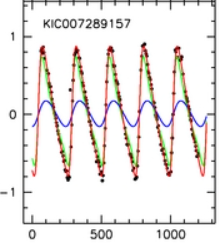

(x, time-span: ~1300 d ; y, O-C in kilosecs)

Source:  `2013ApJ...768...33R` [Triple-star Candidates among the Kepler Binaries](https://ui.adsabs.harvard.edu/abs/2013ApJ...768...33R/abstract) 


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 270782003 
kicid = 7289157  # ETV amplitude ~1700s
# reference: 2013ApJ
# 
# TODO: consider to include Kepler data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u



sr = lk.search_lightcurve('KIC{}'.format(kicid))
sr = sr[sr.exptime == 1800 * u.s]  # exclude 1 quarter that has both 30min and 1min cadence data
sr = lke._sort_chronologically(sr)
display(sr)
lcc_kplr = sr.download_all()
lc_kplr = lcc_kplr[:].stitch()
lc_kplr.time.format = "mjd"  # to be consistent with the paper result, also for ease of combining with TESS data
lc_kplr = lc_kplr.truncate(None, 55800)  # test with a few ETV cycles based on reference plot

# sr = lk.search_lightcurve('TIC {}'.format(ticid), )  # TESS data (in QLP) somehow has no periodic dips. ZTF data has none neither.
# sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
# sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
# display(sr)
# lc_tess = sr.download_all().stitch()
# lc_tess.time.format = "mjd"

search_result = lk.LightCurveCollection([
    lc_kplr,
    # lc_tess,
]).stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 17 data products.

 #       mission      year author exptime  target_name  distance proposal_id
                                     s                   arcsec             
--- ----------------- ---- ------ ------- ------------- -------- -----------
  0 Kepler Quarter 01 2009 Kepler    1800 kplr007289157      0.0          EX
  1 Kepler Quarter 02 2009 Kepler    1800 kplr007289157      0.0          EX
  2 Kepler Quarter 03 2009 Kepler    1800 kplr007289157      0.0          EX
  3 Kepler Quarter 04 2010 Kepler    1800 kplr007289157      0.0          EX
  4 Kepler Quarter 05 2010 Kepler    1800 kplr007289157      0.0          EX
  5 Kepler Quarter 06 2010 Kepler    1800 kplr007289157      0.0          EX
  6 Kepler Quarter 07 2010 Kepler    1800 kplr007289157      0.0          EX
  7 Kepler Quarter 08 2011 Kepler    1800 kplr007289157      0.0          EX
  8 Kepler Quarter 09 2011 Kepler    1800 kplr007289157      0.0          EX
  9 Kepler Quarter 10 2011 Kepler    1800 kplr007289157      0.0          EX
 10 Kepler Quarter 11 2012 Kepler    1800 kplr007289157      0.0          EX
 11 Kepler Quarter 12 2012 Kepler    1800 kplr007289157      0.0          EX
 12 Kepler Quarter 13 2012 Kepler    1800 kplr007289157      0.0          EX
 13 Kepler Quarter 14 2012 Kepler    1800 kplr007289157      0.0          EX
 14 Kepler Quarter 15 2013 Kepler    1800 kplr007289157      0.0          EX
 15 Kepler Quarter 16 2013 Kepler    1800 kplr007289157      0.0          EX
 16 Kepler Quarter 17 2013 Kepler    1800 kplr007289157      0.0          EX

37582

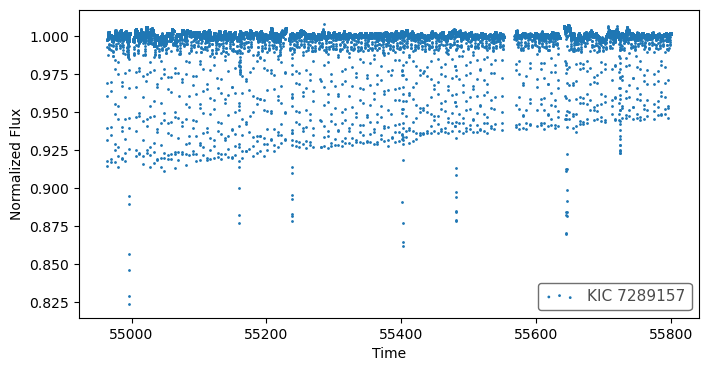

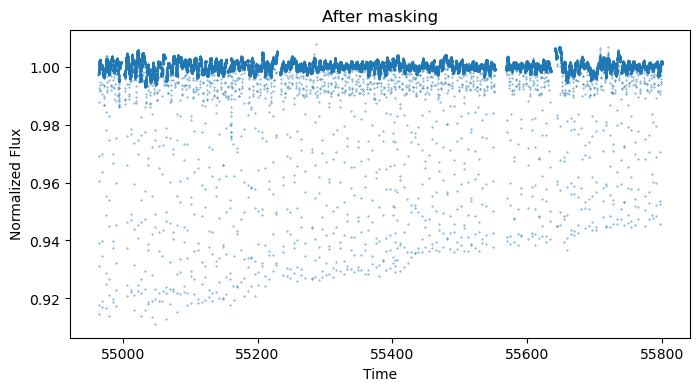

In [5]:
%matplotlib inline
# %matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)


# many additinal dips. masking out the extra deep ones. There are still some additional dips that should have been masked out too
mask = time < 0  # ( time > 54950) & (time < 55050)  #  truncate weird spikes at the beginning of Kepler data  
mask = mask | ( time > 54995) & (time < 54996)
mask = mask | ( time > 55159.1) & (time < 55159.4)
mask = mask | ( time > 55238.3) & (time < 55238.7)
mask = mask | ( time > 55401.7) & (time < 55402.0)
mask = mask | ( time > 55481.0) & (time < 55481.4)
mask = mask | ( time > 55644.0) & (time < 55647.0)
mask = mask | ( time > 55723.7) & (time < 55724.2)


time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

In [14]:
5.26 * 0.4

2.104

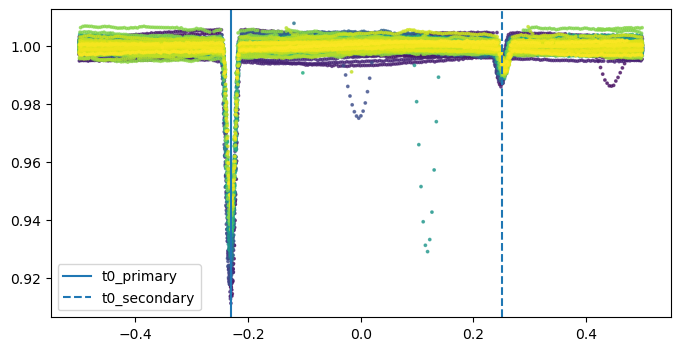

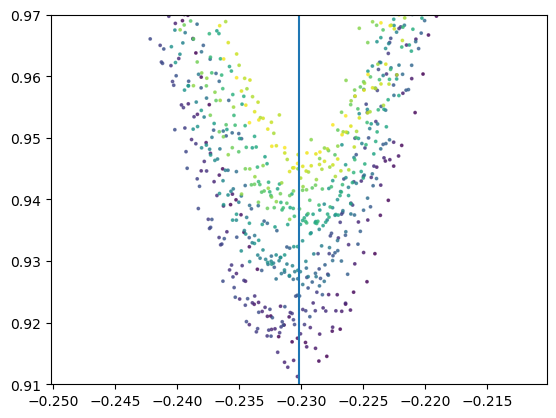

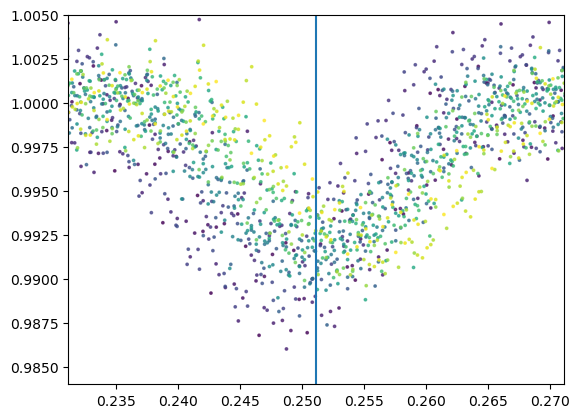

In [13]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# period = 5.2658073  # Kepler EB Period
period = 5.26640  # 2013ApJ Period


t0_primary = 54969.976049 - 0.005 - 0.5  # Kepler EB, the MJD there seems to be off by 0.5, additional shift upon manual inspection
t0_secondary = t0_primary + 2.535  # Kepler EB has no secondary, done with manual inspection

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 0.0530 * period * 24  # used for the window to cut the lighcurve around eclipses in later cells
duration_hr_secondary = duration_hr_primary * 0.6  # just a guestimate

t0_for_plotting = 0  # keep 0 for plotting purposes
# t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.35  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.02, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.02);
plt.ylim(0.91, 0.97);
plt.show()


# secondary
plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.02, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.02);
plt.ylim(0.984, 1.005);
plt.show()

### Now that the data is ready we can start 

In [47]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0      54964.012229  0.997458  0.000091 -0.266704
1      54964.032664  0.997296  0.000091 -0.262824
2      54964.053098  0.997528  0.000091 -0.258944
3      54964.073533  0.997564  0.000091 -0.255064
4      54964.093967  0.997720  0.000091 -0.251183
...             ...       ...       ...       ...
37240  55799.912103  1.001915  0.000092  0.456498
37241  55799.932537  1.001760  0.000092  0.460378
37242  55799.952970  1.002096  0.000092  0.464258
37243  55799.973404  1.001675  0.000092  0.468138
37244  55799.993837  1.001923  0.000092  0.472018

[37245 rows x 4 columns]

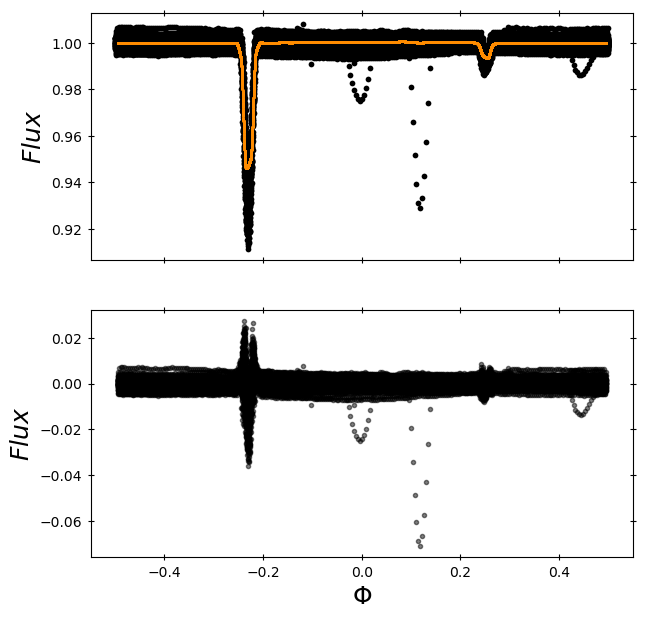

time      flux       err     phase  flux_sub_binary  \
0      54964.012229  0.997458  0.000091 -0.266704        -0.002484   
1      54964.032664  0.997296  0.000091 -0.262824        -0.002646   
2      54964.053098  0.997528  0.000091 -0.258944        -0.002430   
3      54964.073533  0.997564  0.000091 -0.255064        -0.002405   
4      54964.093967  0.997720  0.000091 -0.251183        -0.001074   
...             ...       ...       ...       ...              ...   
37240  55799.912103  1.001915  0.000092  0.456498         0.002072   
37241  55799.932537  1.001760  0.000092  0.460378         0.001923   
37242  55799.952970  1.002096  0.000092  0.464258         0.002263   
37243  55799.973404  1.001675  0.000092  0.468138         0.001832   
37244  55799.993837  1.001923  0.000092  0.472018         0.002058   

       binary_model  
0          0.999942  
1          0.999942  
2          0.999958  
3          0.999969  
4          0.998794  
...             ...  
37240      0.999843  
37241      0.999837  
37242      0.999833  
37243      0.999843  
37244      0.999866  

[37245 rows x 6 columns]

In [48]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 36876 901
reached the end
10 35489 901
reached the end
10 35297 901
reached the end
10 35235 901
reached the end
10 35192 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      54964.012229  0.997458  0.000091 -0.266704        -0.002484   
1      54964.032664  0.997296  0.000091 -0.262824        -0.002646   
2      54964.053098  0.997528  0.000091 -0.258944        -0.002430   
3      54964.073533  0.997564  0.000091 -0.255064        -0.002405   
4      54964.093967  0.997720  0.000091 -0.251183        -0.001074   
...             ...       ...       ...       ...              ...   
37240  55799.912103  1.001915  0.000092  0.456498         0.002072   
37241  55799.932537  1.001760  0.000092  0.460378         0.001923   
37242  55799.952970  1.002096  0.000092  0.464258         0.002263   
37243  55799.973404  1.001675  0.000092  0.468138         0.001832   
37244  55799.993837  1.001923  0.000092  0.472018         0.002058   

       binary_model  flux_detrended  
0          0.999942        0.999657  
1          0.999942        0.999482  
2          0.999958        0.999701  
3          0.999969        0.999722  
4          0.998794        0.999864  
...             ...             ...  
37240      0.999843        1.000115  
37241      0.999837        0.999947  
37242      0.999833        1.000270  
37243      0.999843        0.999832  
37244      0.999866        1.000063  

[37245 rows x 7 columns]

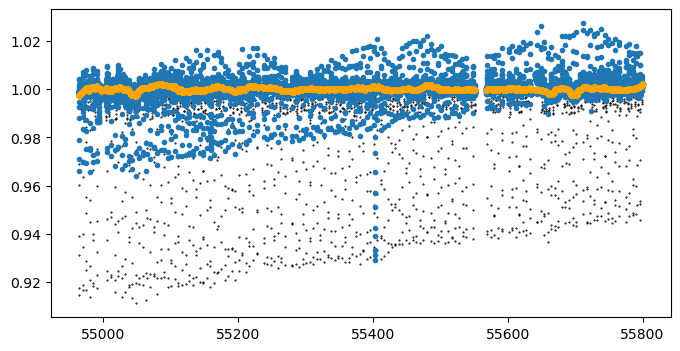

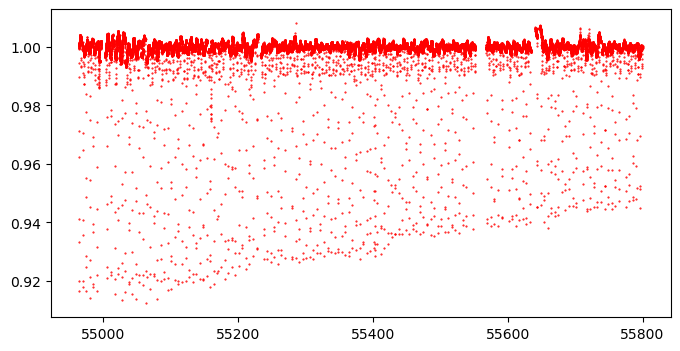

In [49]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

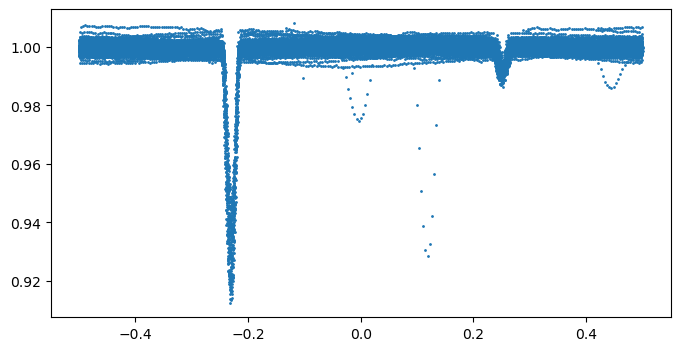

In [50]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   54964.204649 -0.2301669071845911
window_width_p (phase): 0.024
Secondary: 54966.739649 0.2511865790685406
window_width_s (phase): 0.03


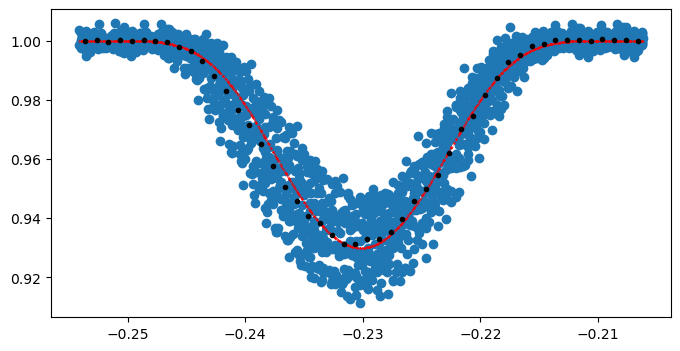

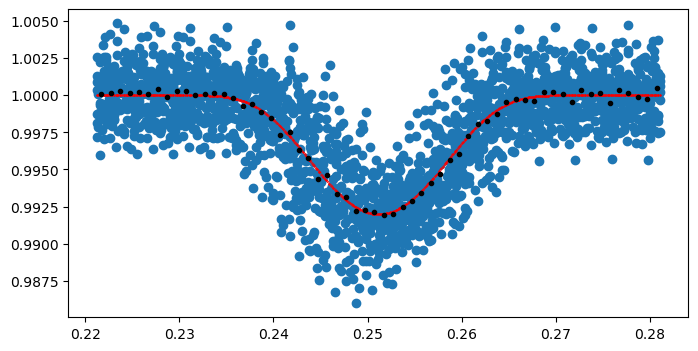

In [14]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
# window_width_p = 1.1 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
window_width_p = 0.024
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    window_width_s = 0.03
    # window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.00, -0.07, midpoint_p, 0.007, 1.0]
start_vals_s = [1.00, -0.008, midpoint_s, 0.007, 1.0]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [11]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = False

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

Use pre-defined inital model params:


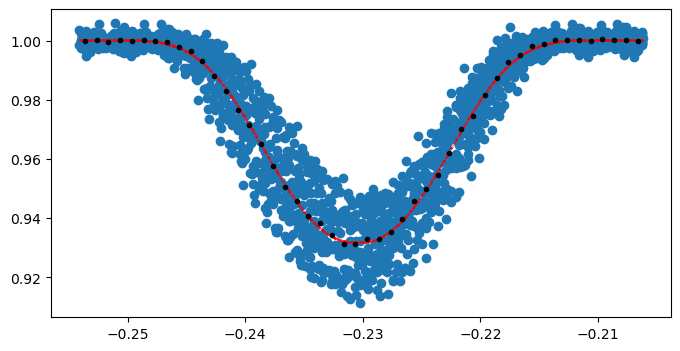

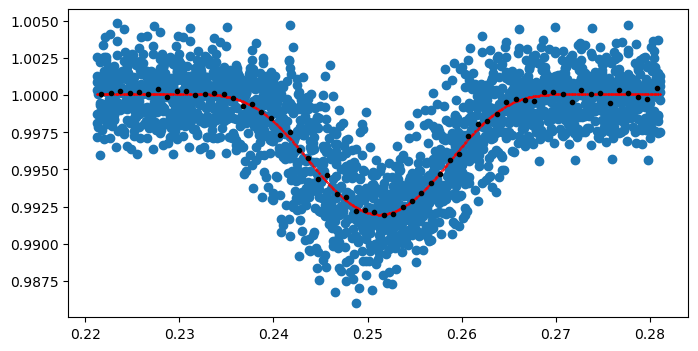

In [15]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")

    # initial fit params from Kepler data (<MJD 55800) 2013Apj Period
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0003366710849937, -0.06855468349996802, -0.23049745550050382, 0.007068286881026096, 1.1308849945226371
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0000924405906262, -0.008121749571054918, 0.2512594779208649, 0.007267941693068762, 0.9880877043991461

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [76]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0003366710849937, -0.06855468349996802, -0.23049745550050382, 0.007068286881026096, 1.1308849945226371
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0000924405906262, -0.008121749571054918, 0.2512594779208649, 0.007267941693068762, 0.9880877043991461


158

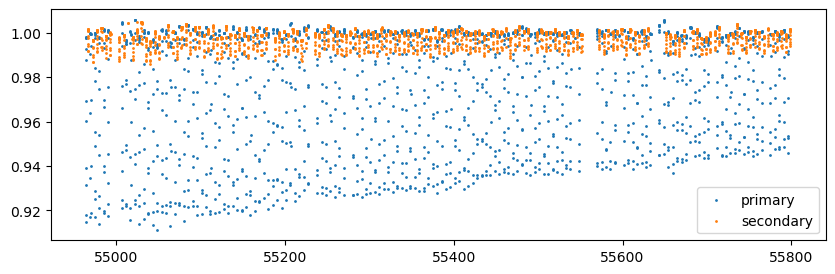

In [77]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

54964.204649 5.2664 54964.204649


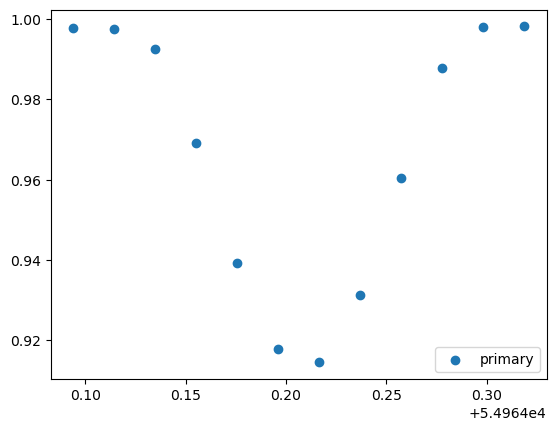

54964.204649 5.2664 54969.471049


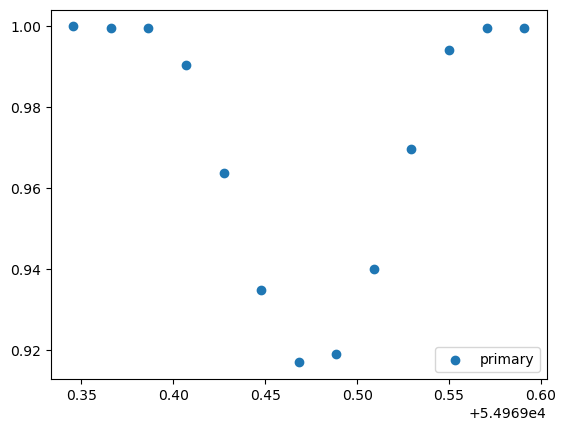

54964.204649 5.2664 54974.737449


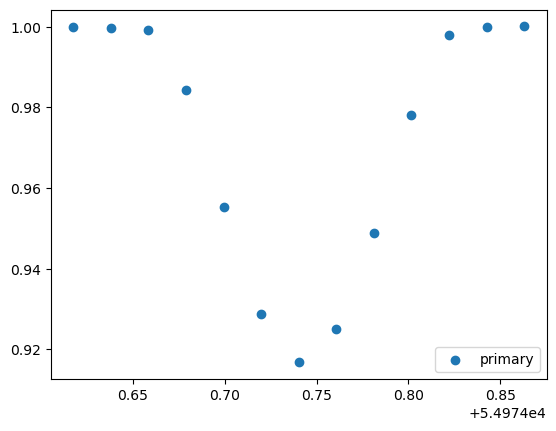

54966.739649 5.2664 54966.739649


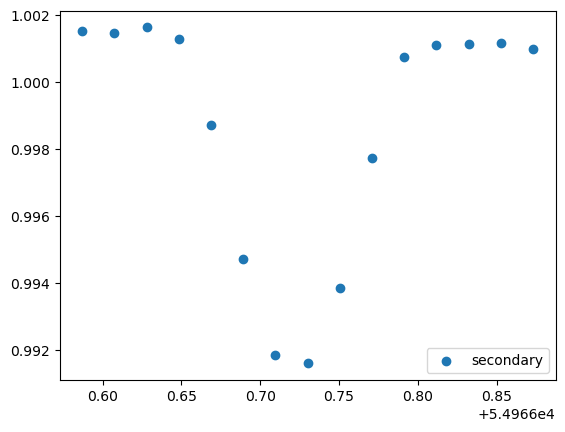

54966.739649 5.2664 54972.006049


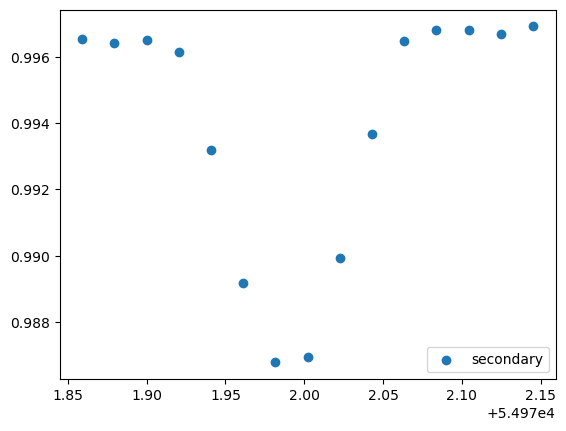

54966.739649 5.2664 54977.272449000004


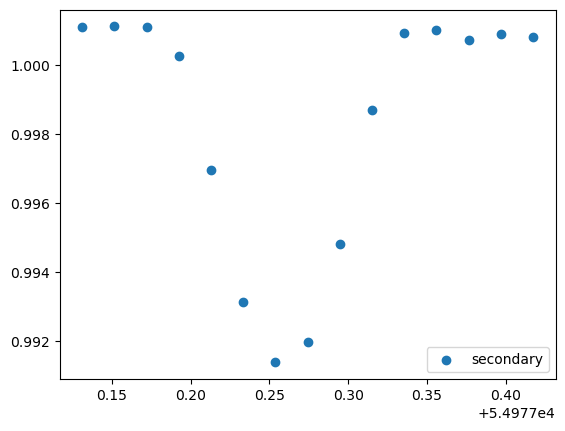

In [78]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Creating new manifest file
54964.204649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.81it/s]


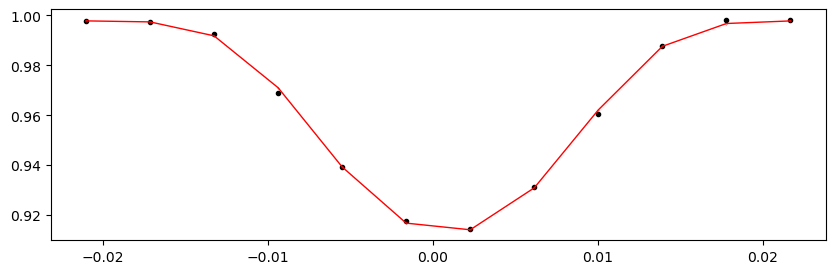

54969.471049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.68it/s]


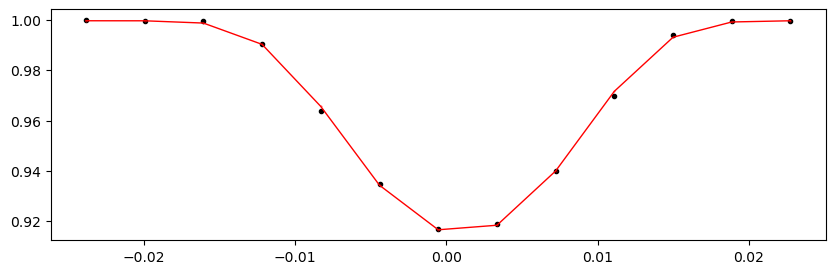

54974.737449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.48it/s]


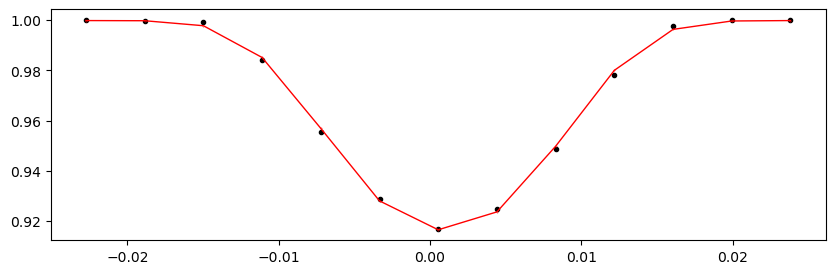

54980.003849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.69it/s]


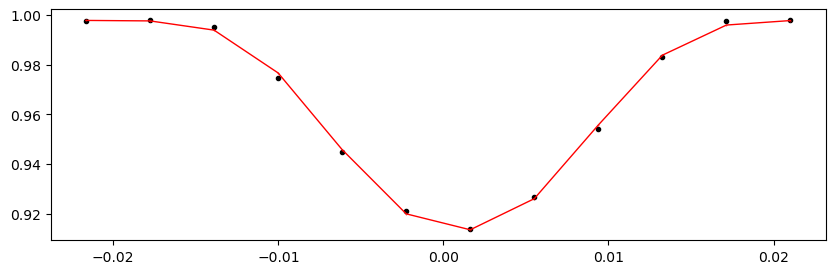

54985.270249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.83it/s]


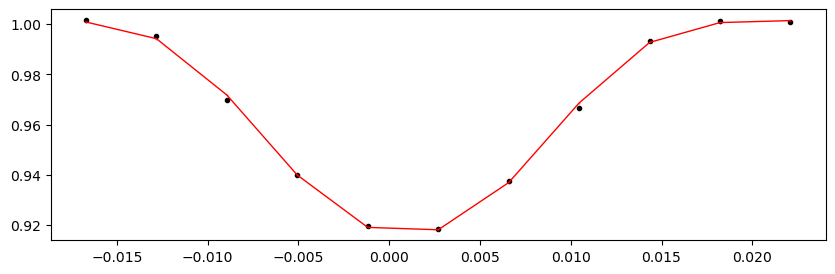

54990.536649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.73it/s]


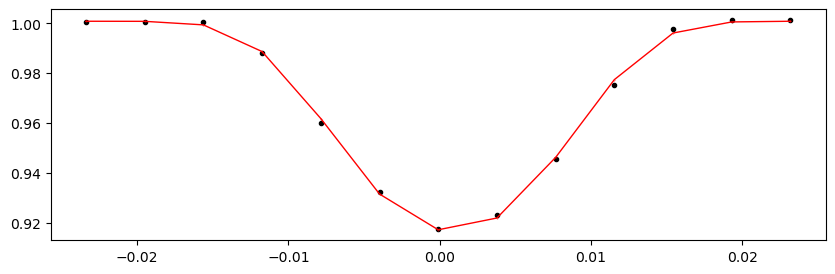

55006.335849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.90it/s]


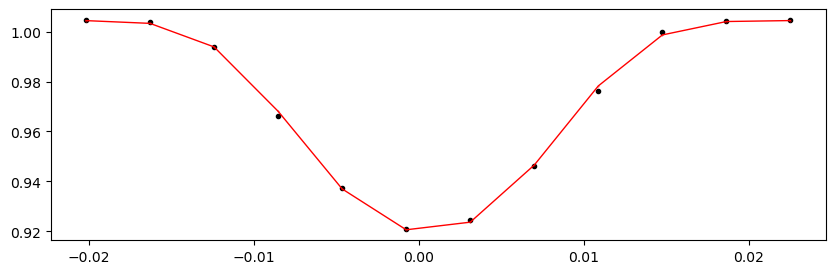

55011.602248999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.41it/s]


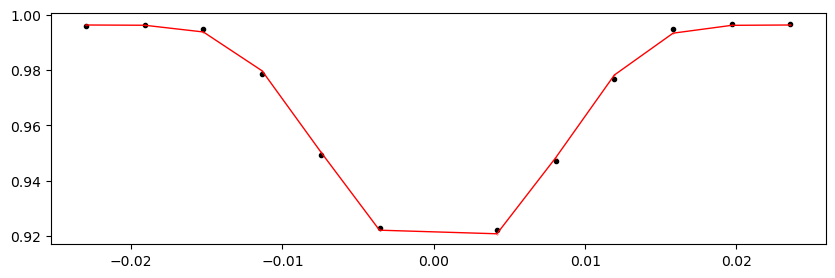

55016.868649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.97it/s]


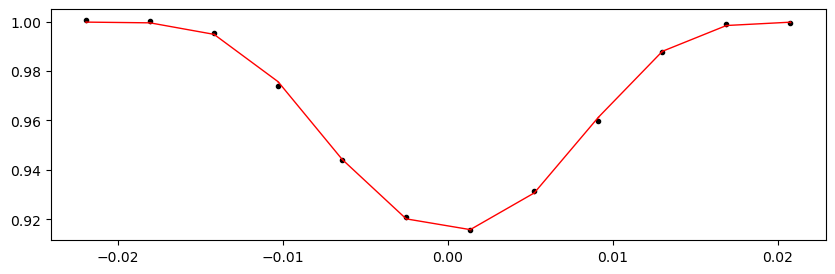

55022.135049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.06it/s]


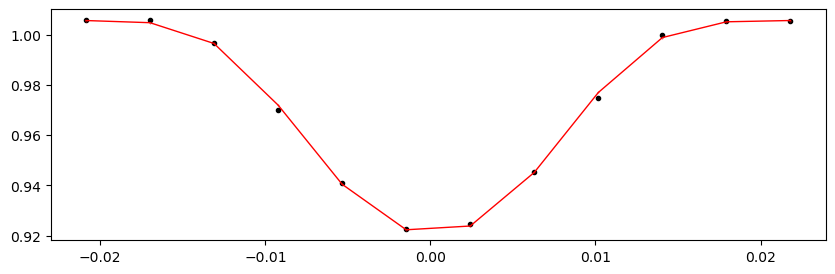

55027.401449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.09it/s]


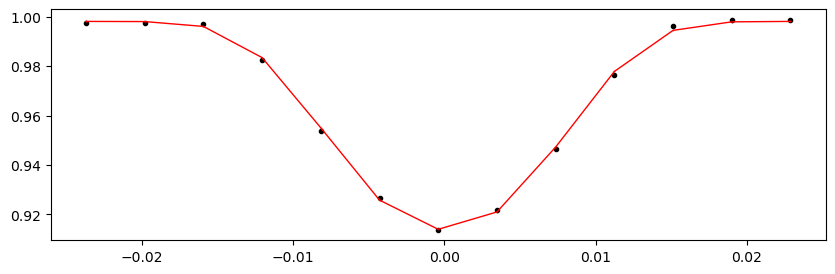

55032.667849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.43it/s]


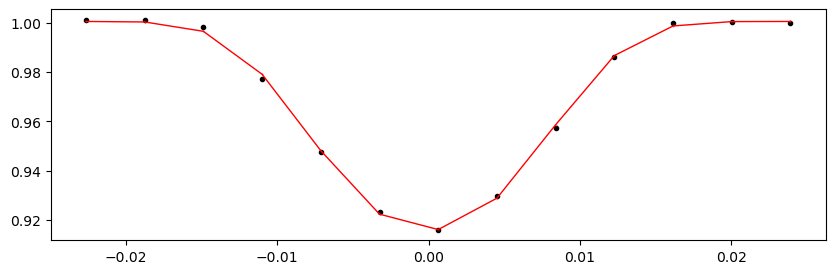

55037.934249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.10it/s]


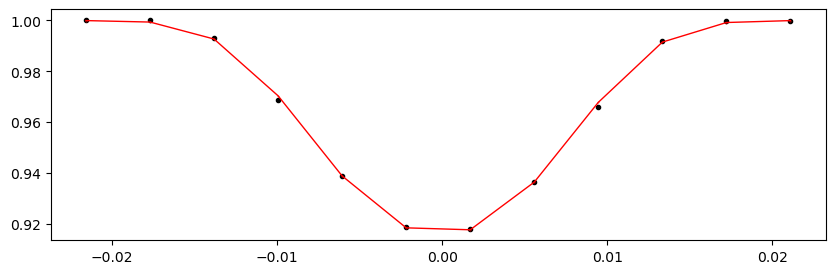

55043.200649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.24it/s]


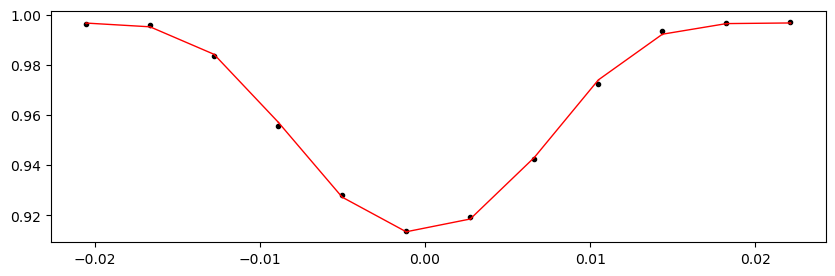

55048.467049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.05it/s]


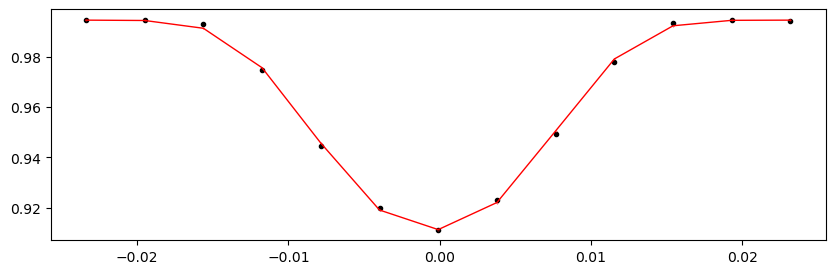

55053.733449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.94it/s]


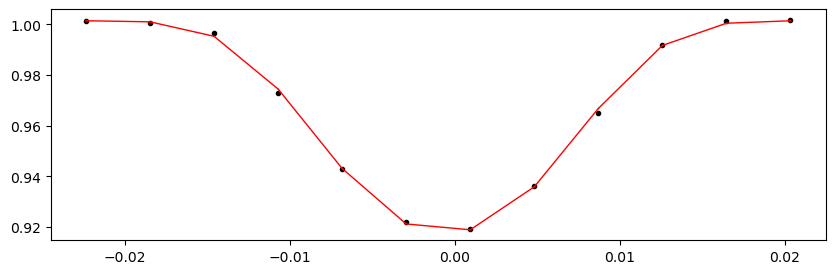

55058.999849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.29it/s]


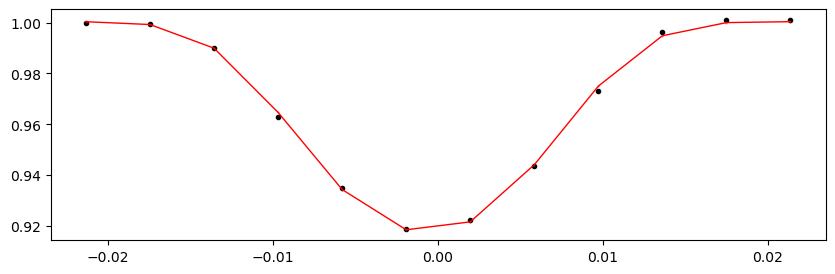

55064.266249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.23it/s]


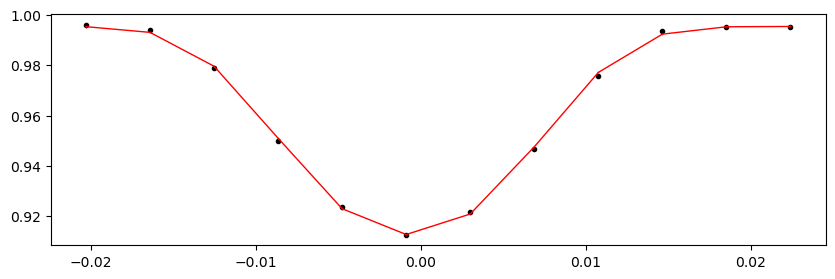

55069.532649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.63it/s]


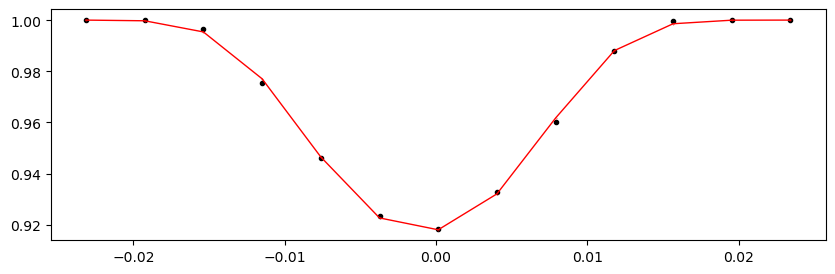

55074.799049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.44it/s]


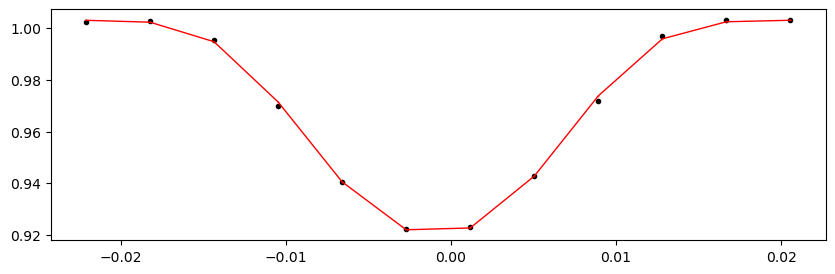

55080.065449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.74it/s]


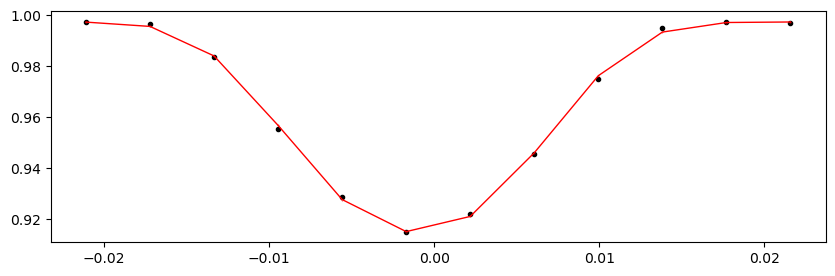

55085.331849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.38it/s]


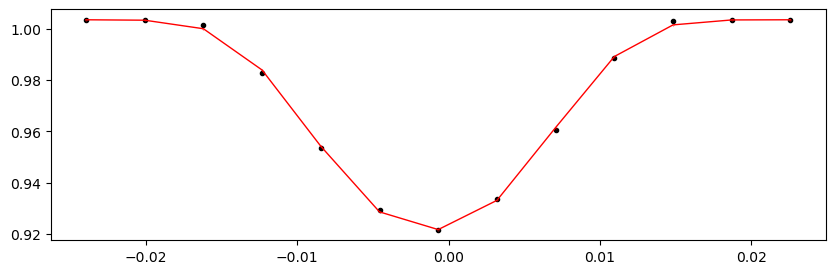

55090.598249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.14it/s]


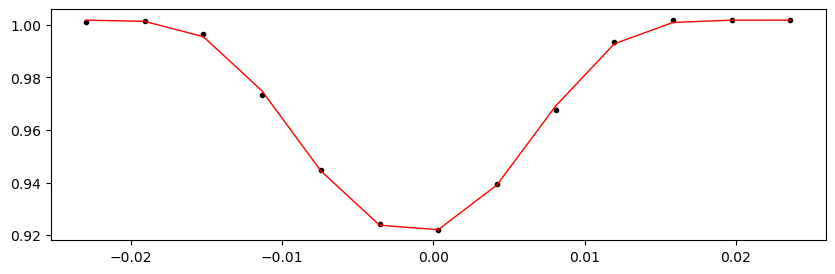

55095.864649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.24it/s]


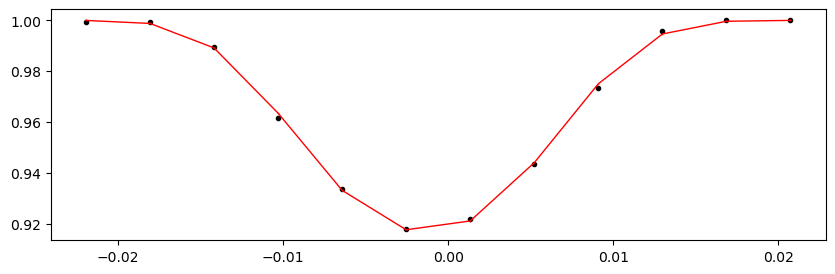

55101.131048999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.62it/s]


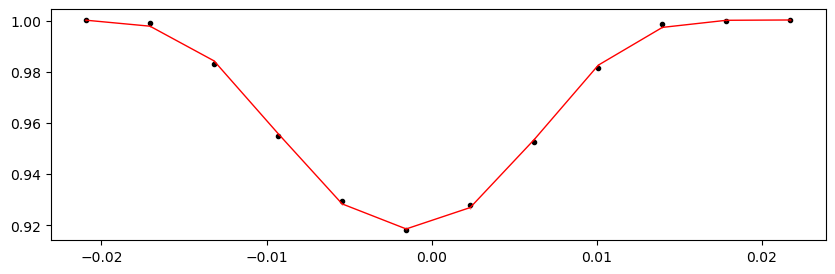

55106.397449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 310.95it/s]


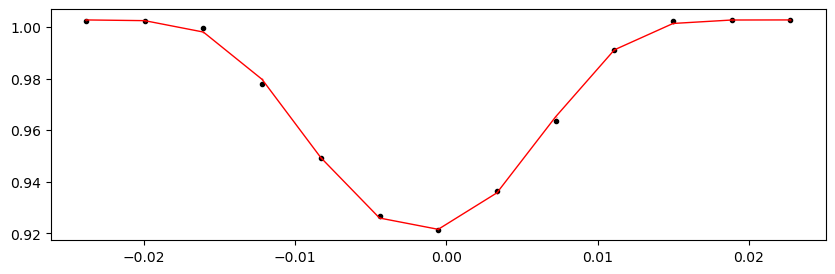

55111.663849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.98it/s]


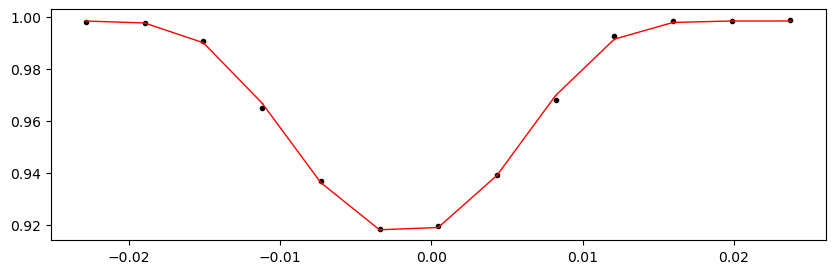

55116.930249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.59it/s]


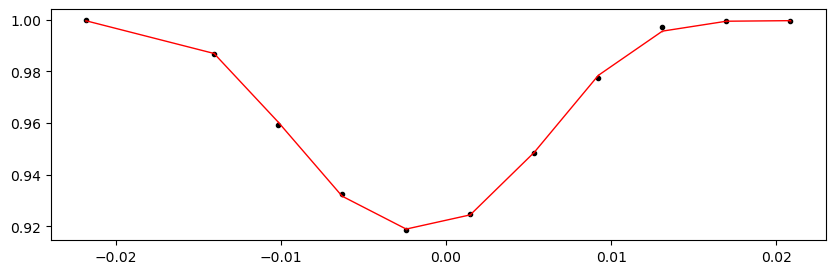

55122.196649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.46it/s]


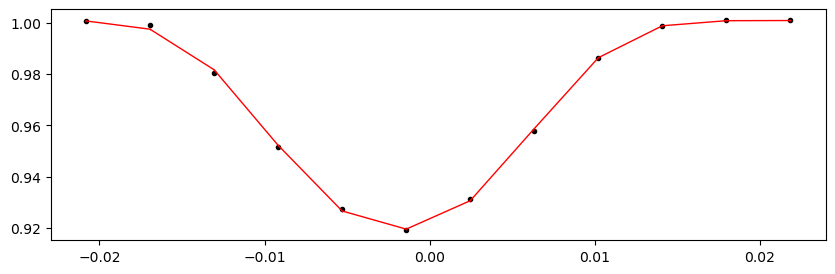

55127.463049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.75it/s]


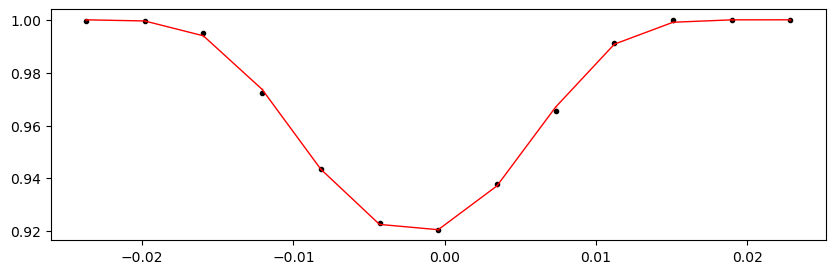

55132.729449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.93it/s]


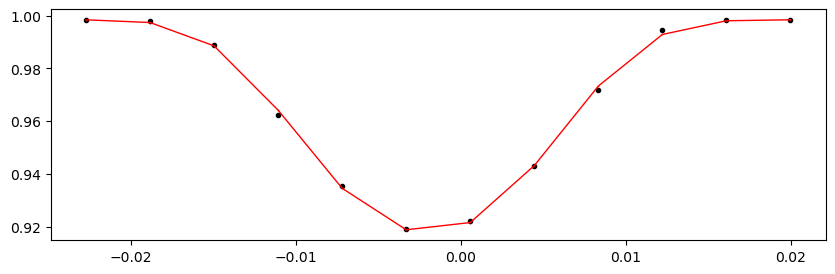

55137.995849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.76it/s]


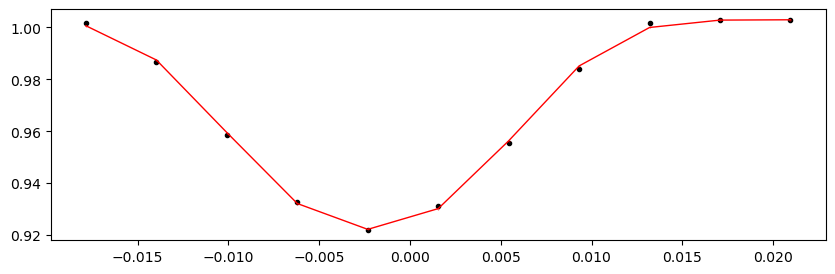

55143.262249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.31it/s]


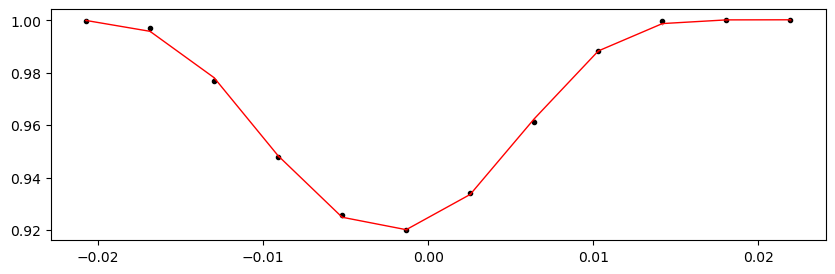

55148.528649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.11it/s]


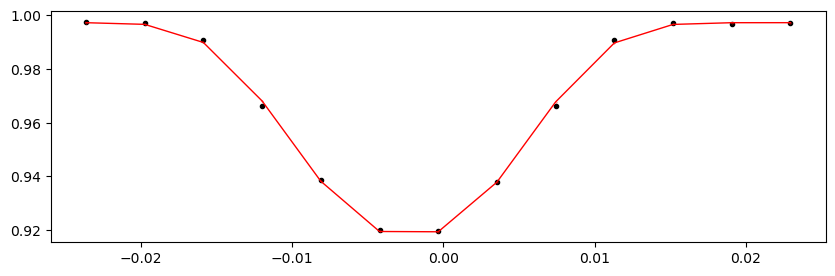

55153.795049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.66it/s]


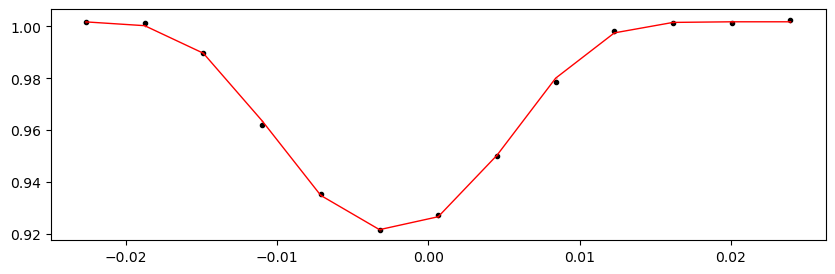

Time 55159.061449 does not have enough data points: 8
55164.327849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.69it/s]


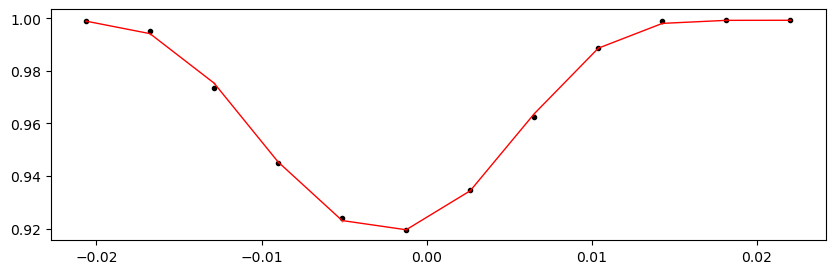

55169.594249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.50it/s]


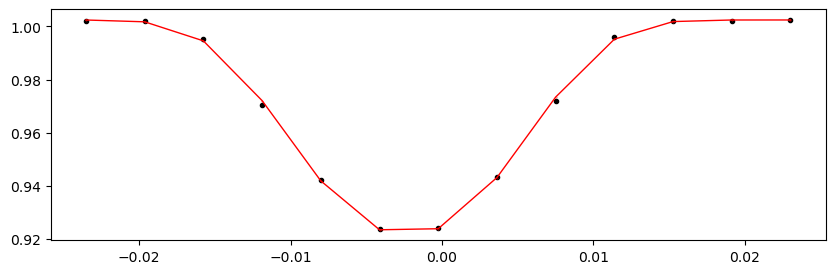

55174.860649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.20it/s]


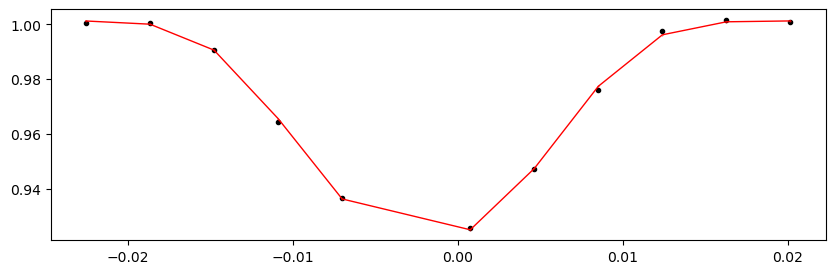

55180.127049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.86it/s]


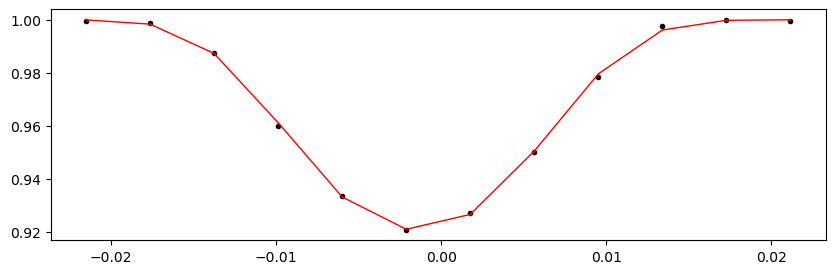

55185.393449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.35it/s]


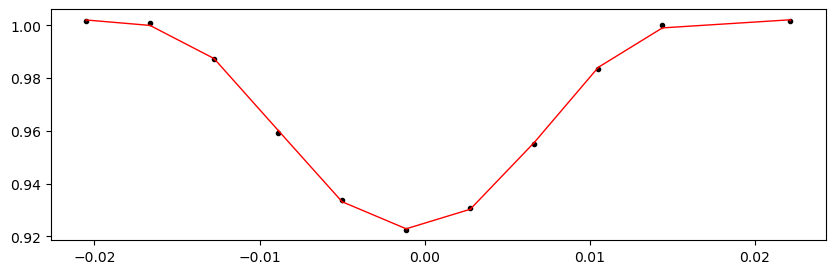

55190.659848999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.11it/s]


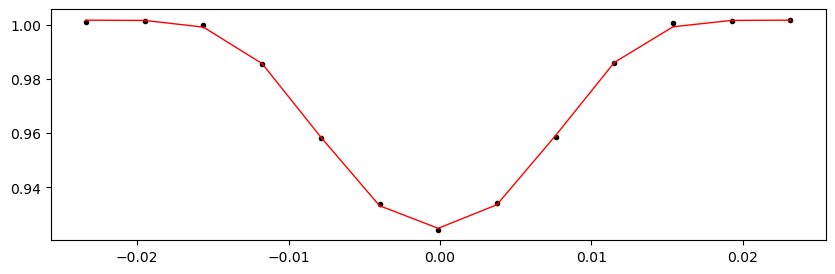

55195.926249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.12it/s]


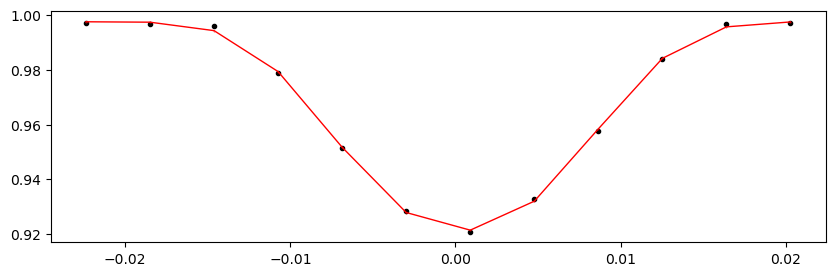

55201.192649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.67it/s]


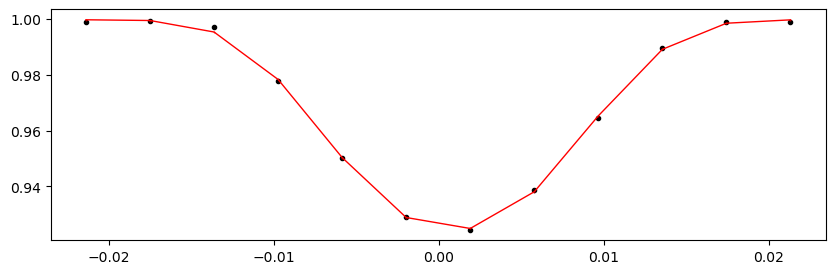

55206.459049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.97it/s]


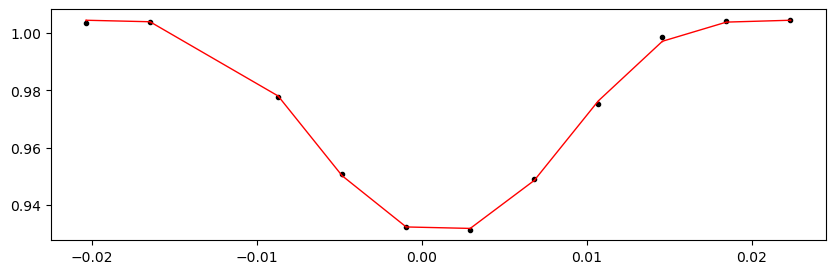

55211.725449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.62it/s]


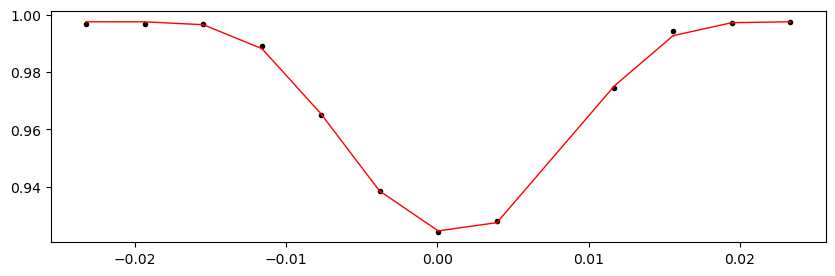

55216.991849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.31it/s]


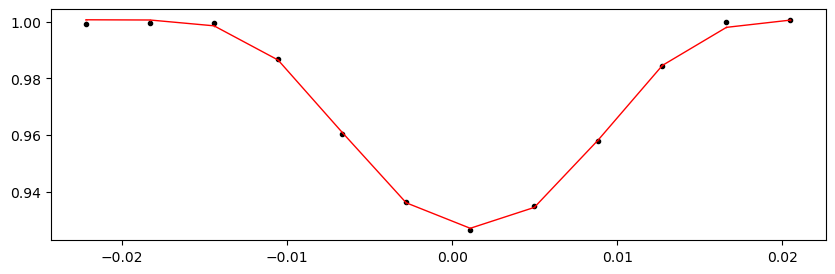

55222.258249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.86it/s]


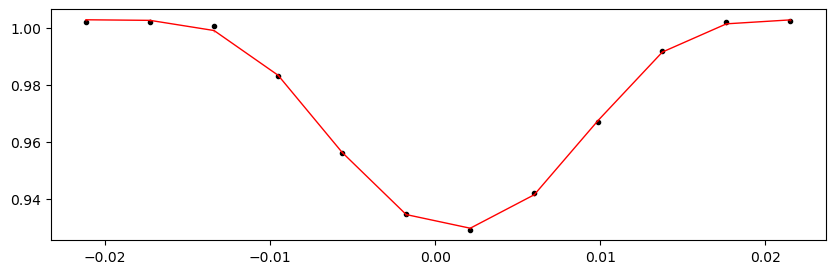

55227.524649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.60it/s]


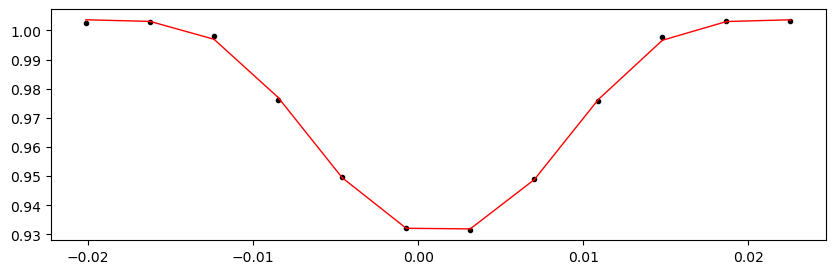

55238.057449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.72it/s]


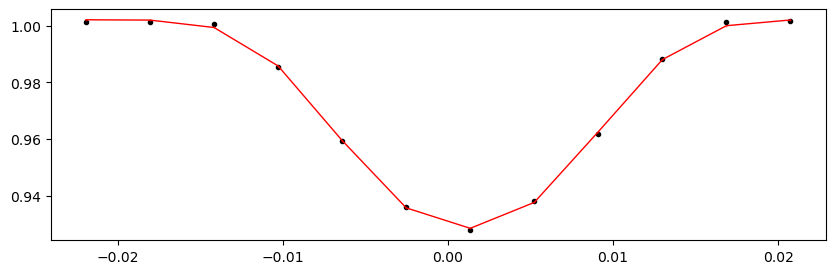

55243.323849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.19it/s]


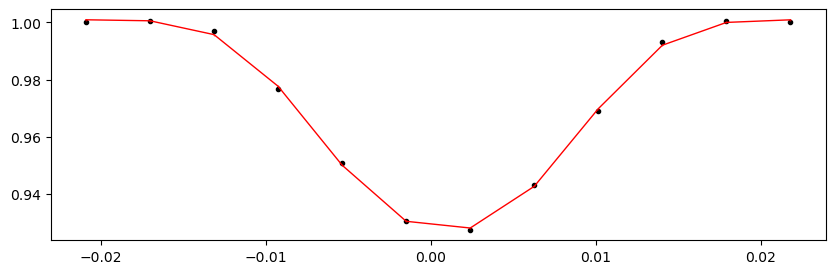

55248.590249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.86it/s]


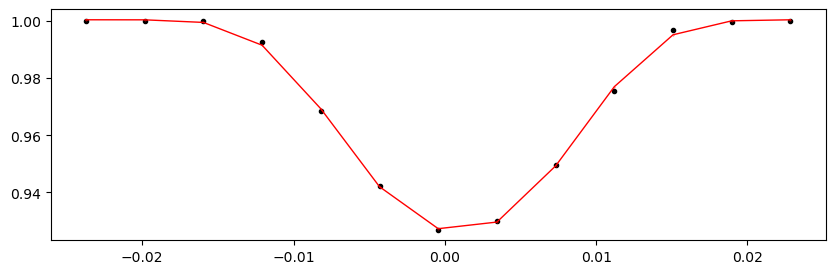

55253.856649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.34it/s]


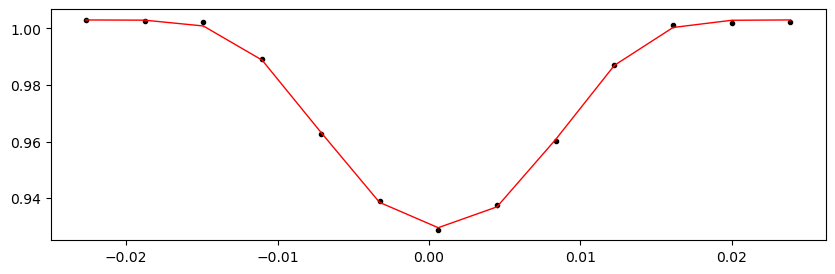

55259.123049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.68it/s]


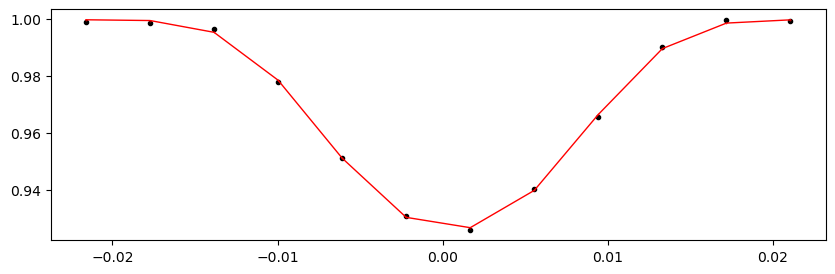

55264.389449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.82it/s]


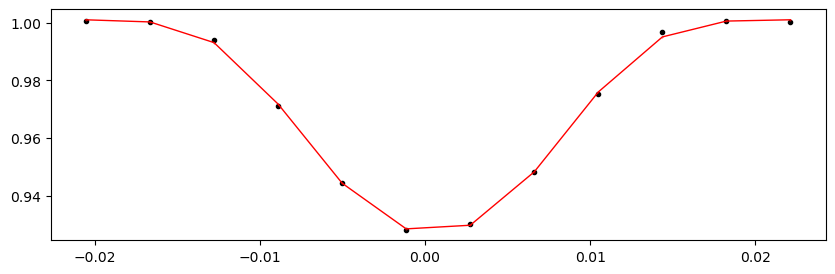

55269.655849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.03it/s]


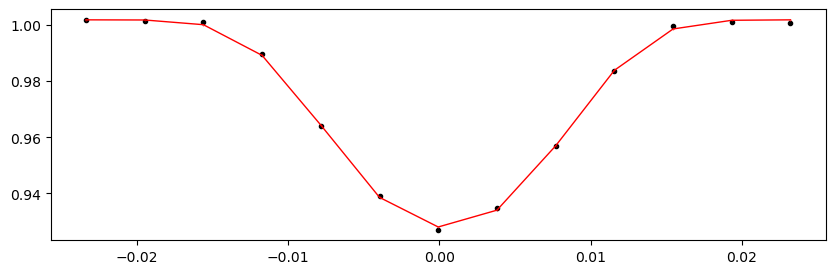

55280.188648999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.40it/s]


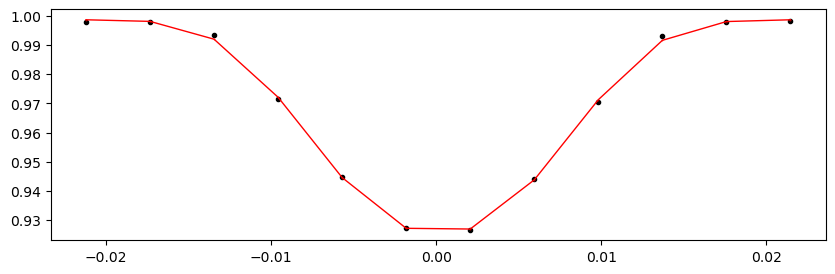

55285.455049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.26it/s]


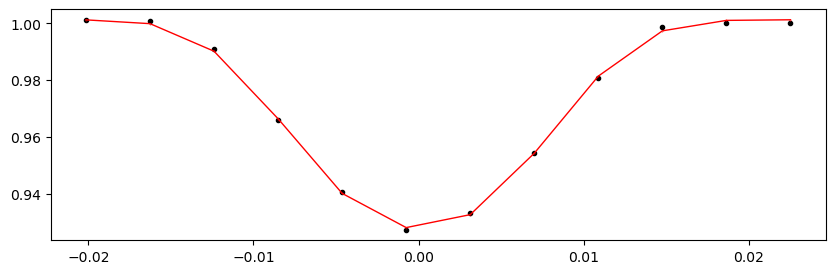

55290.721449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.22it/s]


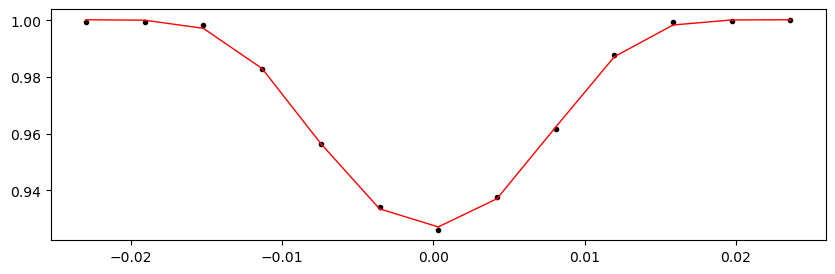

55295.987849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.11it/s]


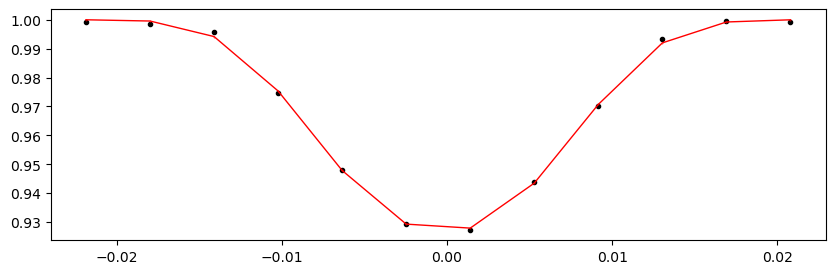

55301.254249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.75it/s]


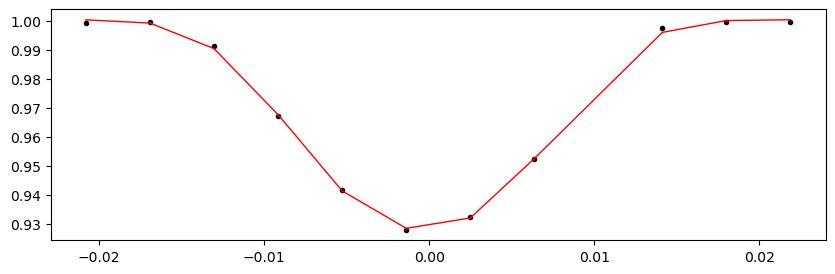

55306.520649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.86it/s]


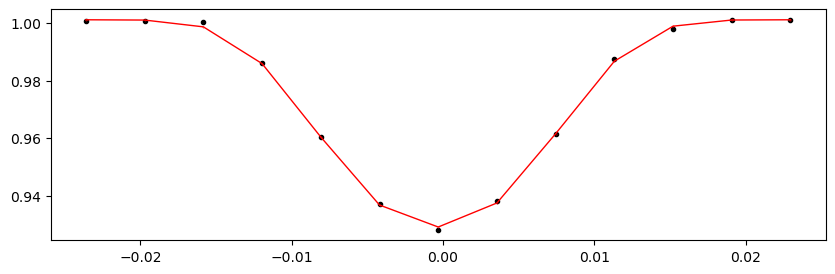

55311.787049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.68it/s]


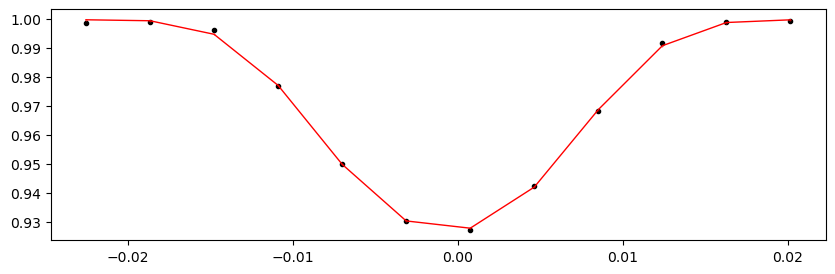

55317.053449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.00it/s]


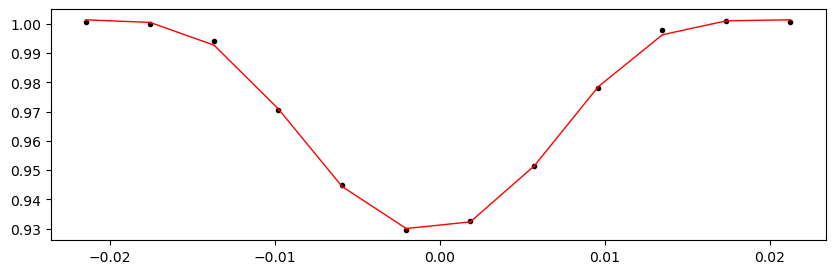

55322.319849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.33it/s]


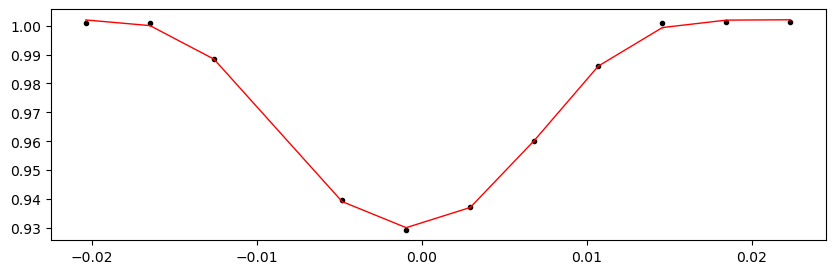

55327.586249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.94it/s]


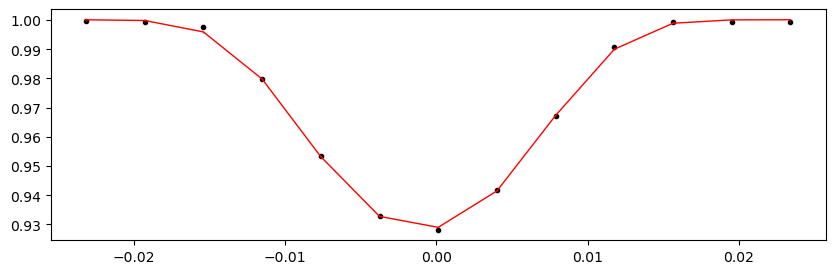

55332.852649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.80it/s]


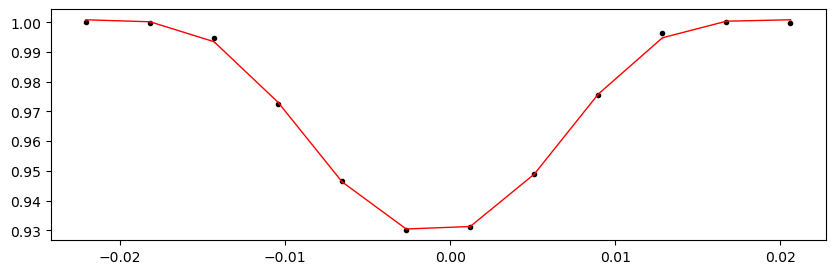

55338.119049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.73it/s]


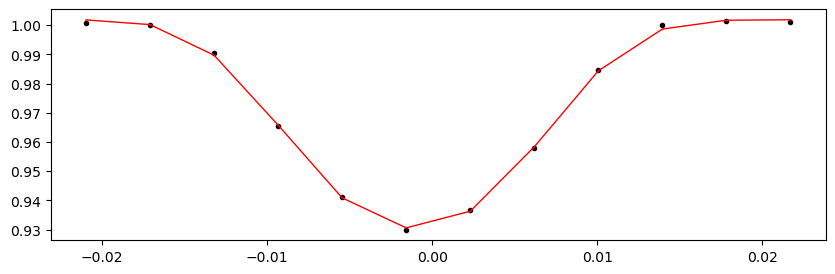

55343.385449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.63it/s]


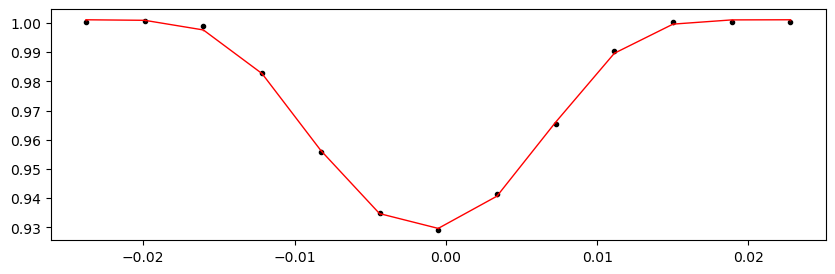

55348.651849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.74it/s]


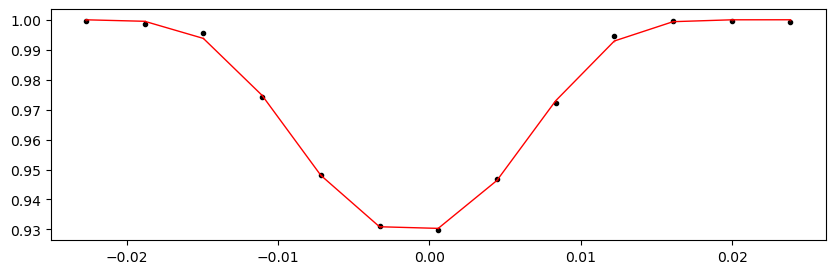

55353.918249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.66it/s]


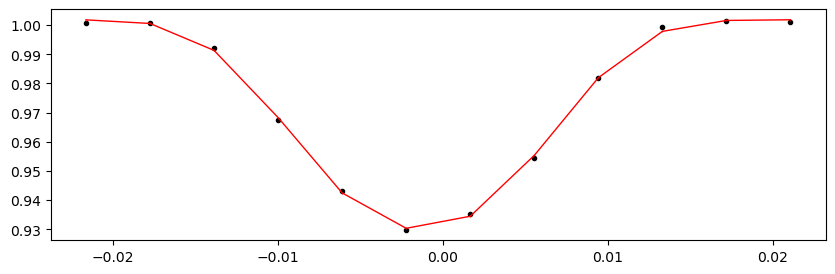

55359.184649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.63it/s]


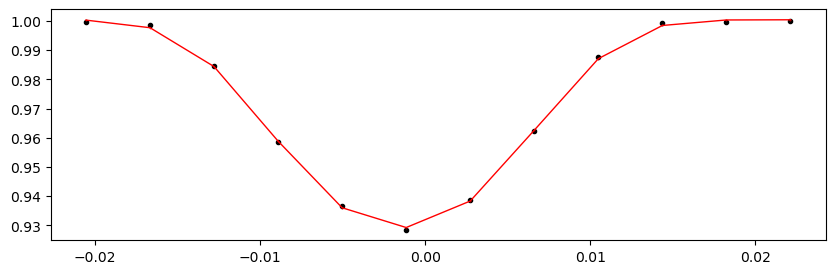

55364.451048999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.90it/s]


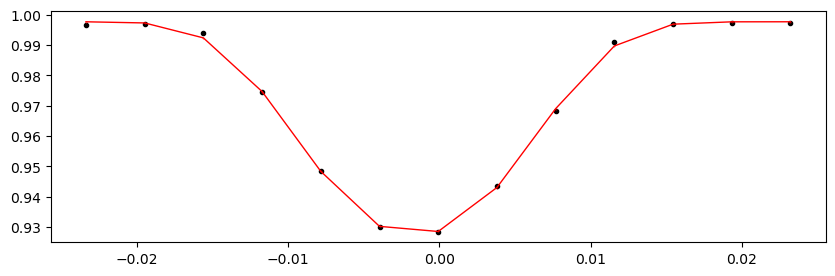

55369.717448999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.30it/s]


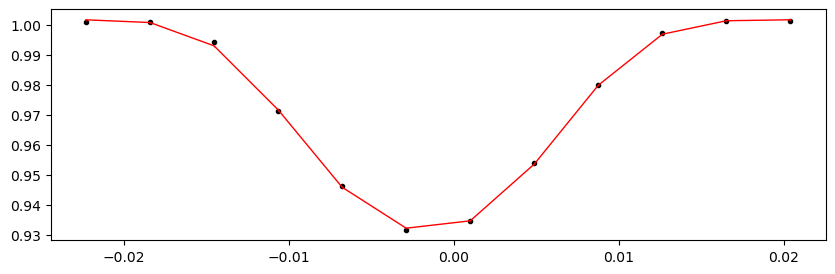

55374.983849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.11it/s]


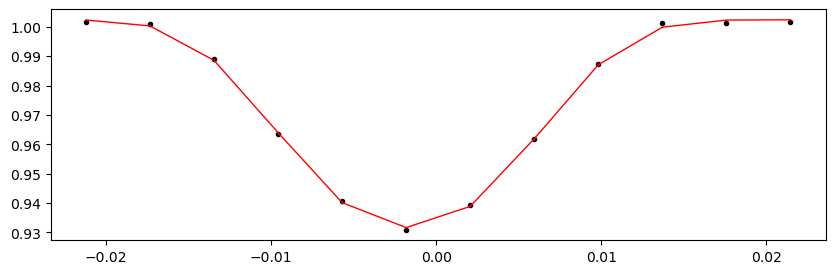

55380.250249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.99it/s]


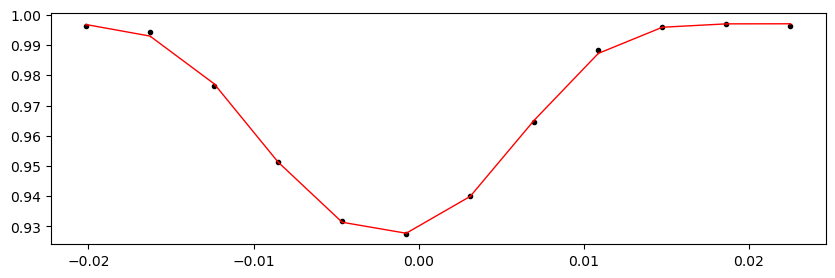

55385.516649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.07it/s]


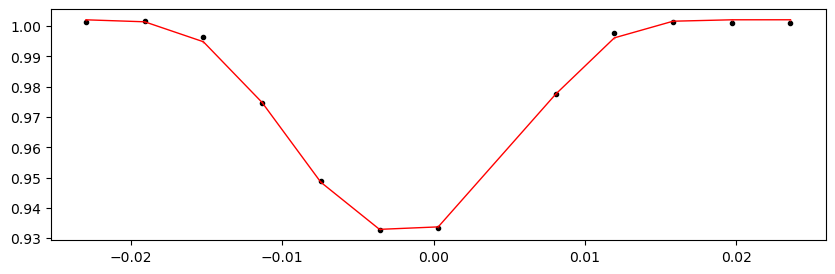

55390.783049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.63it/s]


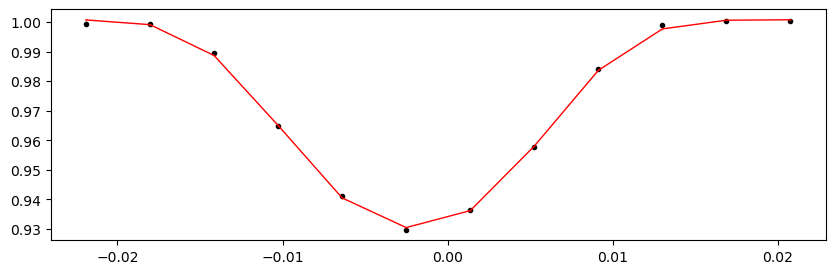

55396.049449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.85it/s]


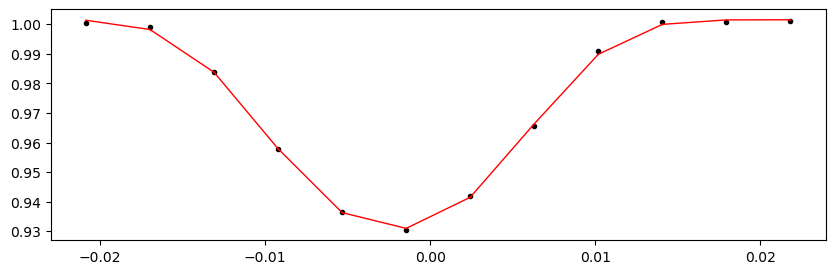

55401.315849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.08it/s]


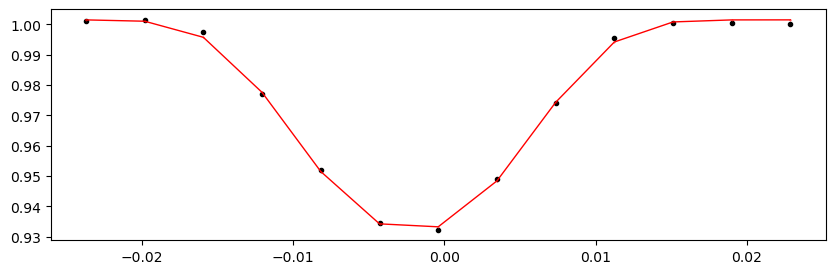

55406.582249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.82it/s]


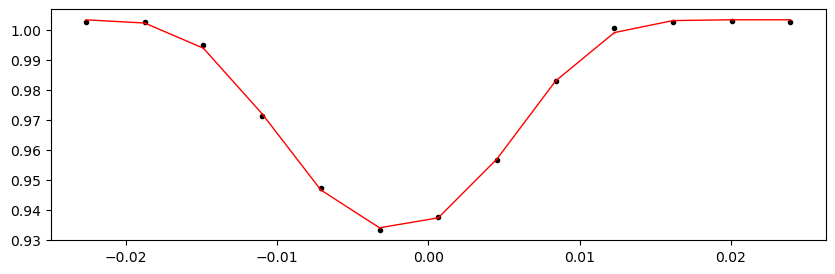

55411.848649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.42it/s]


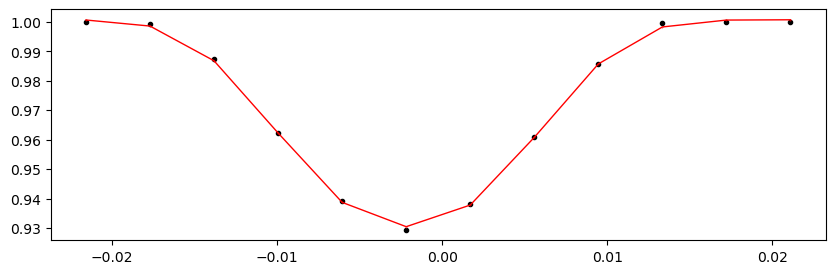

55417.115049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.98it/s]


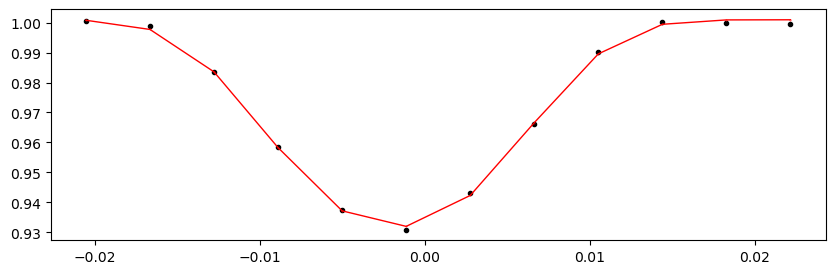

55422.381449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.80it/s]


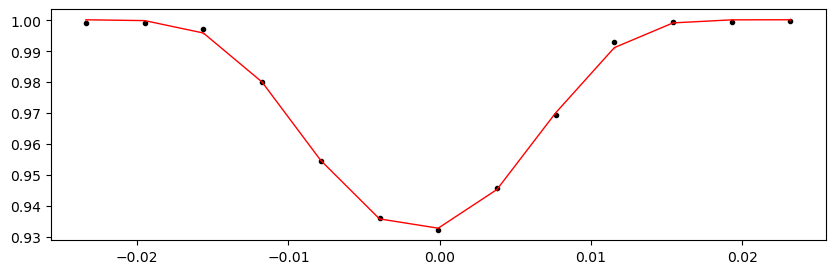

55427.647849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.76it/s]


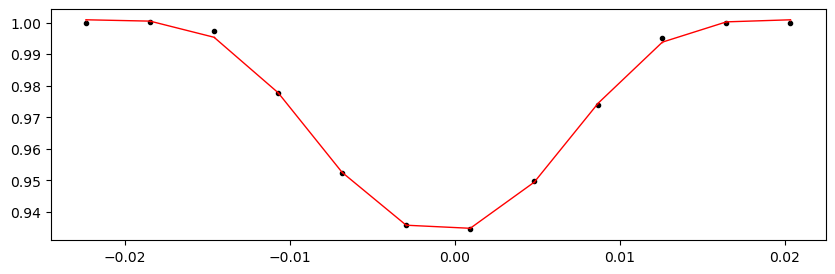

55432.914249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.78it/s]


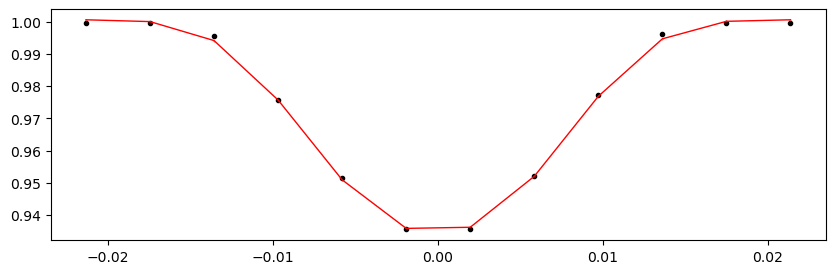

55438.180649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.13it/s]


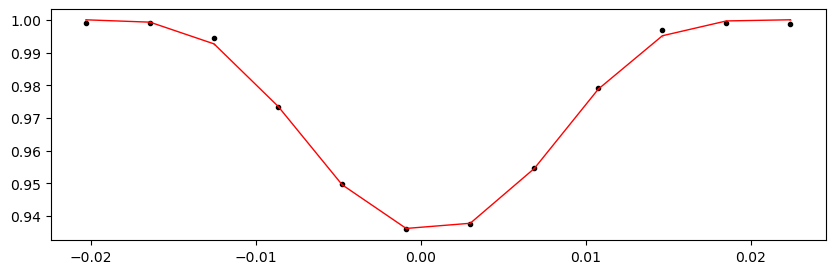

55443.447049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.29it/s]


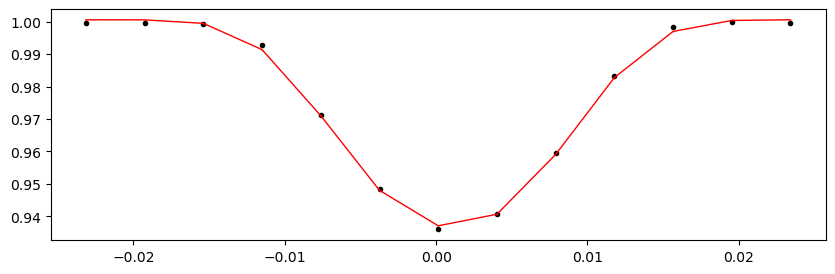

55448.713449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.68it/s]


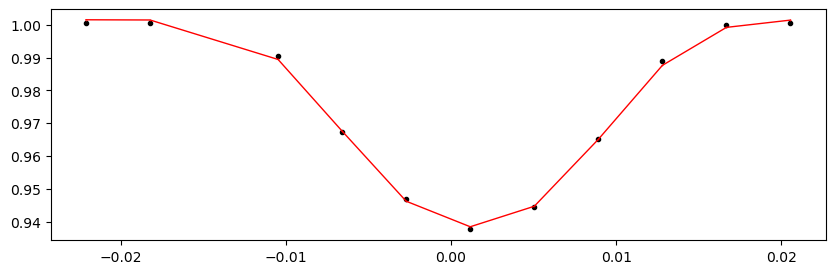

55453.979848999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.37it/s]


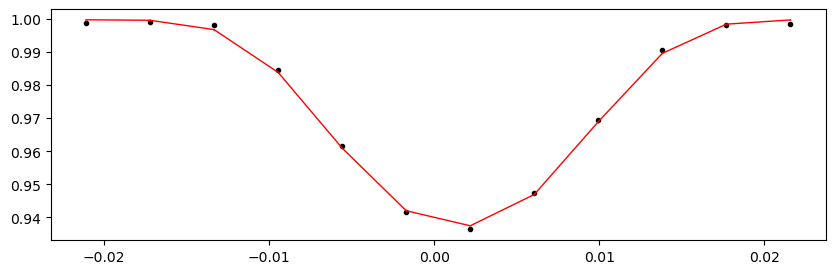

55459.246248999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.67it/s]


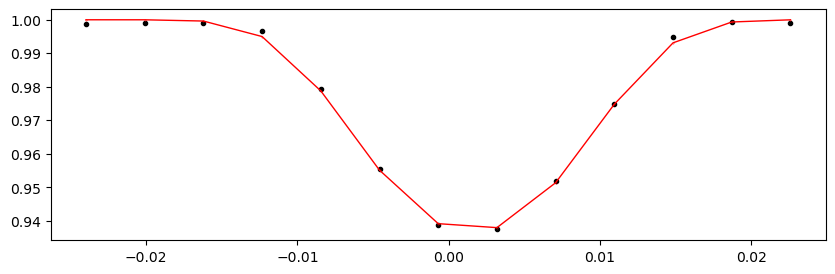

55464.512649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.11it/s]


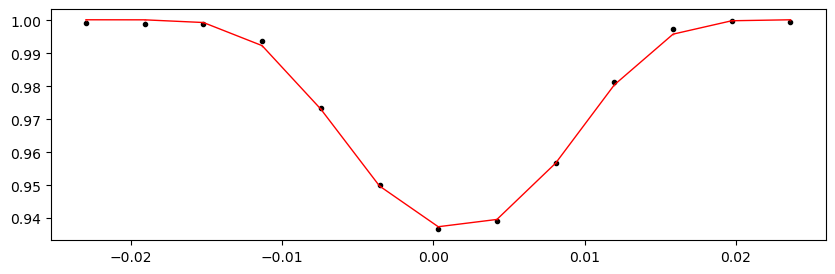

55469.779049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.56it/s]


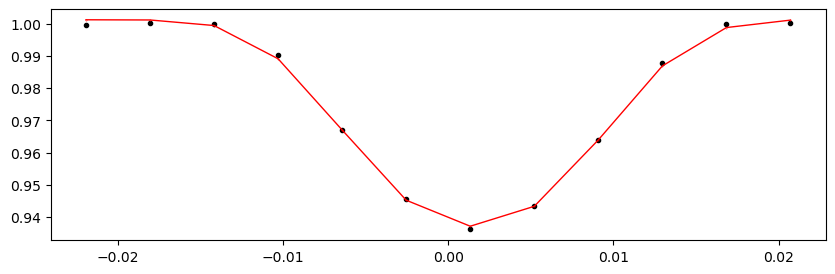

55475.045449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.27it/s]


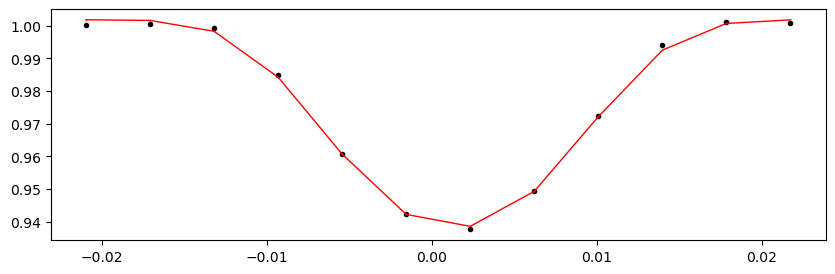

55480.311849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.54it/s]


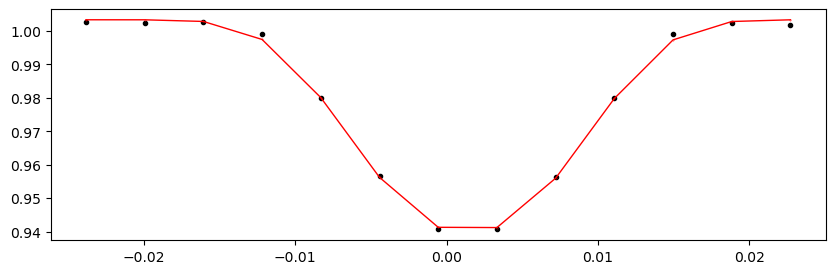

55485.578249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.20it/s]


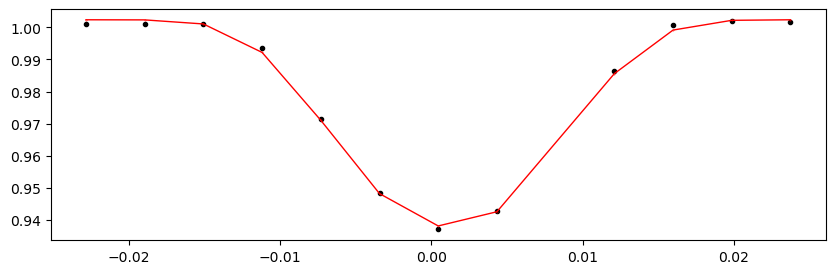

55490.844649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.90it/s]


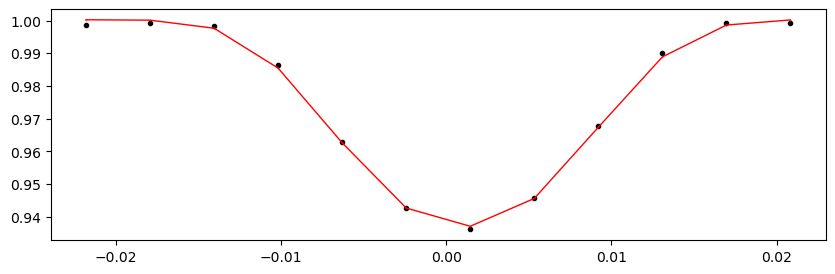

55496.111049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.26it/s]


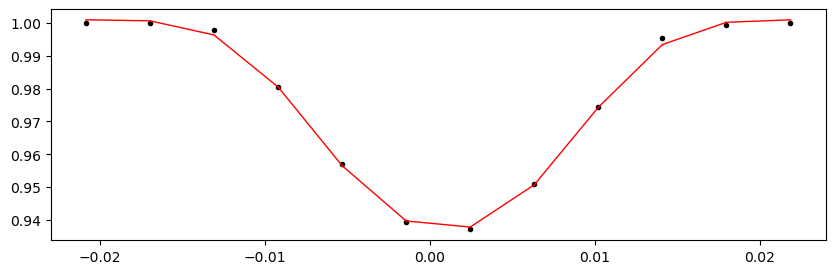

55501.377449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.21it/s]


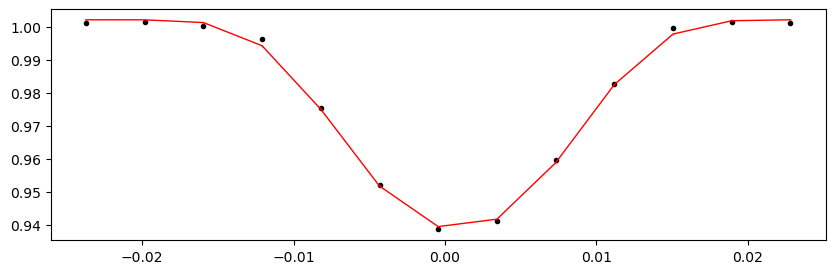

55506.643849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.90it/s]


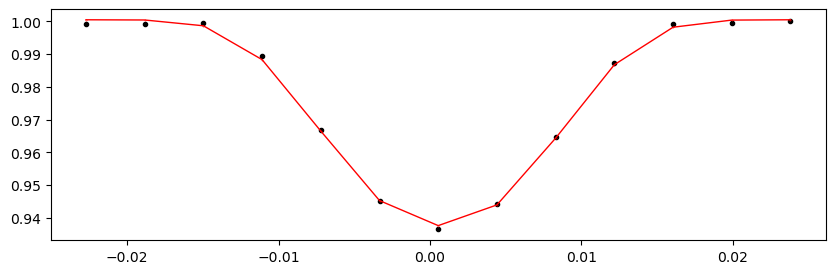

55511.910249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.92it/s]


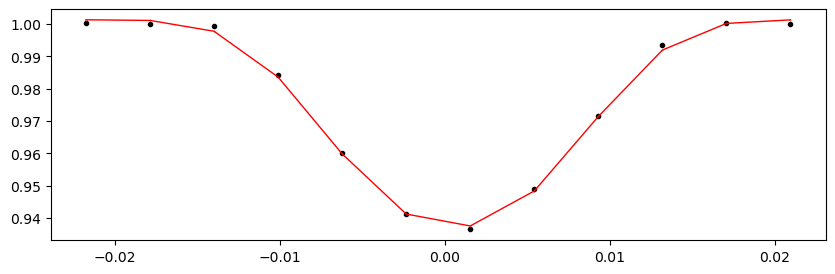

55517.176649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.20it/s]


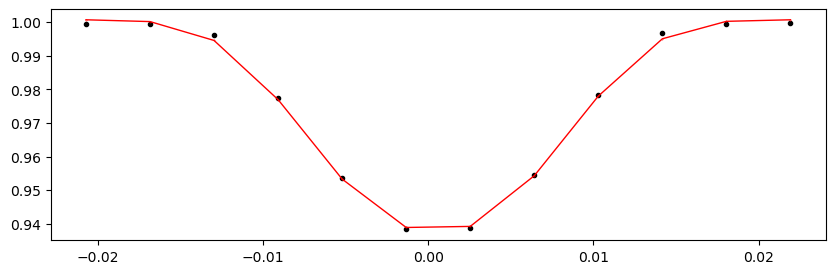

55522.443049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.58it/s]


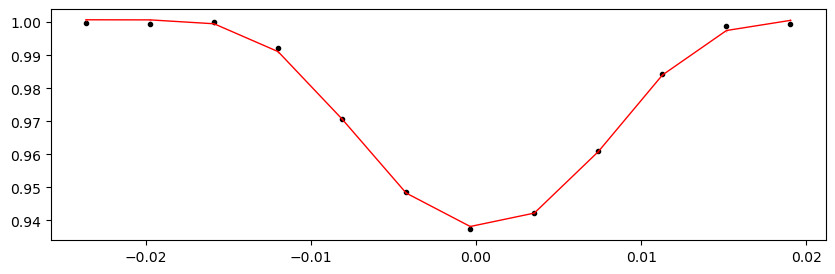

55527.709449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.66it/s]


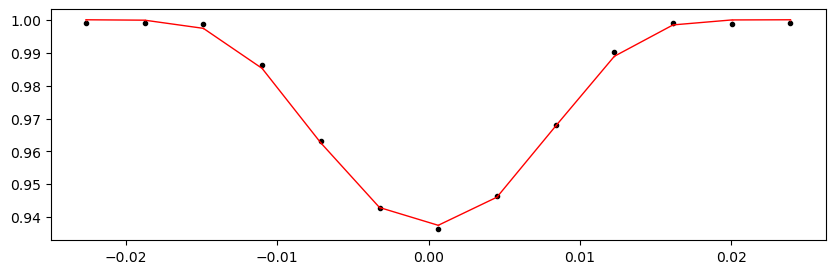

55532.975849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.31it/s]


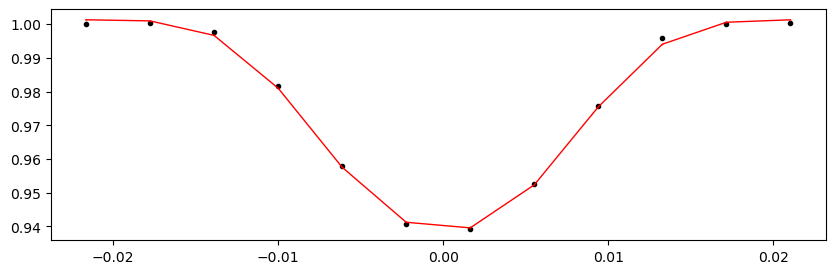

55538.242249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.09it/s]


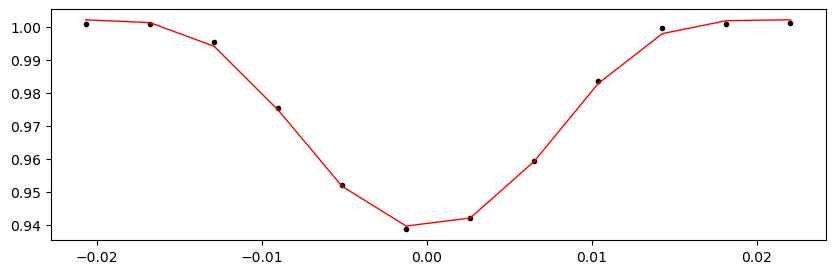

Time 55543.508648999996 does not have enough data points: 2
55548.775048999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.15it/s]


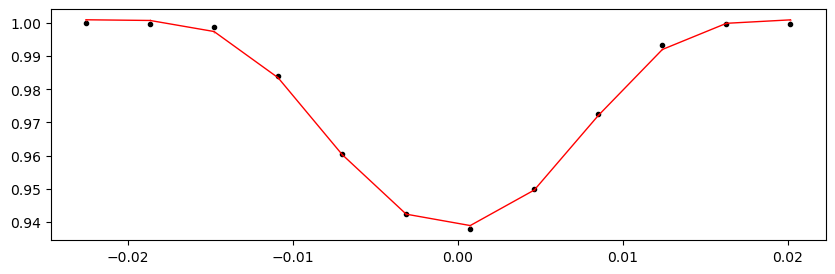

55569.840649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.06it/s]


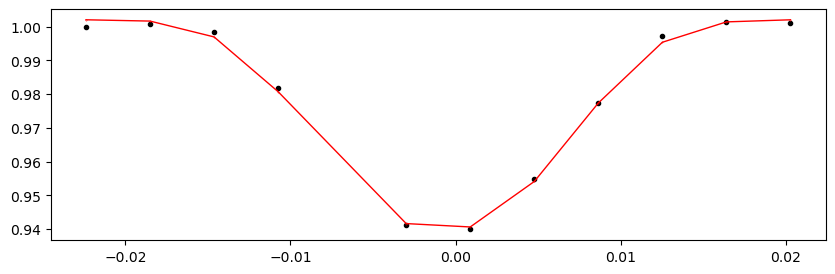

55575.107049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.11it/s]


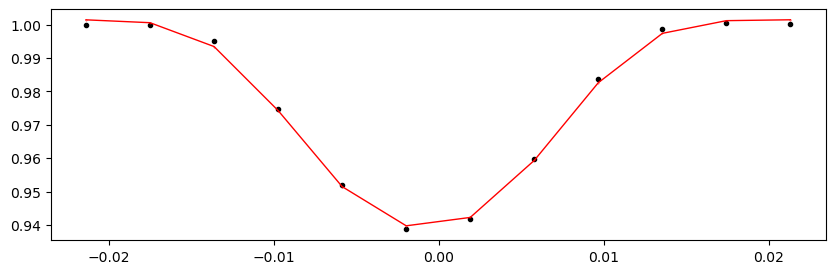

55580.373449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.50it/s]


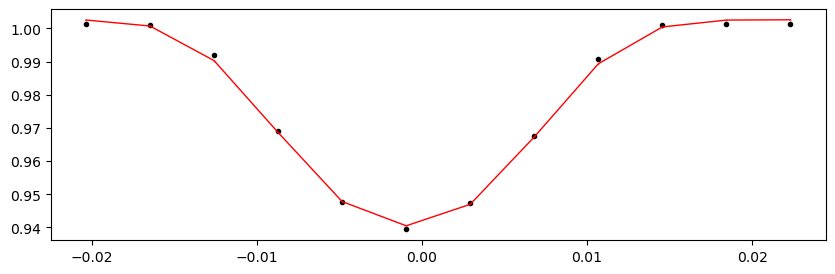

55585.639849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.42it/s]


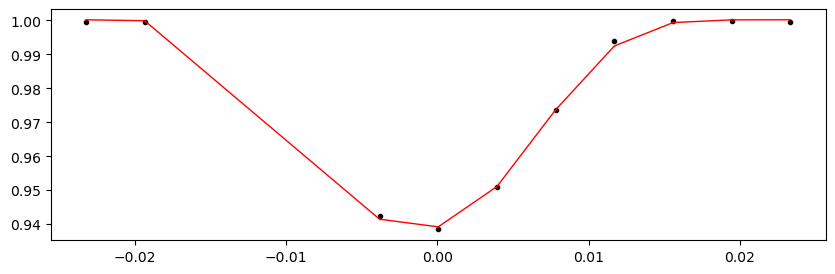

55590.906249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.59it/s]


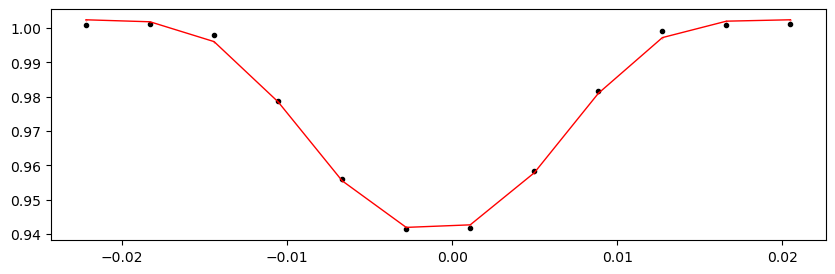

Time 55596.172649 does not have enough data points: 2
55601.439049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.40it/s]


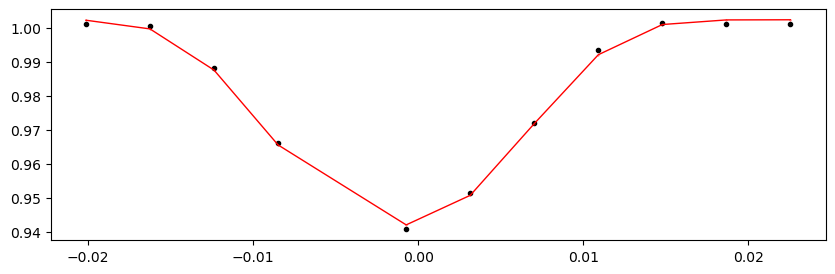

55606.705449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.92it/s]


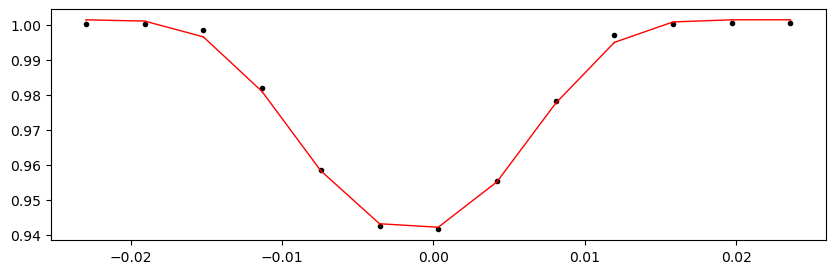

55611.971849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.42it/s]


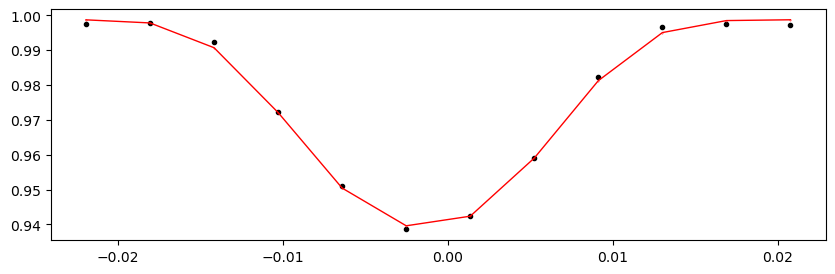

55617.238249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.03it/s]


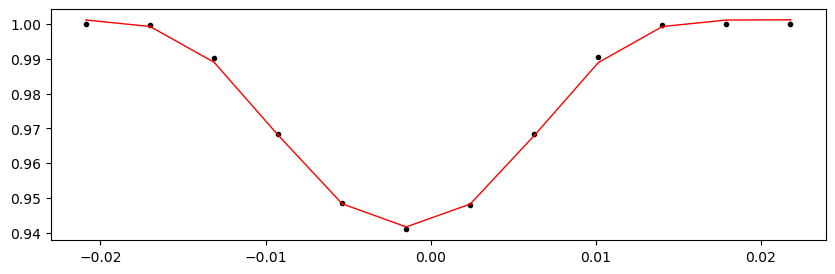

55622.504649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.51it/s]


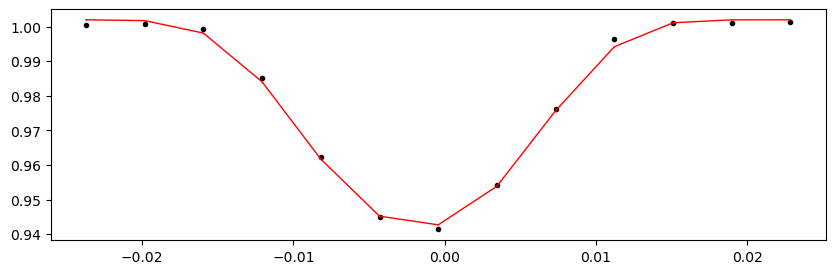

55627.771049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.32it/s]


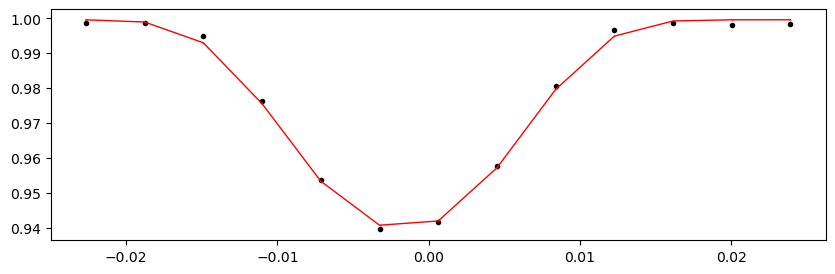

55633.037448999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.69it/s]


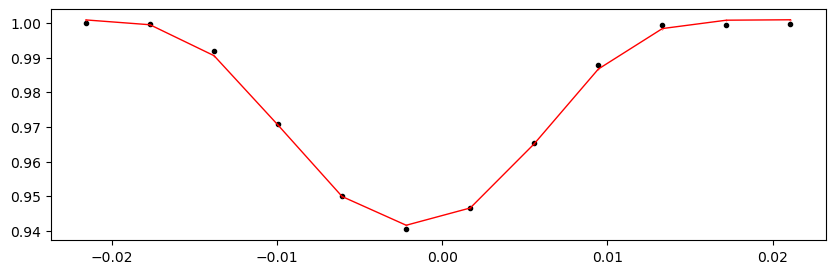

55643.570249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.03it/s]


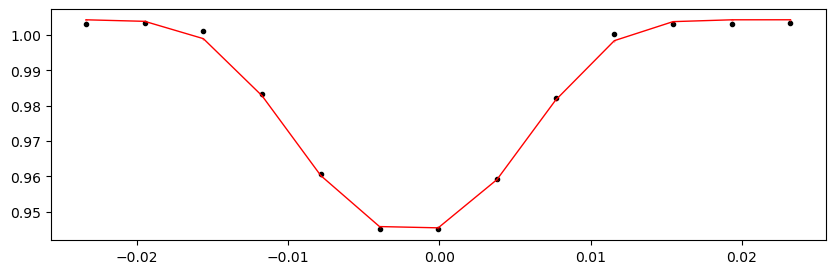

55648.836649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.93it/s]


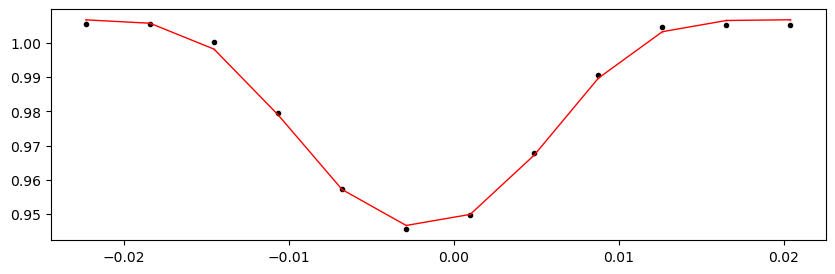

55654.103049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.10it/s]


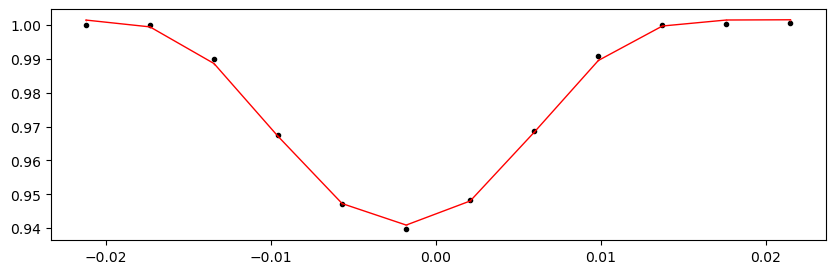

55659.369449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.81it/s]


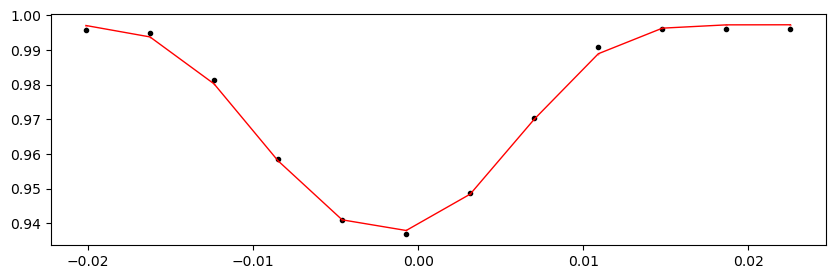

55664.635849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.45it/s]


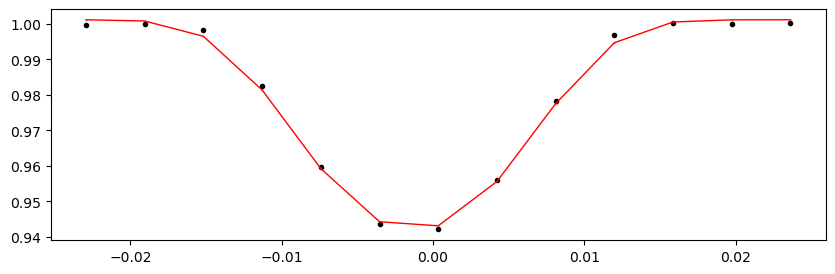

55669.902249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.57it/s]


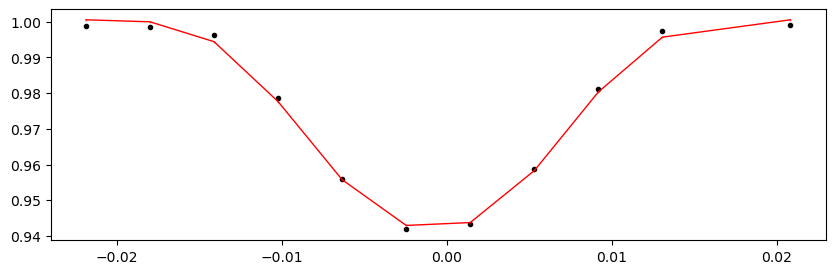

55675.168649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.06it/s]


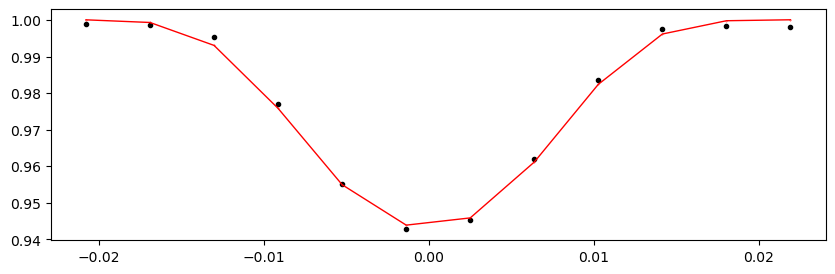

55680.435049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.71it/s]


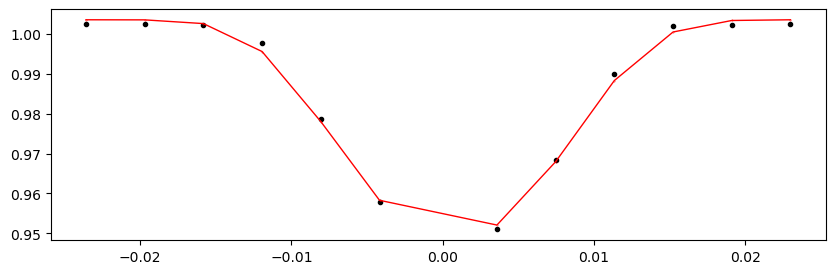

55685.701449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.62it/s]


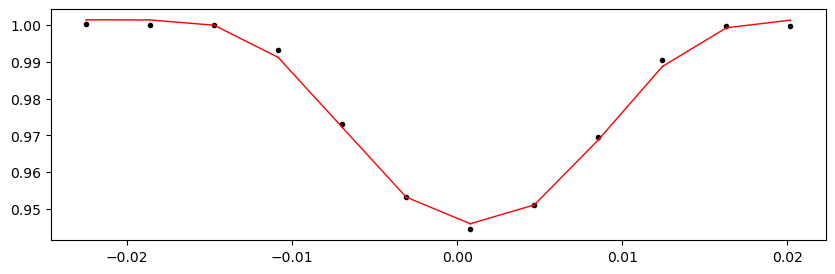

55690.967849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.88it/s]


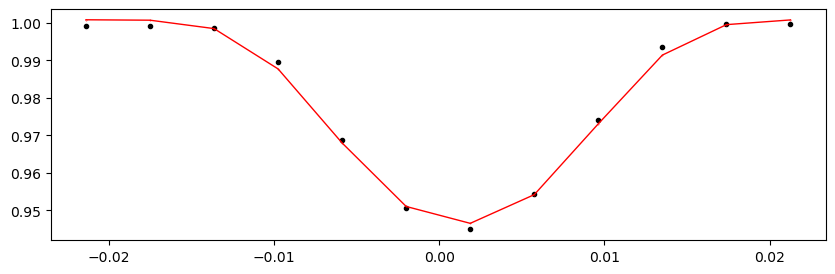

55696.234249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.46it/s]


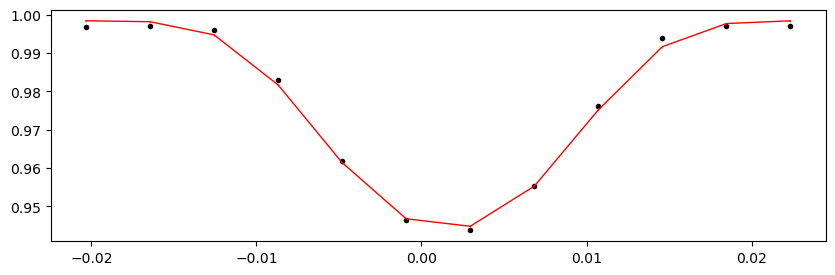

55701.500649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.98it/s]


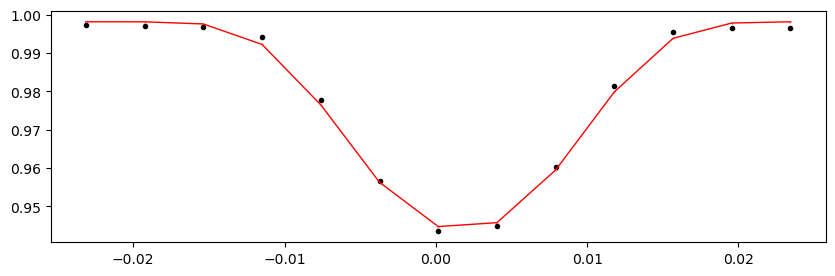

55712.033449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.15it/s]


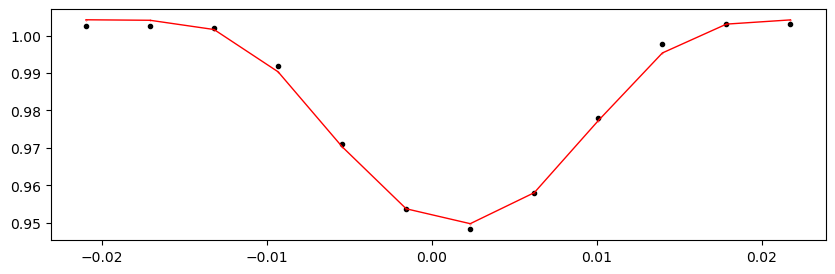

55717.299849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.69it/s]


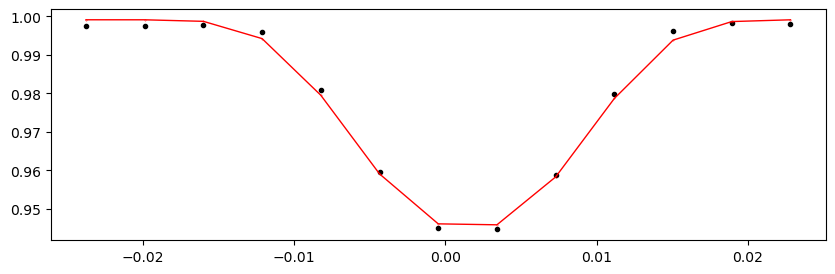

55722.566248999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.31it/s]


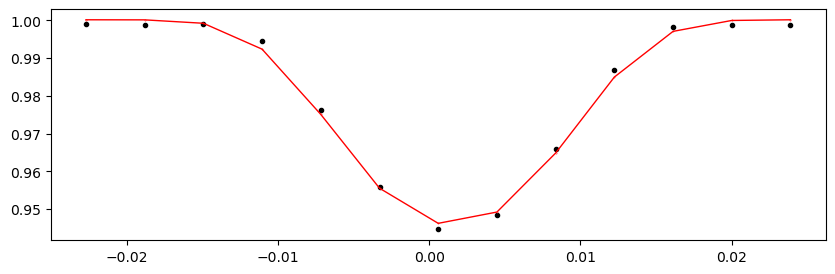

55727.832648999996 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.59it/s]


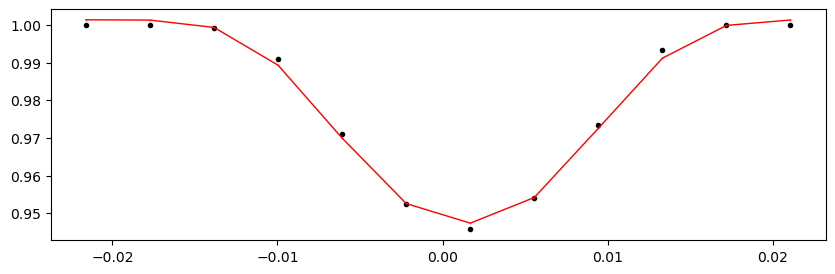

55733.099049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.11it/s]


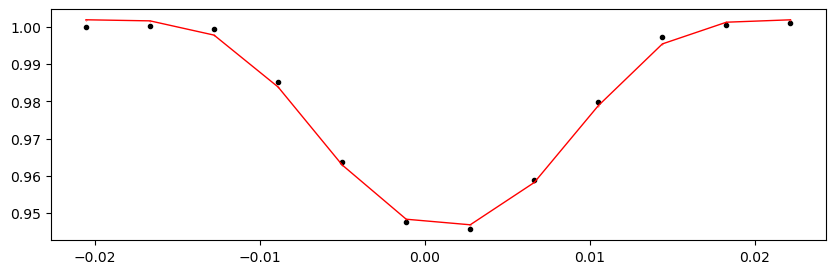

55738.365449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.58it/s]


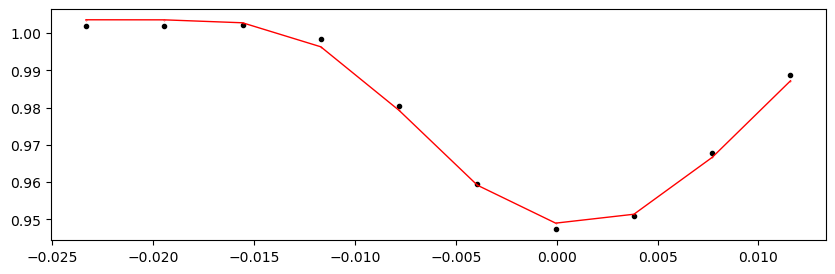

55743.631849 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.46it/s]


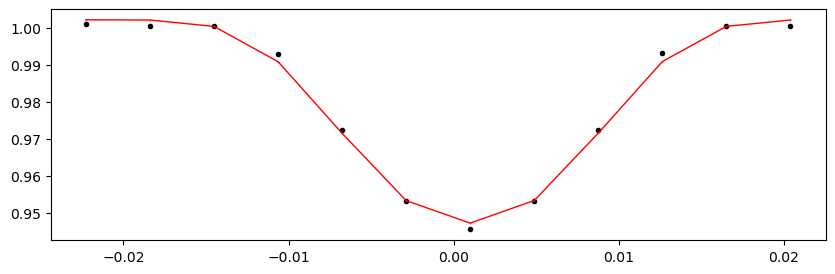

55748.898249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.78it/s]


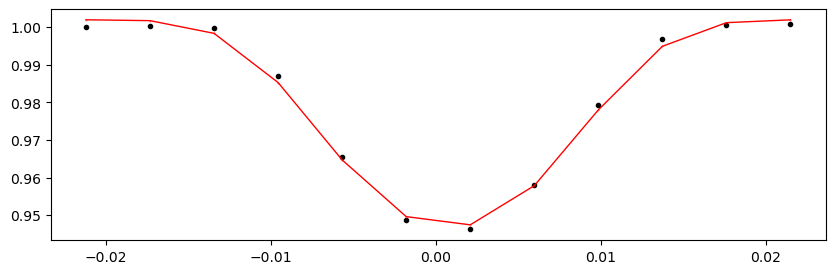

55754.164649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.11it/s]


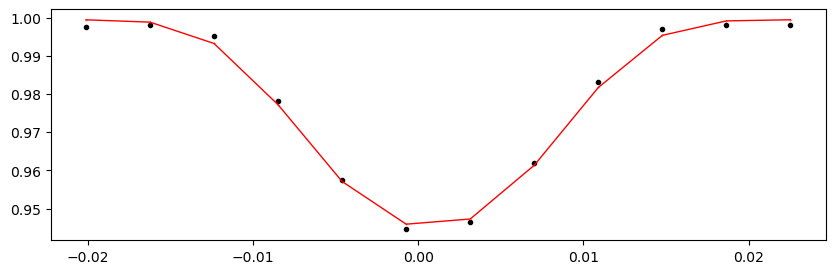

55759.431049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.80it/s]


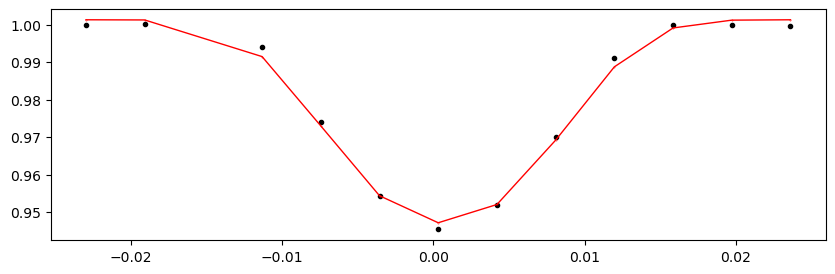

55764.697449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.93it/s]


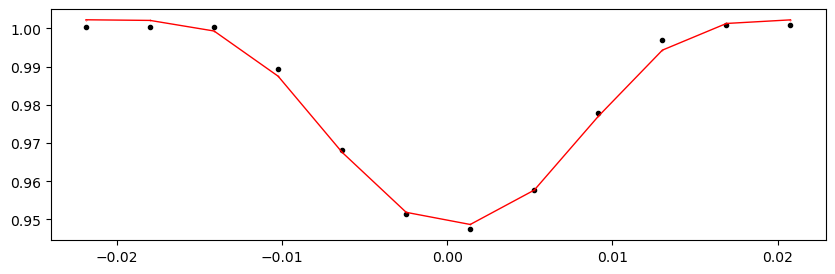

55775.230249 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.54it/s]


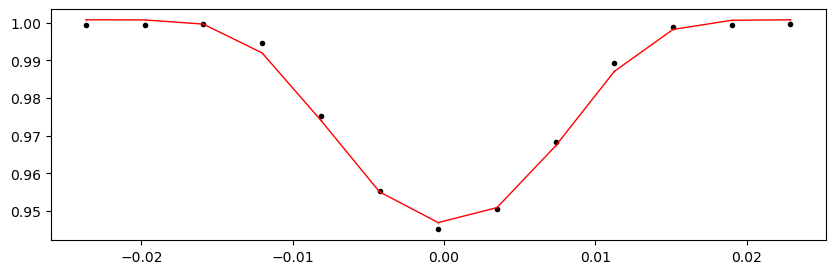

55780.496649 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.75it/s]


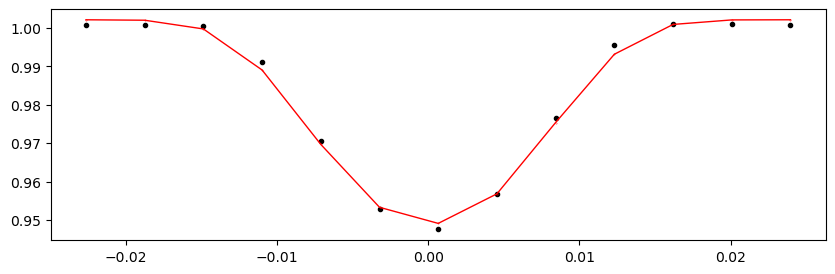

55785.763049 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.25it/s]


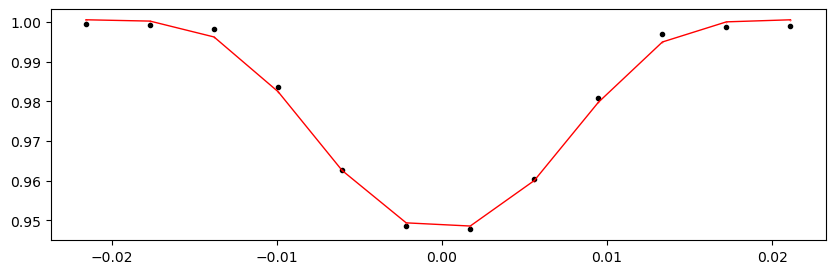

55791.029449 1.0003366710849937 -0.06855468349996802 -0.23049745550050382


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.27it/s]


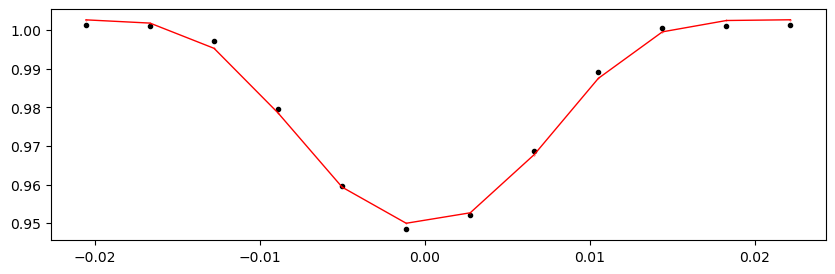

Fitting individual secondary eclipses...
Creating new manifest file
54966.739649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.55it/s]


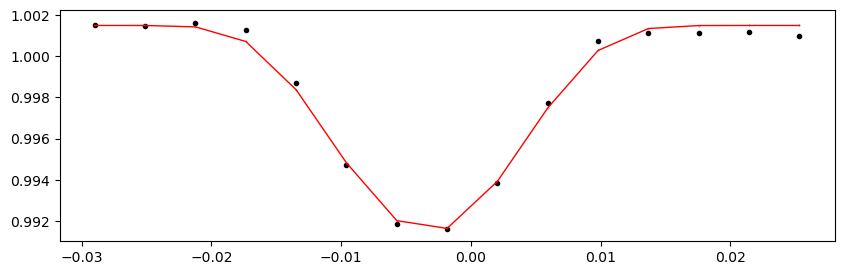

54972.006049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.73it/s]


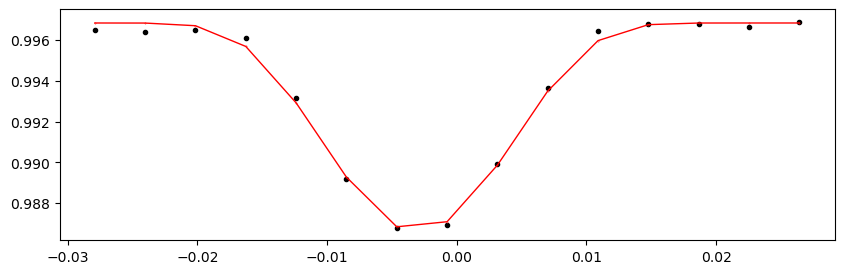

54977.272449000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.79it/s]


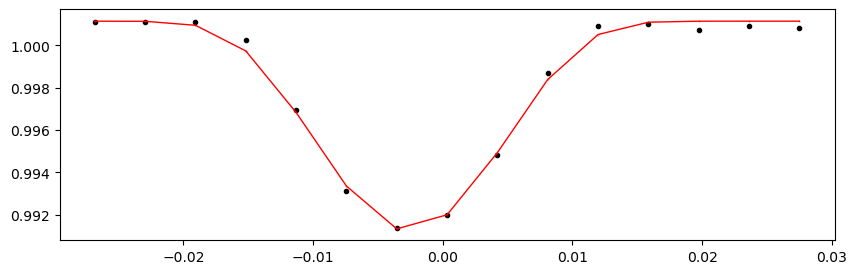

54982.538849000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.08it/s]


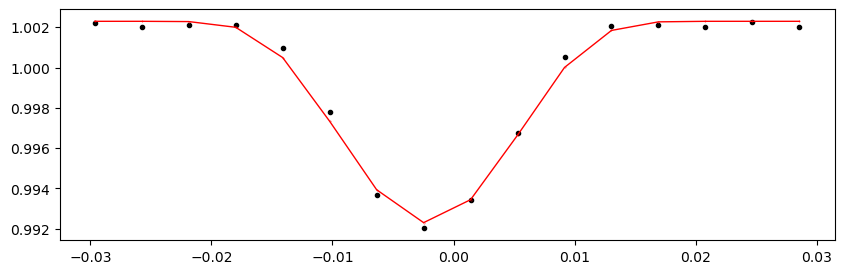

54987.805249000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.61it/s]


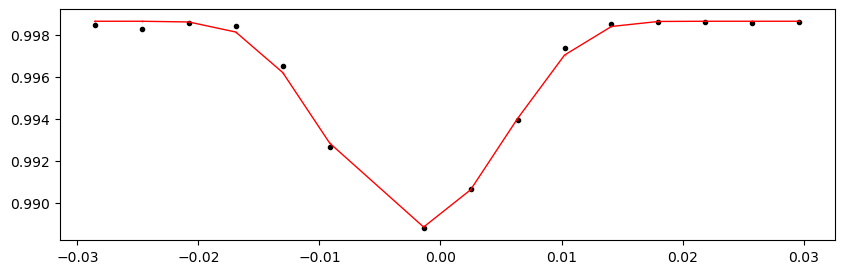

54993.071649000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.43it/s]


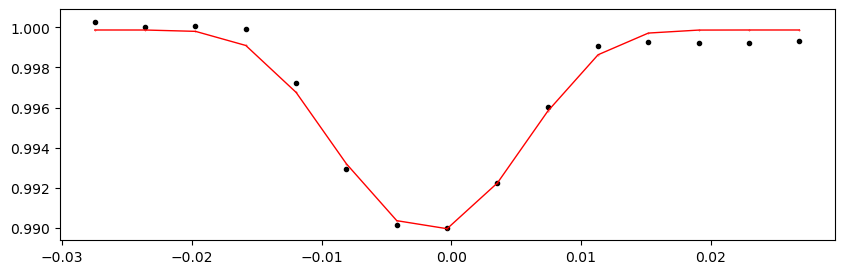

55003.604449000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.99it/s]


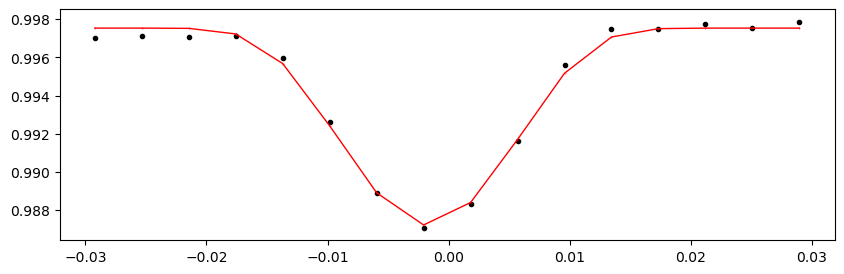

55008.870849000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.48it/s]


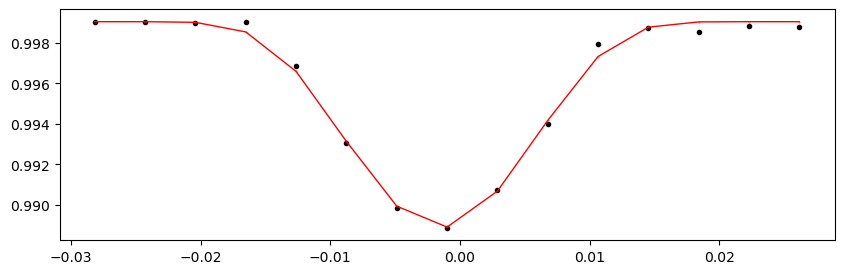

Time 55014.137249 does not have enough data points: 2
55019.403649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.52it/s]


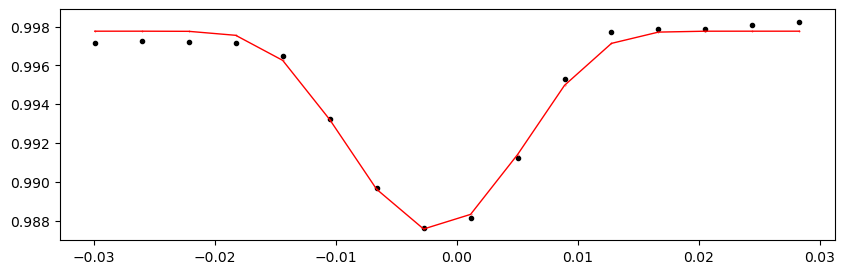

55024.670049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.86it/s]


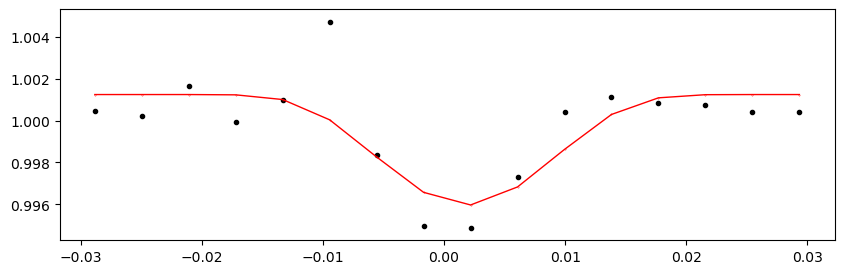

55029.936449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.77it/s]


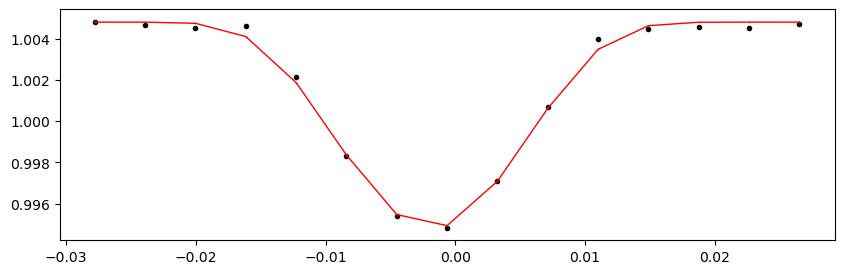

55035.202849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.31it/s]


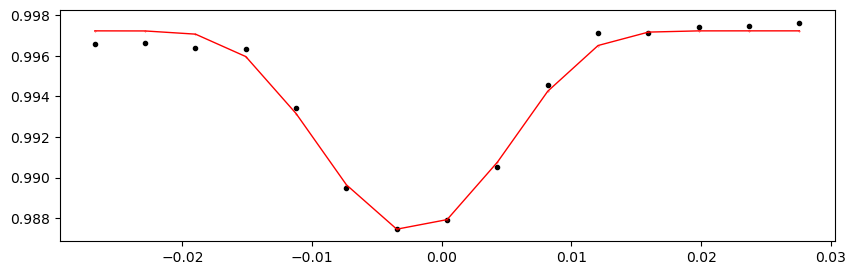

55040.469249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.38it/s]


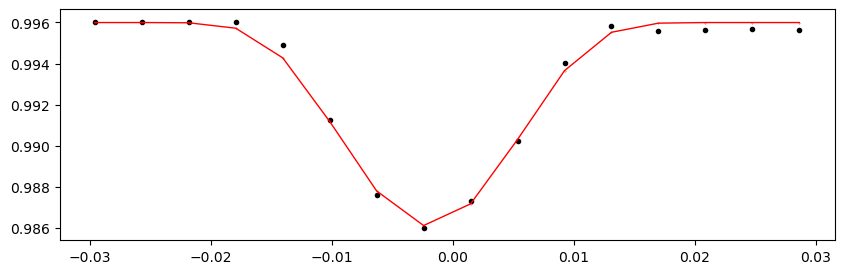

55045.735649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.07it/s]


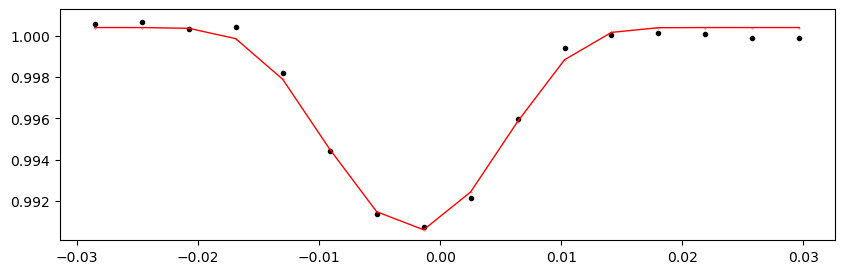

55051.002049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.72it/s]


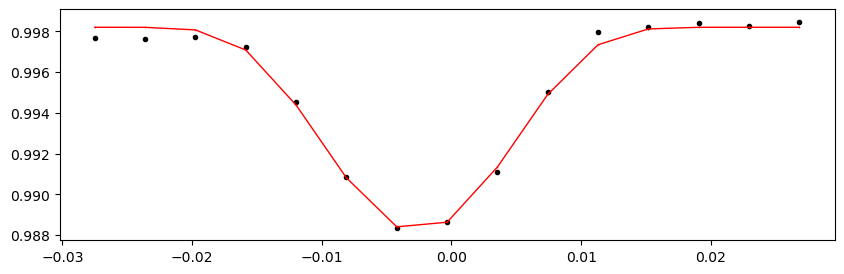

Time 55056.268449 does not have enough data points: 3
55061.534849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.01it/s]


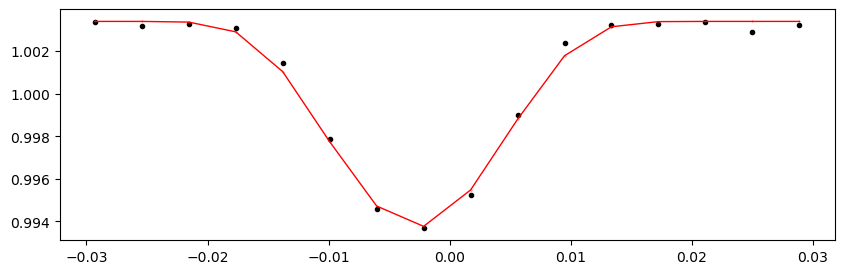

55066.801249000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.21it/s]


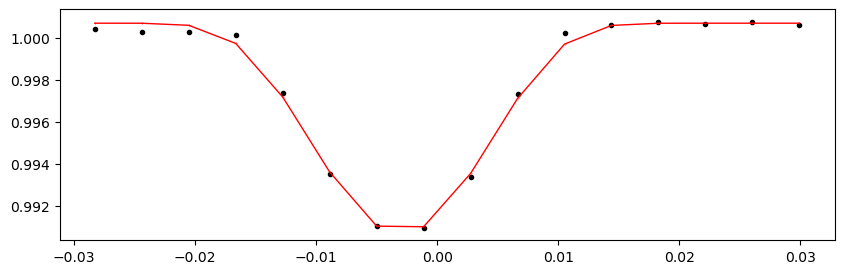

55072.067649000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.03it/s]


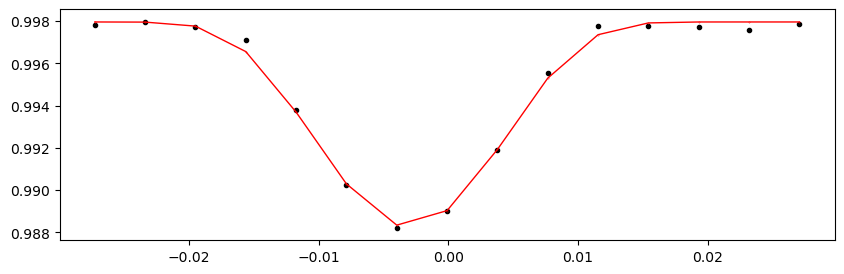

55077.334049000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.03it/s]


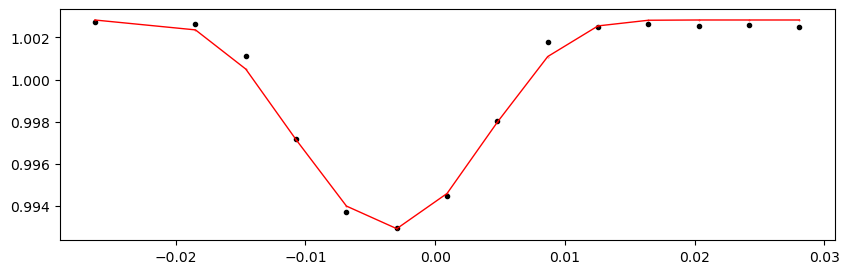

55082.600449000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.03it/s]


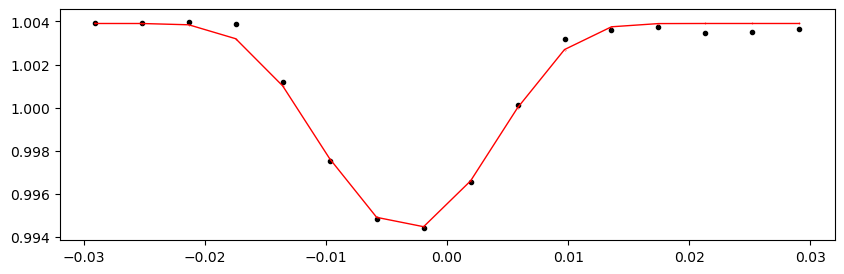

Time 55087.866849000005 does not have enough data points: 9
55093.133249000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.52it/s]


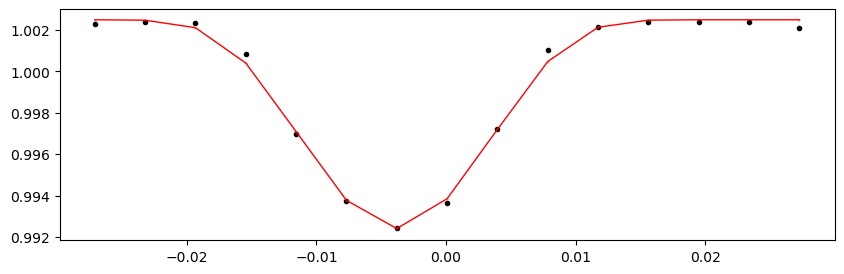

55098.399649000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.52it/s]


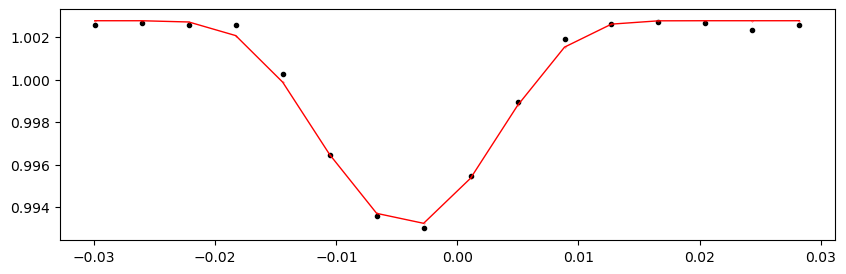

55103.666049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.79it/s]


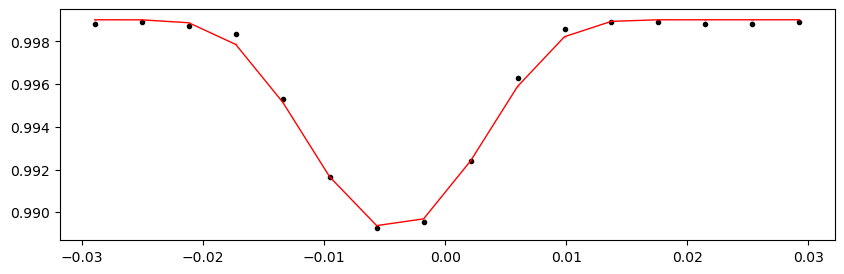

55108.932449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.11it/s]


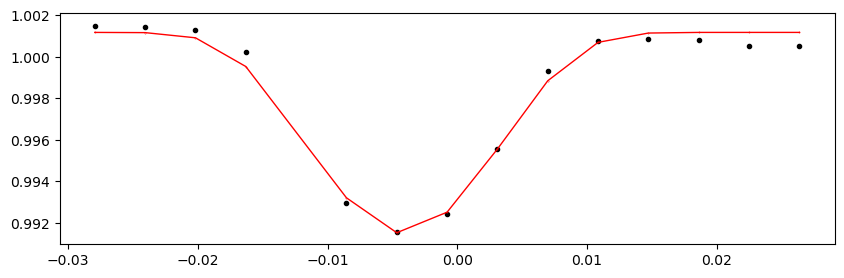

55114.198849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.76it/s]


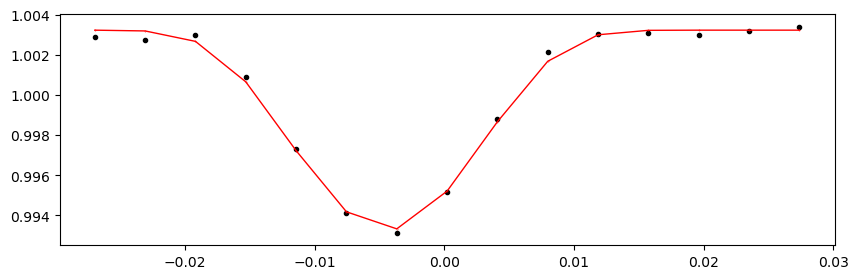

55119.465249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.35it/s]


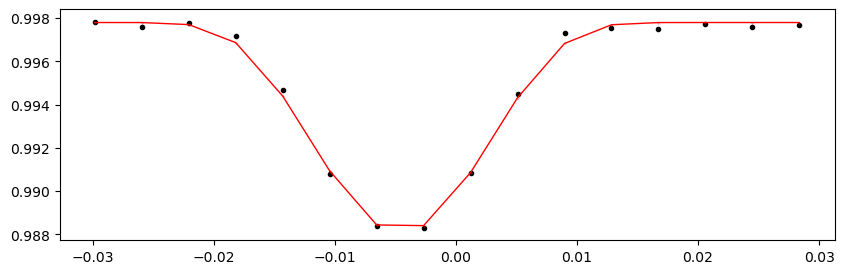

55124.731649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.79it/s]


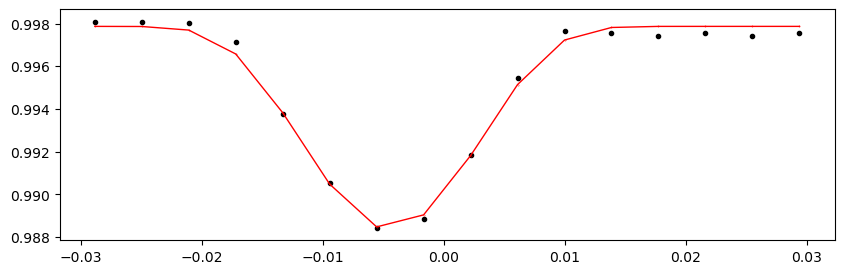

55129.998049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.08it/s]


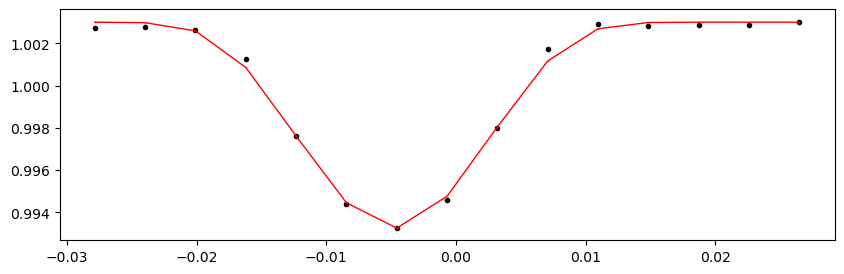

55135.264449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.50it/s]


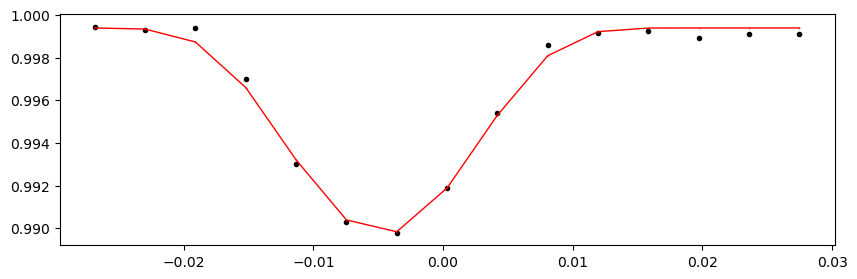

55140.530849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.94it/s]


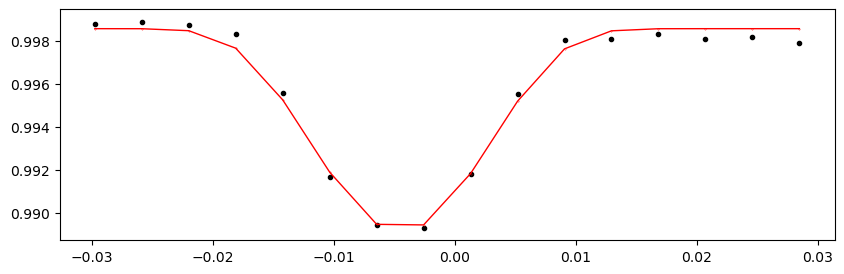

55145.797249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.94it/s]


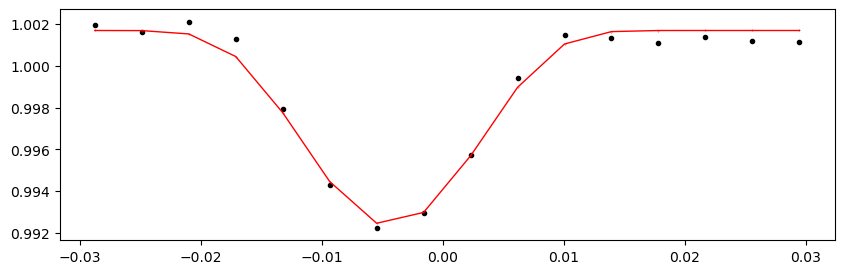

55151.063649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.69it/s]


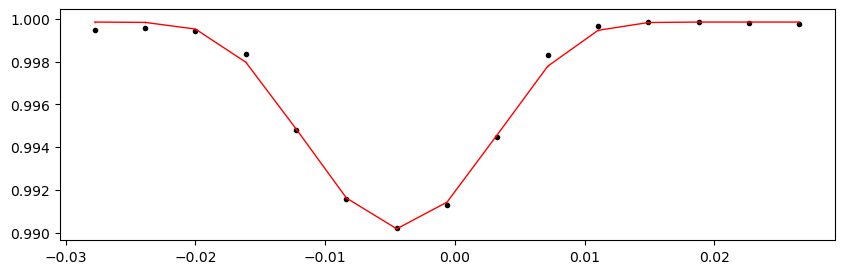

55156.330049000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.70it/s]


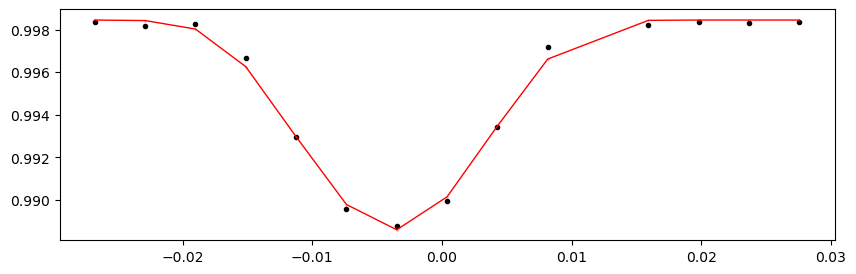

55161.596449000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.15it/s]


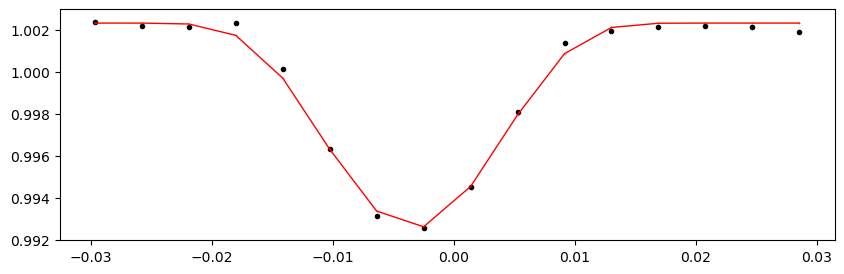

55166.862849000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.57it/s]


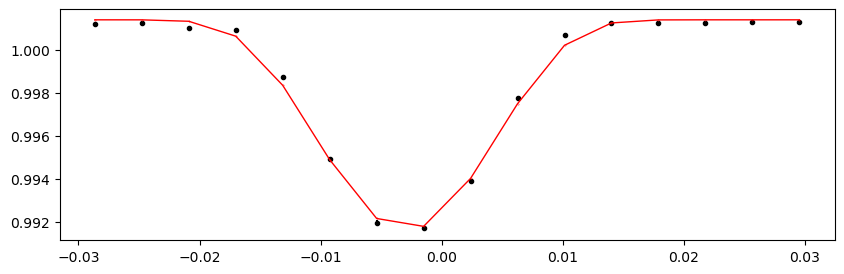

55172.129249000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.66it/s]


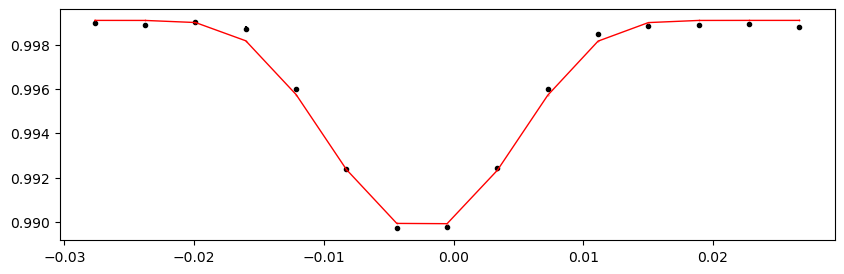

55177.395649000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.43it/s]


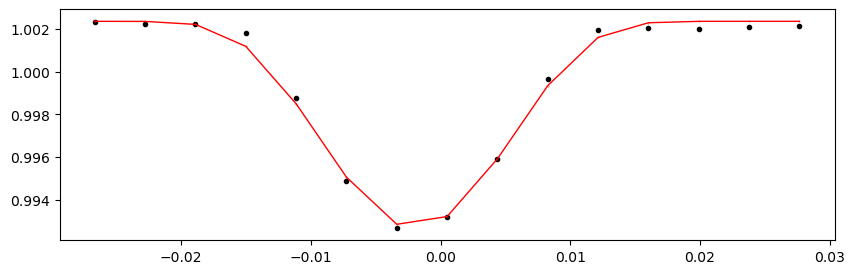

55187.92844900001 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.78it/s]


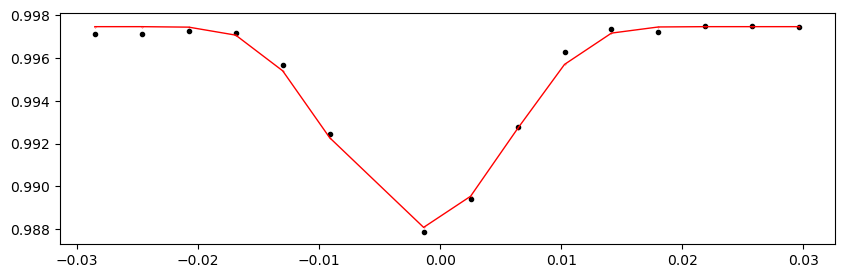

55193.194849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.16it/s]


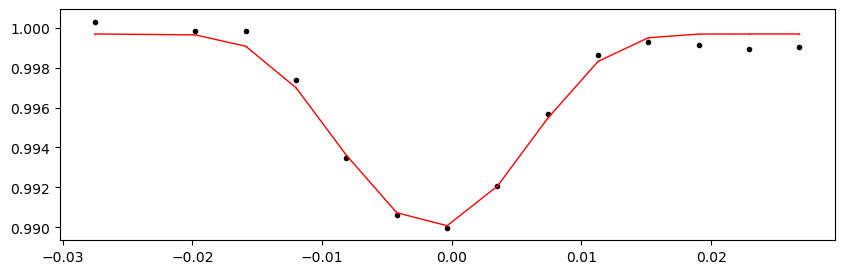

55198.461249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.61it/s]


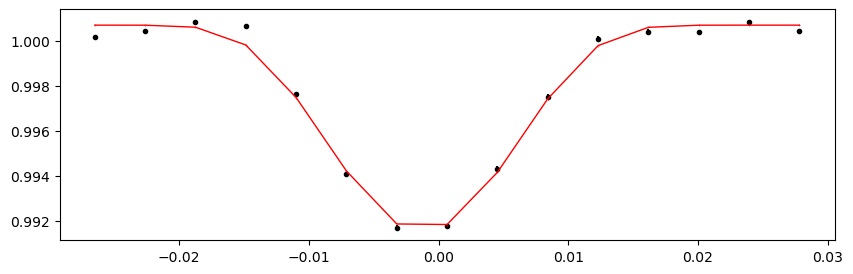

55203.727649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.70it/s]


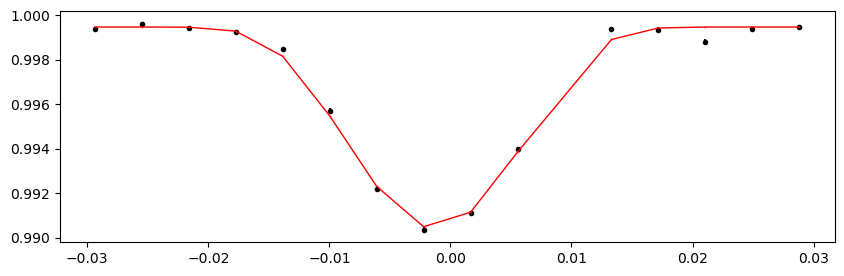

55208.994049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.02it/s]


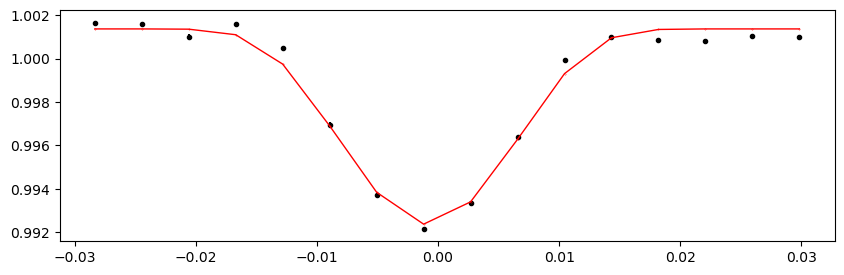

55214.260449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.19it/s]


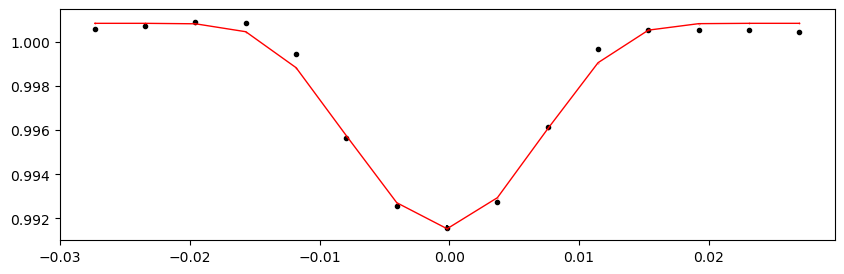

55219.526849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.85it/s]


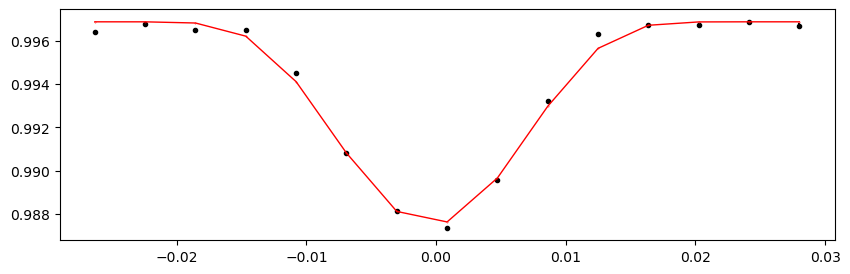

55224.793249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.72it/s]


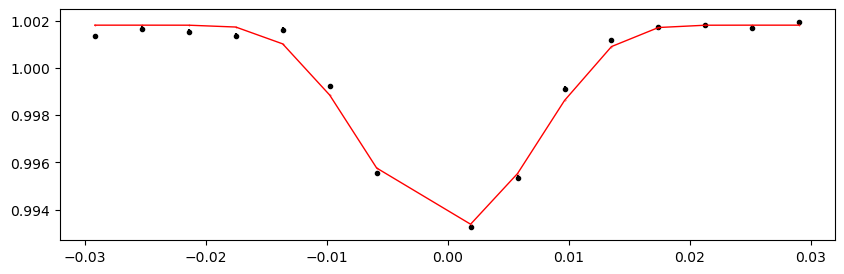

55235.326049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.21it/s]


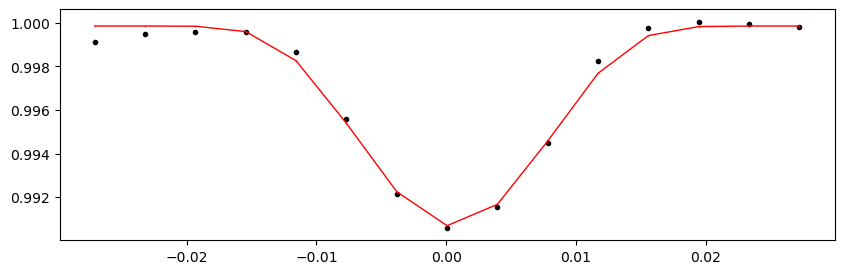

55240.592449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.38it/s]


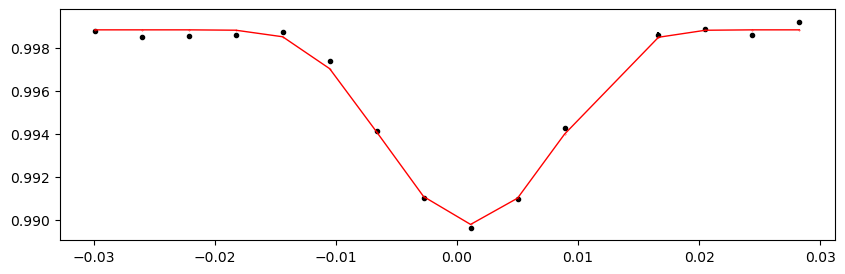

55245.858849000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.56it/s]


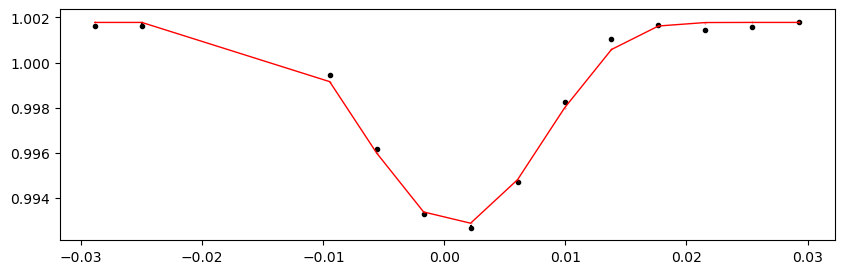

55251.125249000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.89it/s]


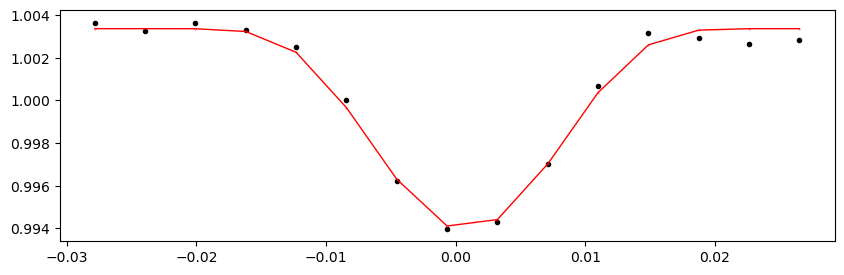

55256.391649000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.90it/s]


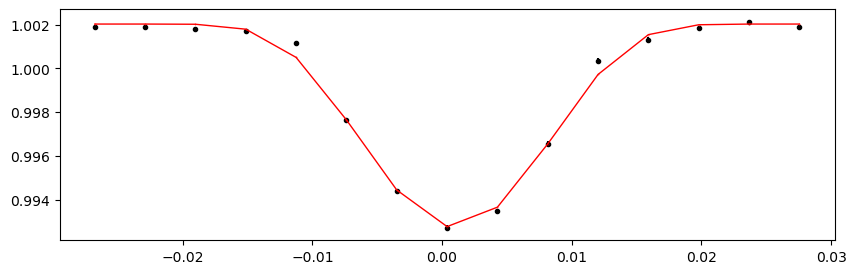

55261.658049000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.09it/s]


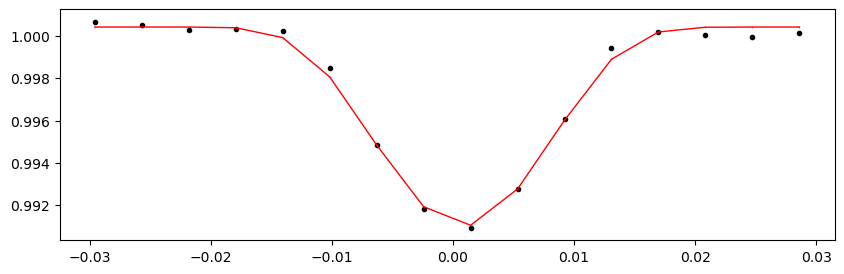

55266.924449000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.54it/s]


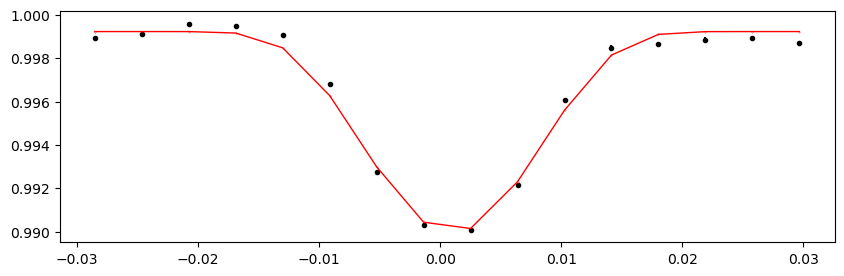

55272.190849000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.67it/s]


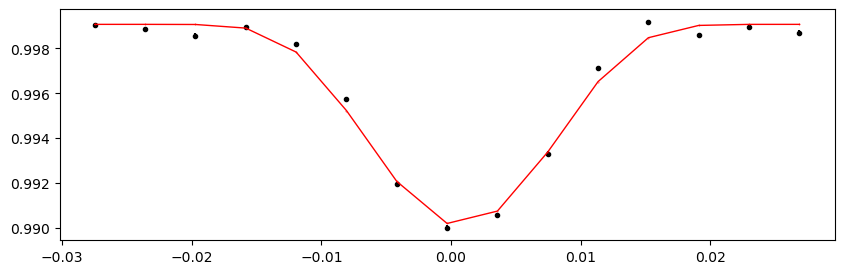

55277.45724900001 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.28it/s]


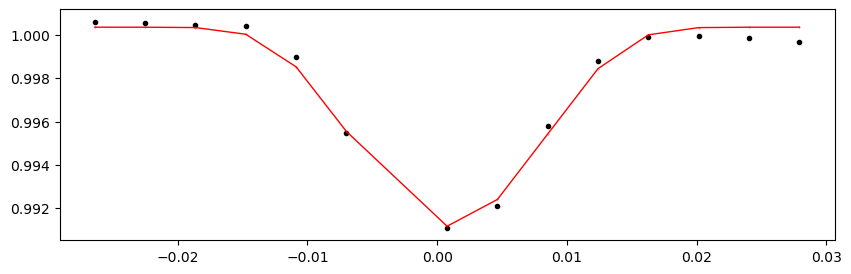

55282.723649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.84it/s]


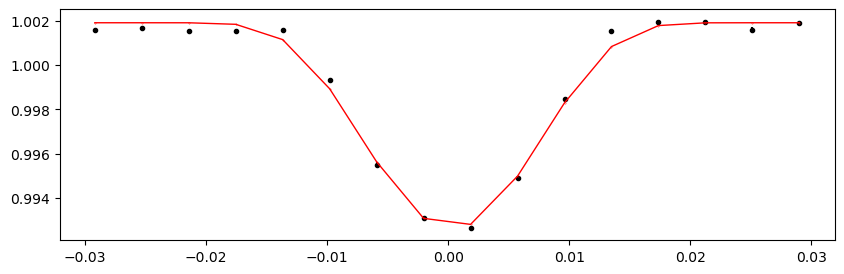

55287.990049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.15it/s]


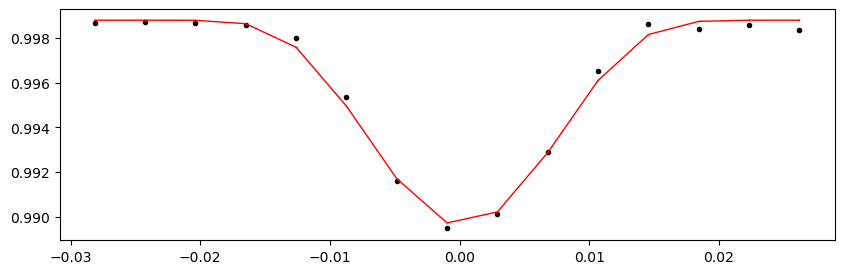

55293.256449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.76it/s]


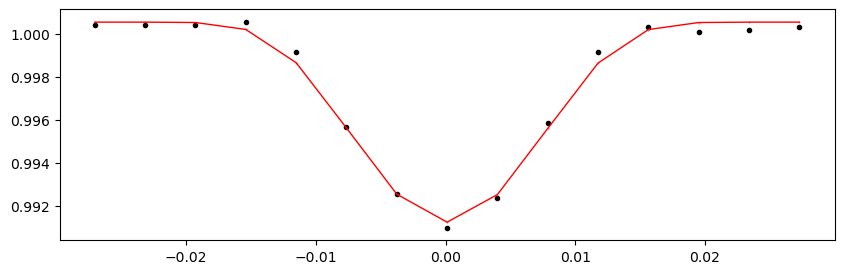

55298.522849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.51it/s]


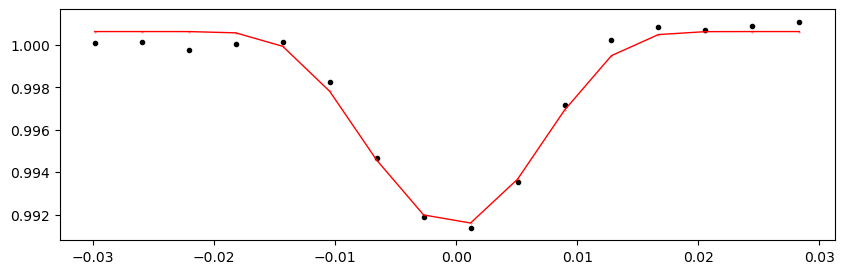

55303.789249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.49it/s]


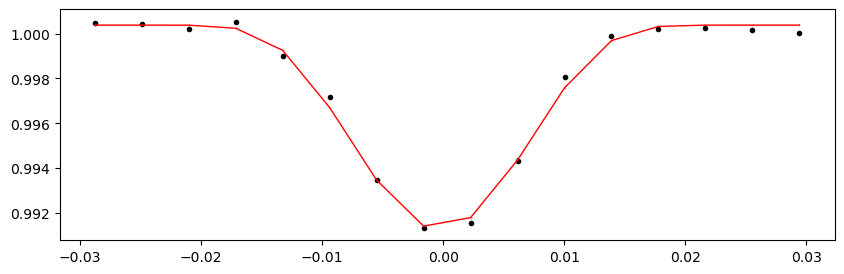

55309.055649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.83it/s]


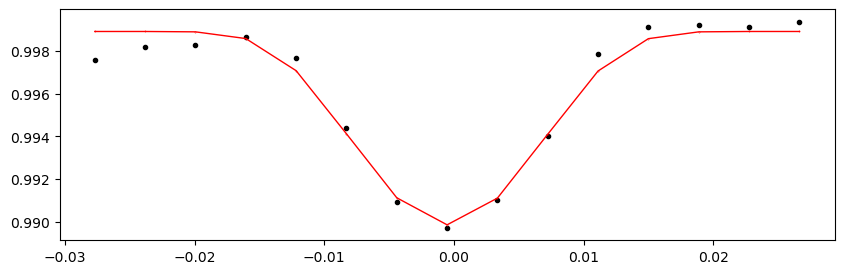

55314.322049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.16it/s]


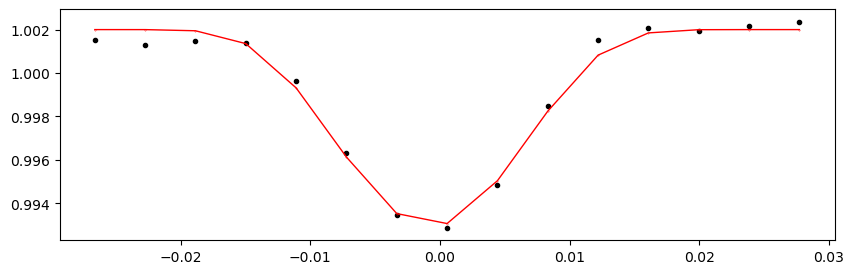

55319.588449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.23it/s]


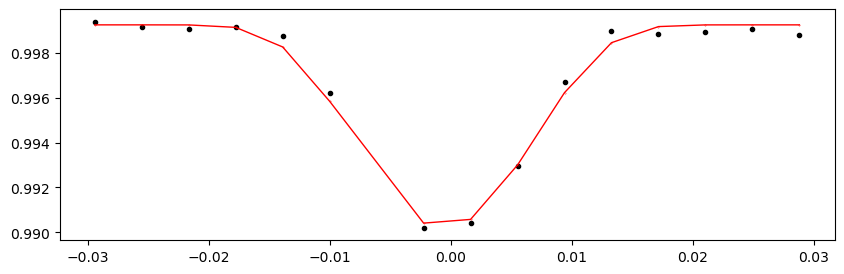

55324.854849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.02it/s]


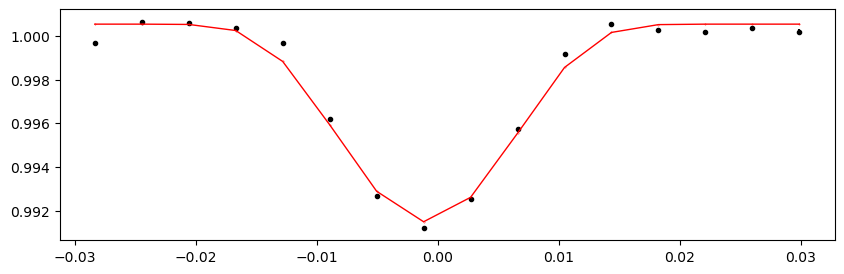

55330.121249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.70it/s]


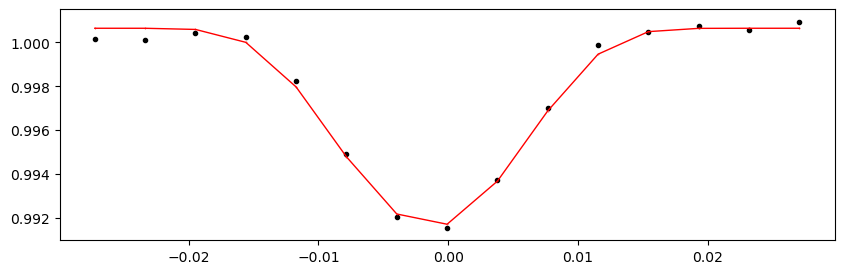

55335.387649000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.89it/s]


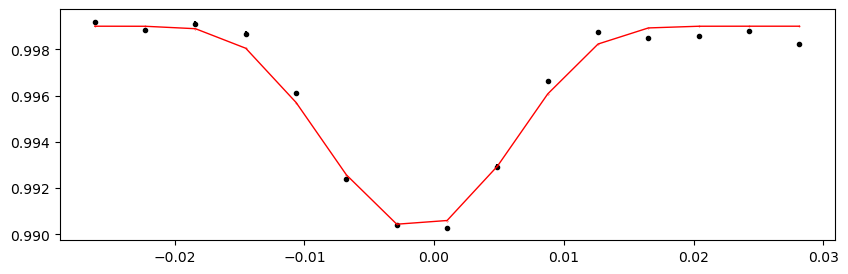

55340.654049000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.98it/s]


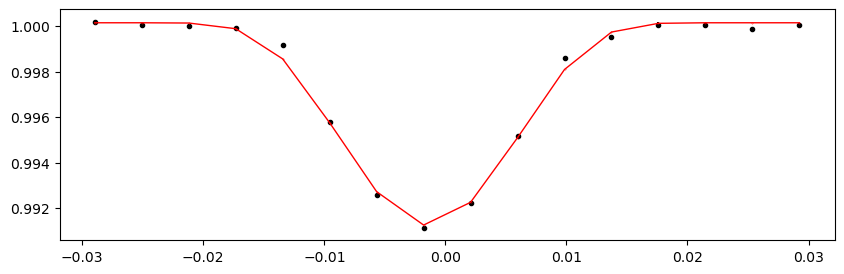

55345.920449000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.57it/s]


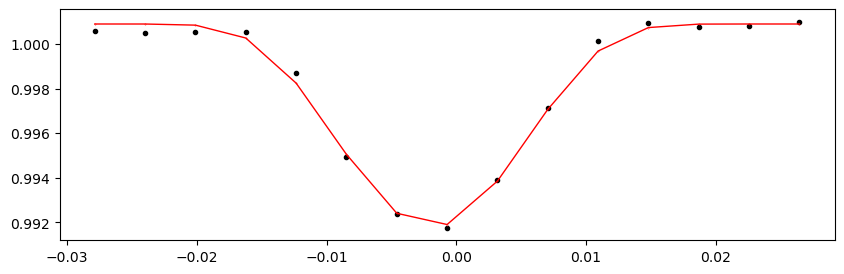

55351.186849000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.75it/s]


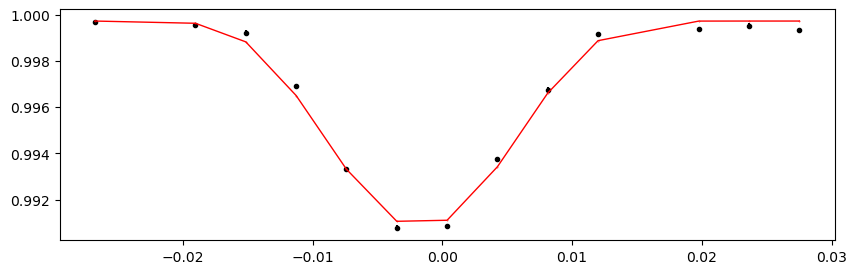

55356.453249000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.53it/s]


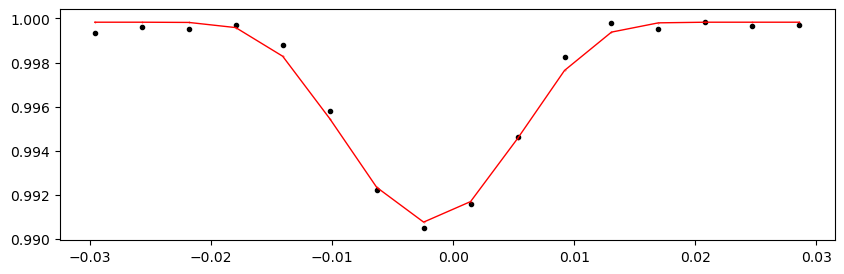

55361.719649000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.53it/s]


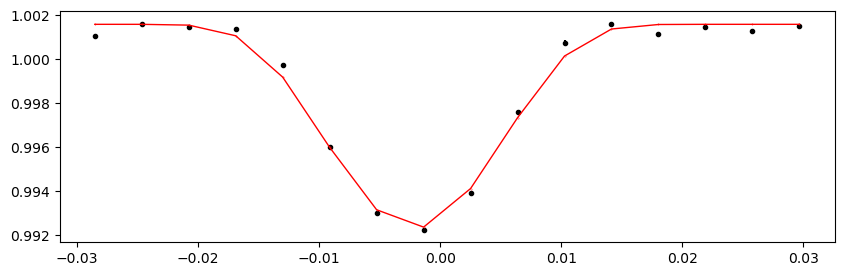

55366.986049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.05it/s]


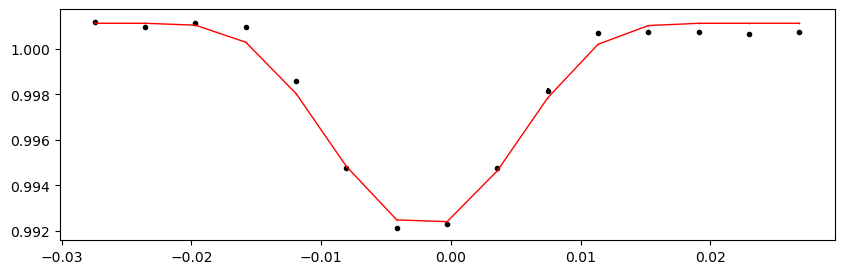

55372.252449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.72it/s]


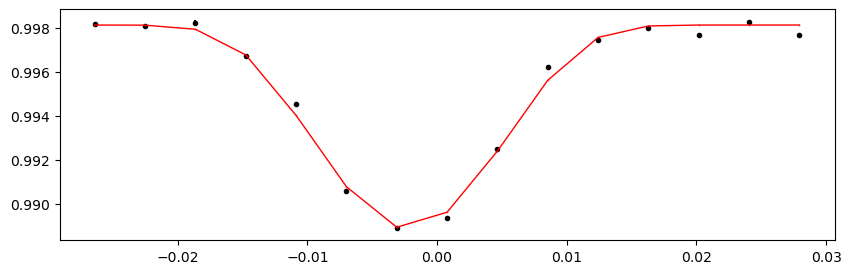

55377.518849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.41it/s]


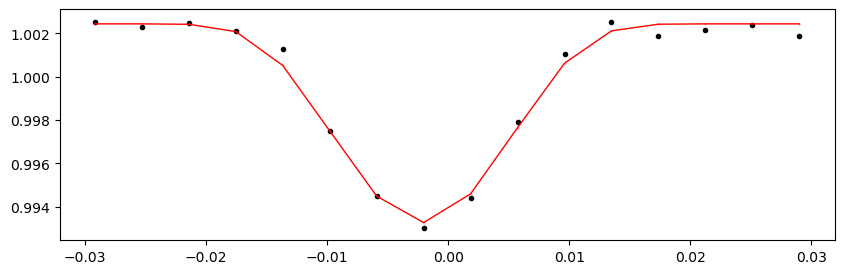

55382.785249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.41it/s]


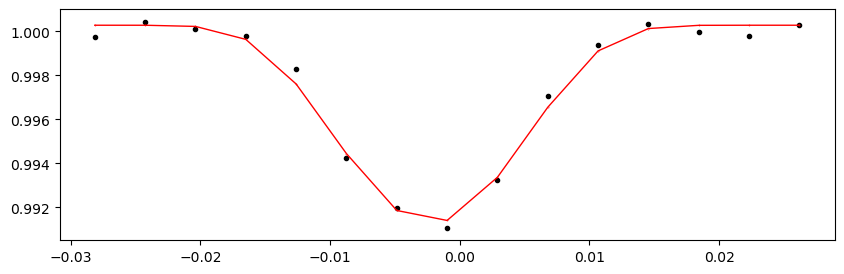

55388.051649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.12it/s]


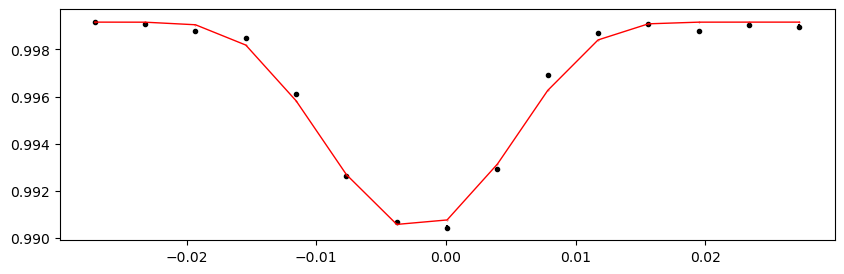

55393.318049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.63it/s]


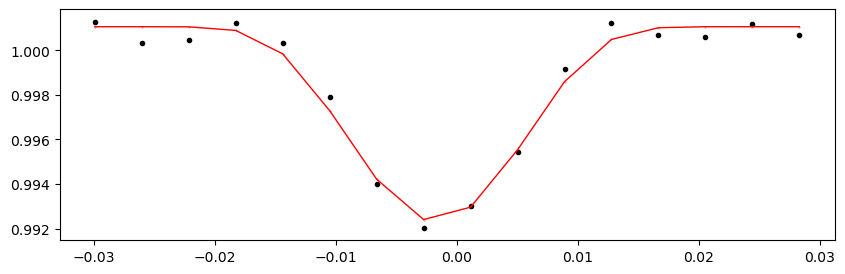

55398.584449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.31it/s]


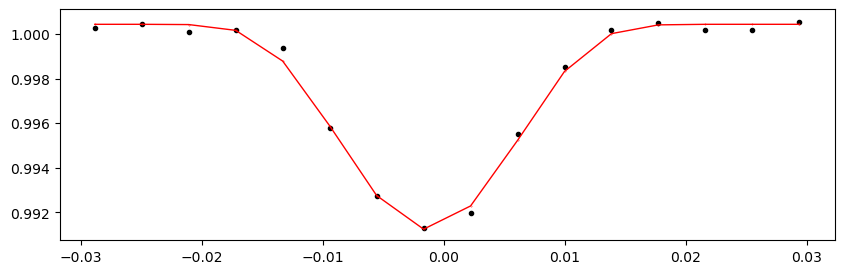

55403.850849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.14it/s]


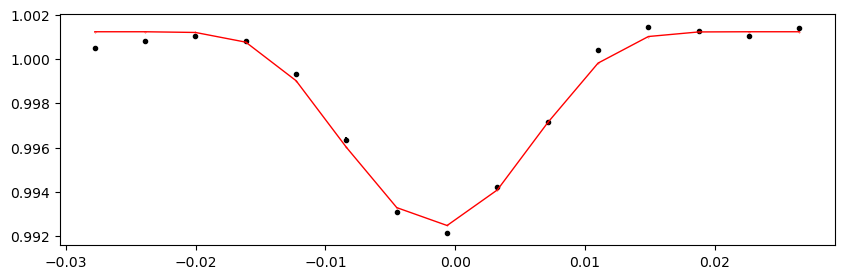

55409.117249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.67it/s]


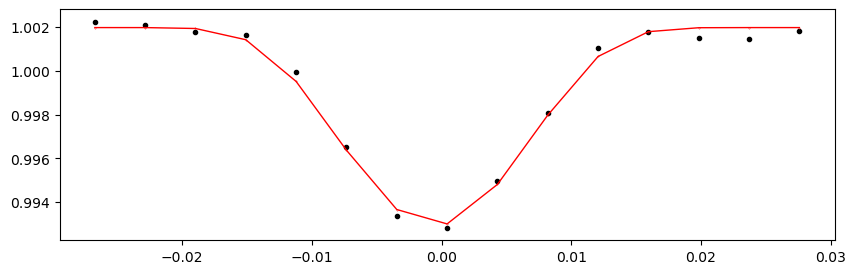

55414.383649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.93it/s]


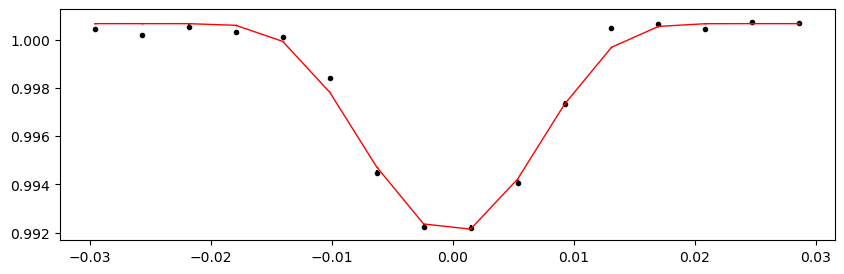

55419.650049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.52it/s]


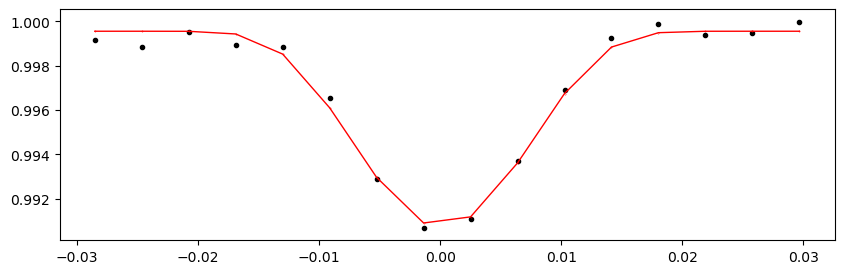

55424.916449000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.06it/s]


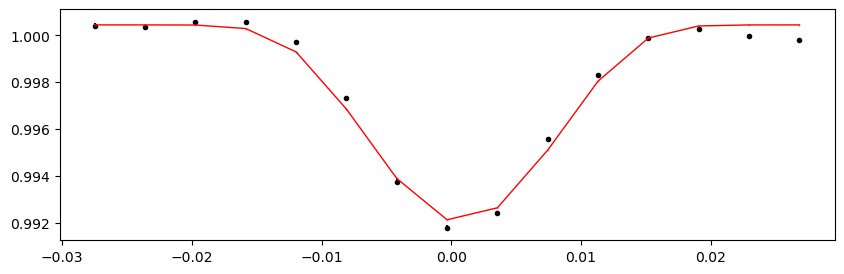

55430.182849000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.95it/s]


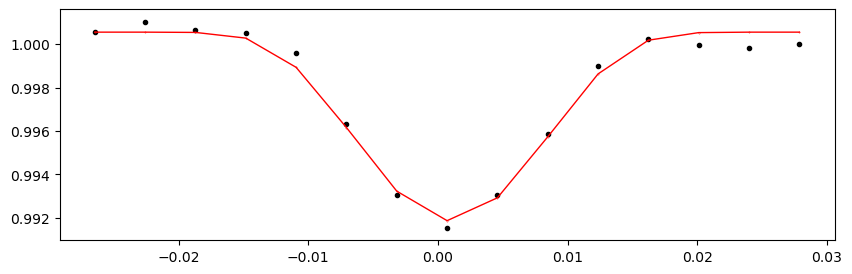

55435.449249000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.36it/s]


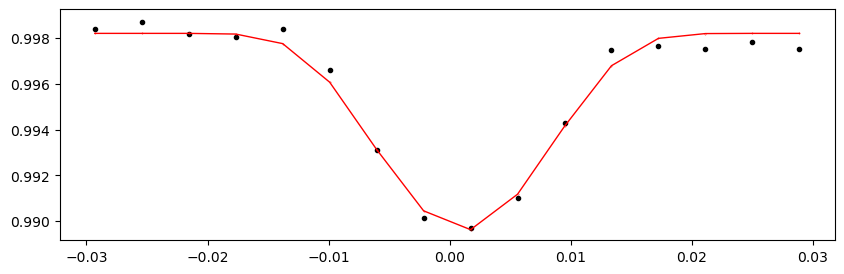

55440.715649000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.34it/s]


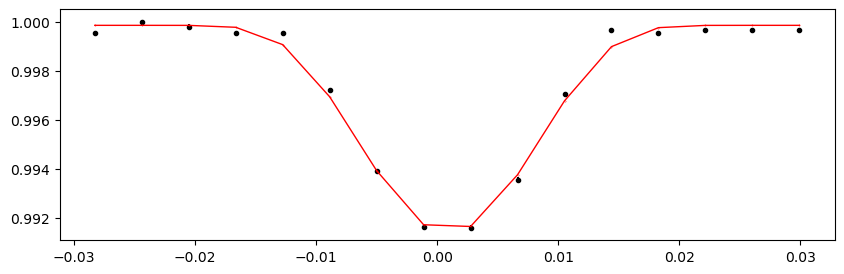

55445.982049000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.35it/s]


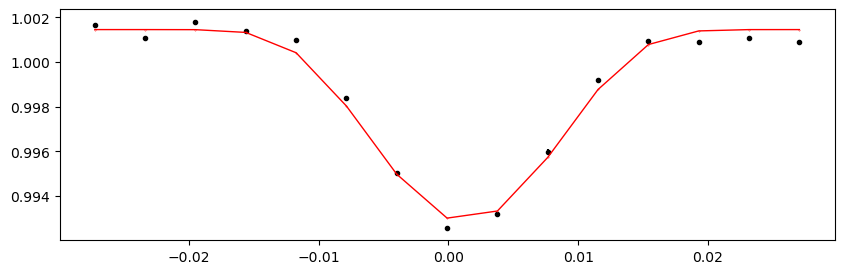

55451.248449000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.73it/s]


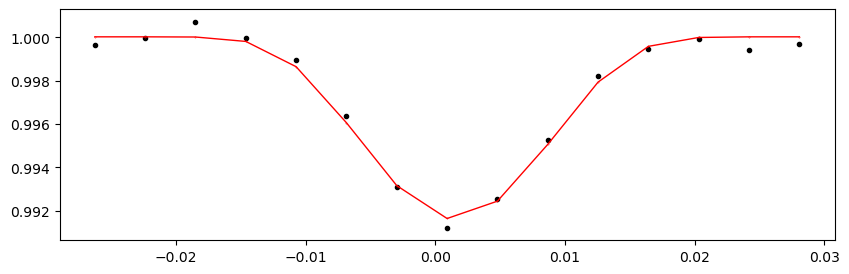

55456.514849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.98it/s]


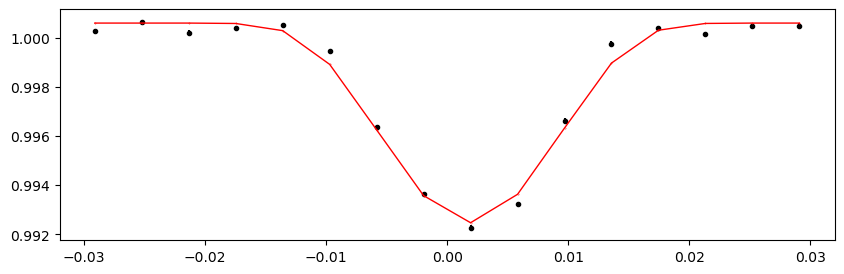

Time 55461.781249 does not have enough data points: 8
55467.047649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.17it/s]


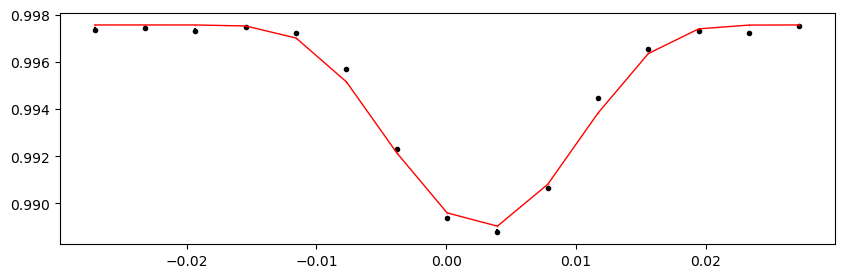

55472.314049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.61it/s]


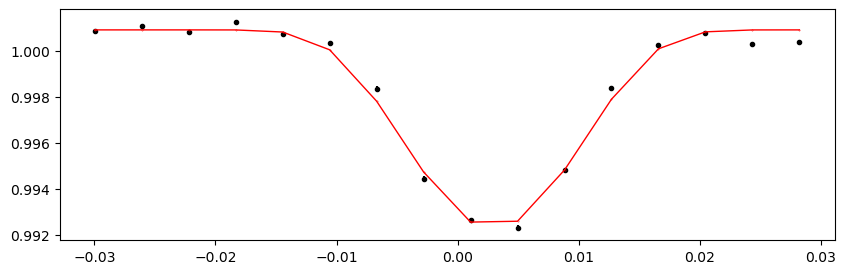

55477.580449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.98it/s]


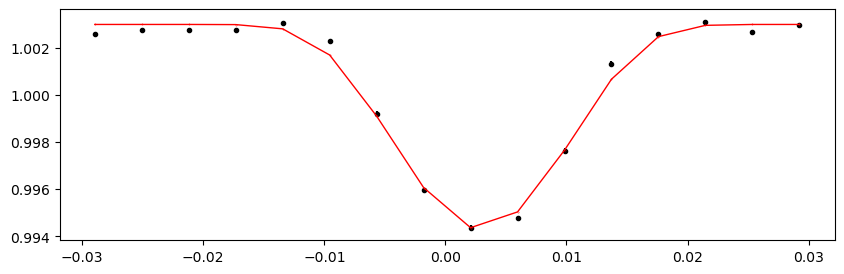

55482.846849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.12it/s]


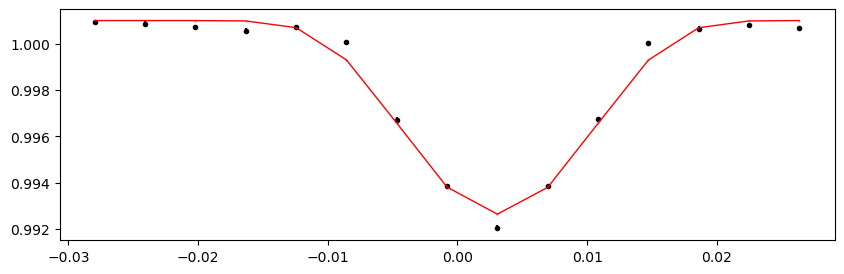

55488.113249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.63it/s]


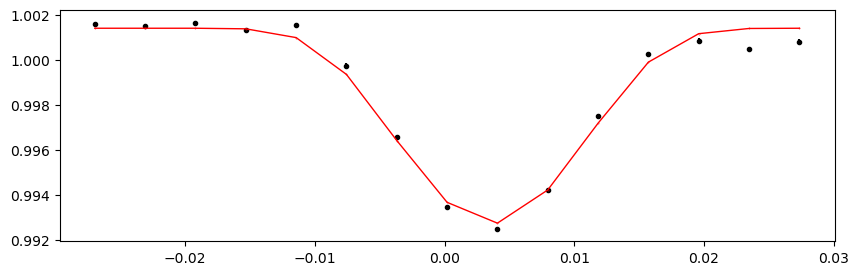

55498.646049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.44it/s]


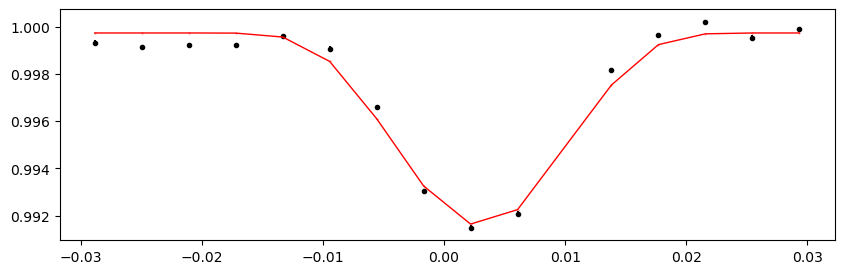

55503.912449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.25it/s]


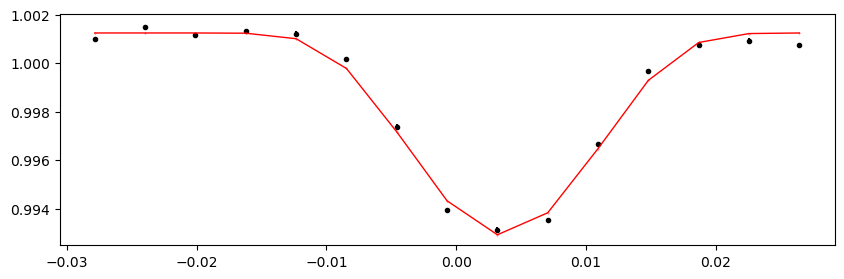

55509.178849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.24it/s]


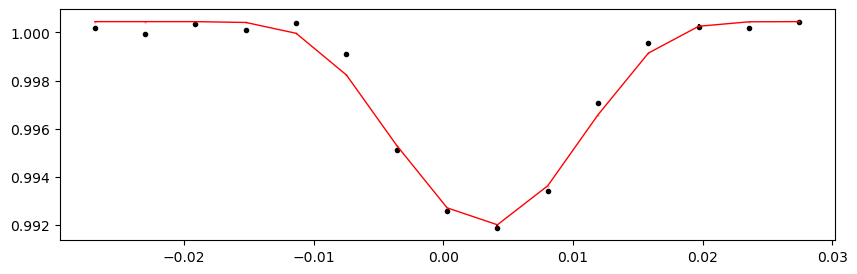

55514.445249000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.75it/s]


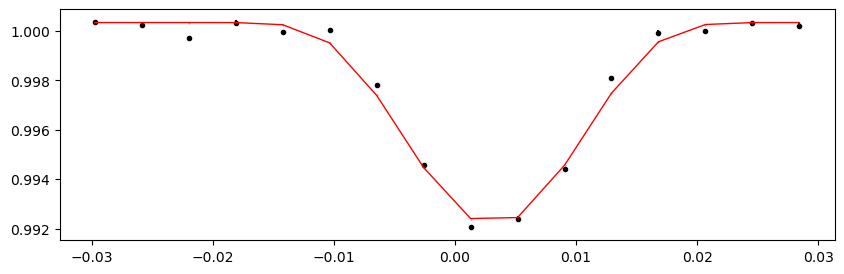

55519.711649000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.62it/s]


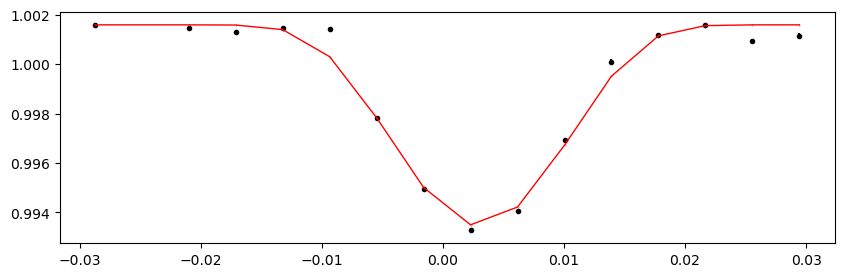

55524.978049000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.05it/s]


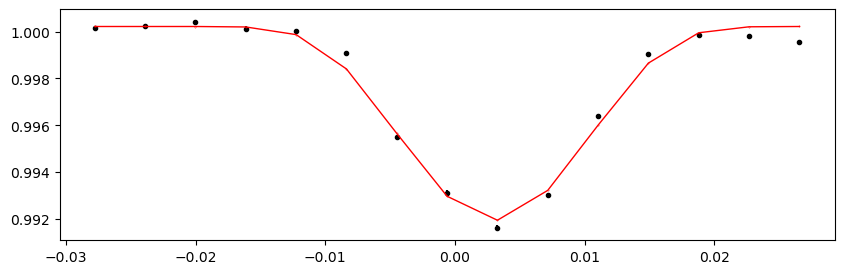

55530.244449000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.24it/s]


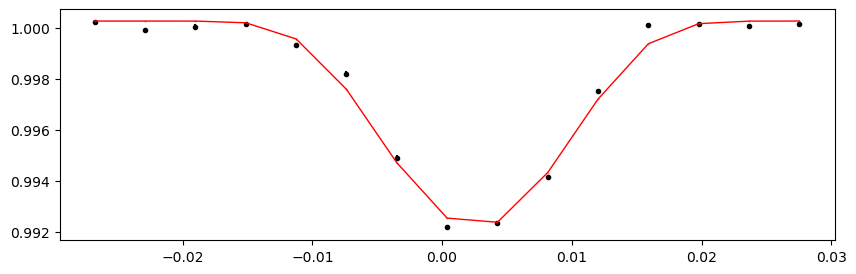

55535.510849000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.49it/s]


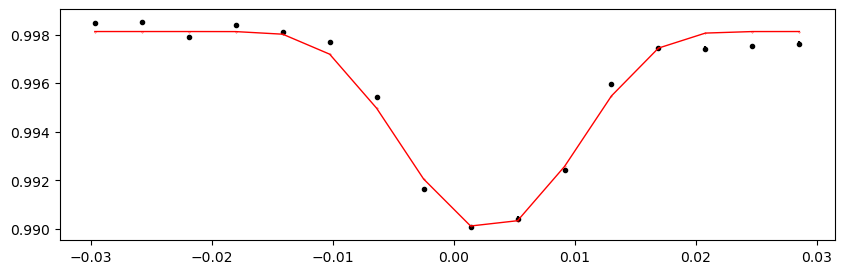

55540.777249000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.91it/s]


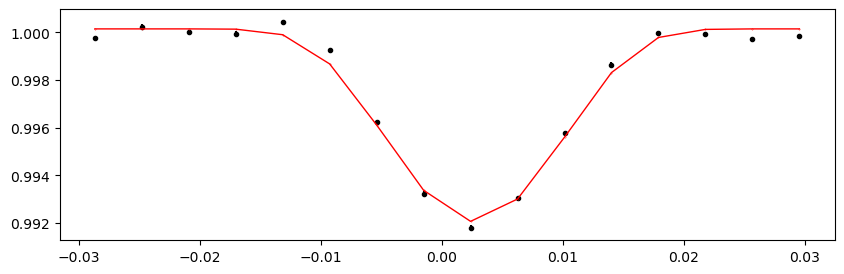

55546.043649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.77it/s]


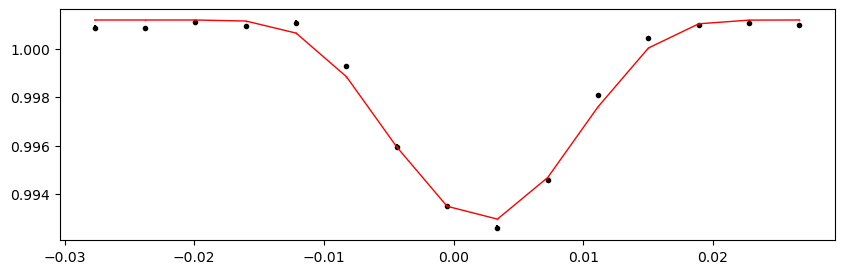

55551.310049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.85it/s]


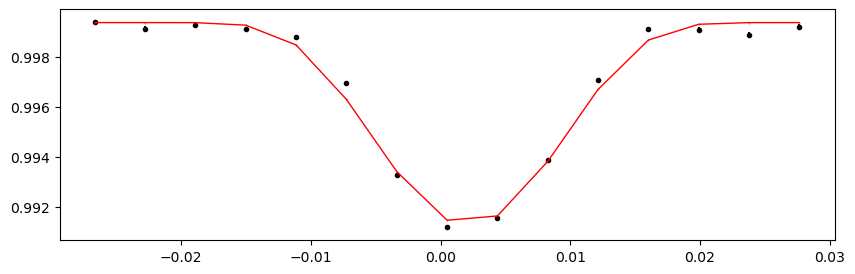

55572.375649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.52it/s]


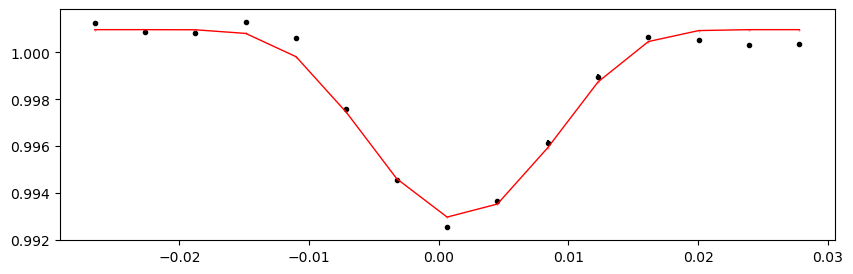

55577.642049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.83it/s]


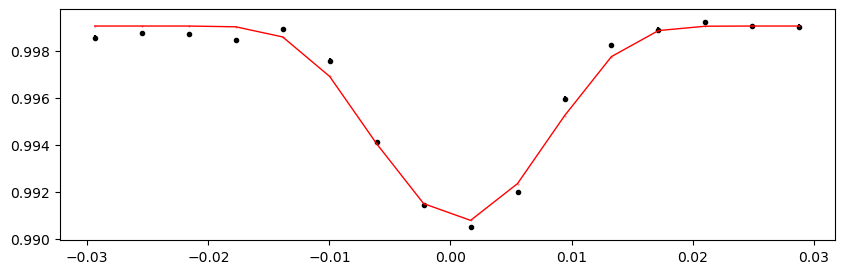

55582.908449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.83it/s]


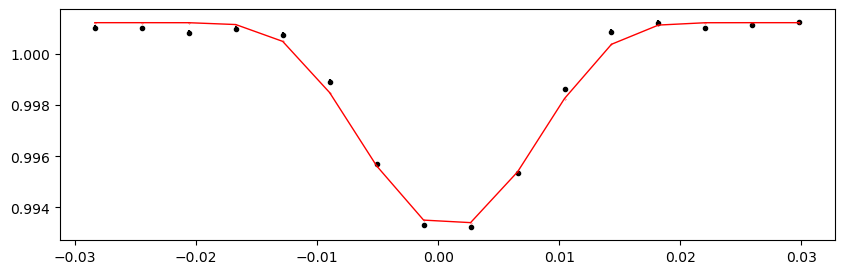

55588.174849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.21it/s]


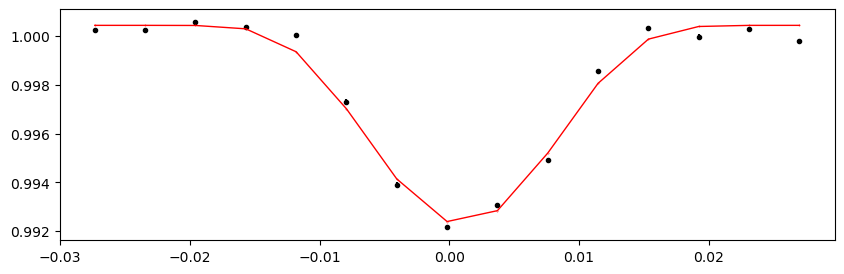

55593.441249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.04it/s]


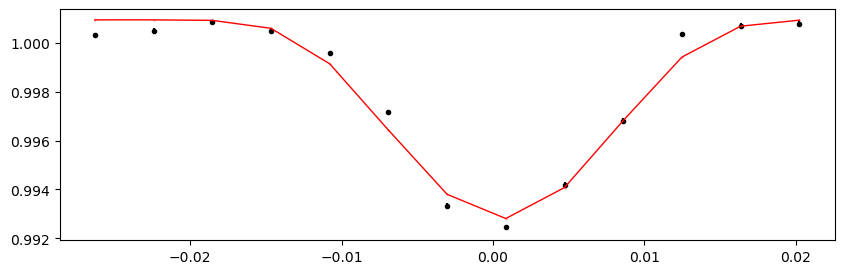

55598.707649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.37it/s]


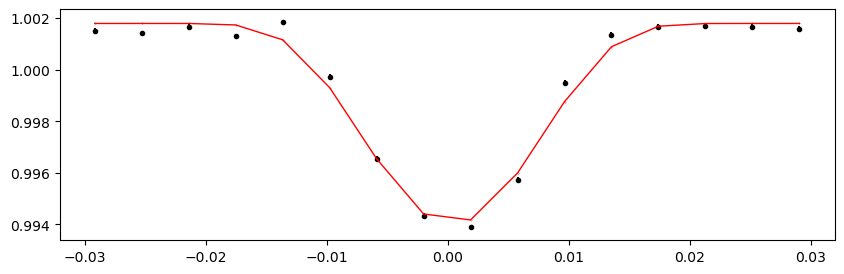

55603.974049000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.35it/s]


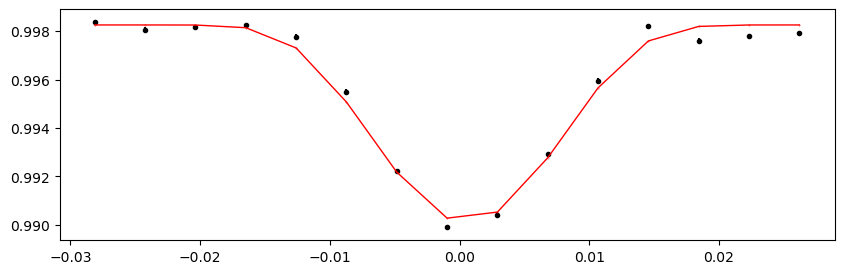

55609.240449000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.18it/s]


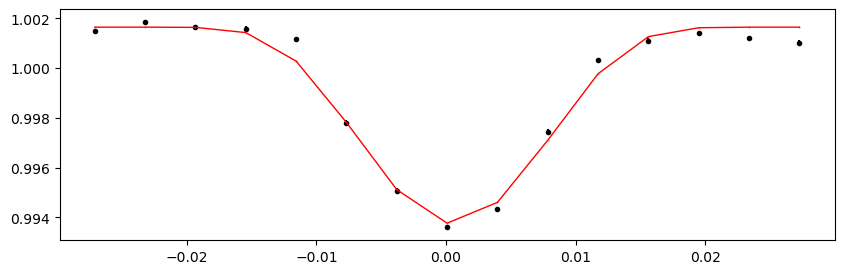

55614.506849000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.75it/s]


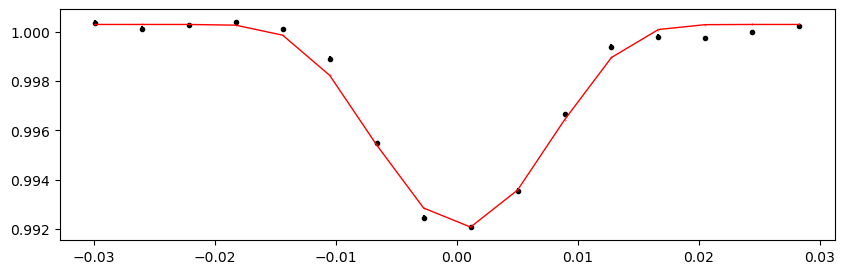

55619.773249000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.66it/s]


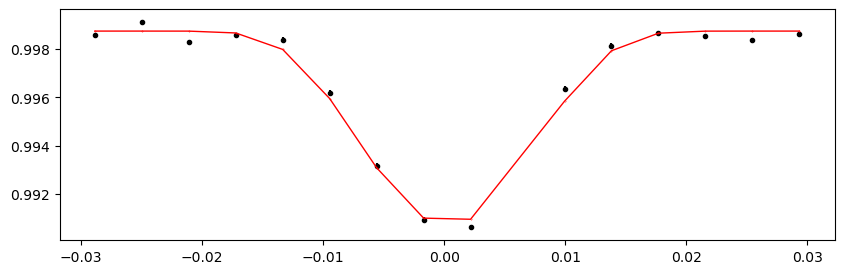

55625.039649000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.32it/s]


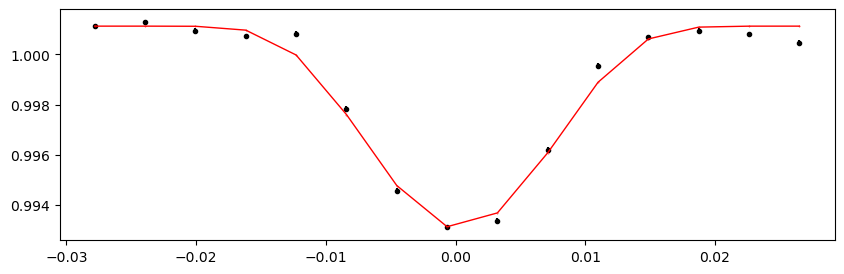

55630.306049000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.90it/s]


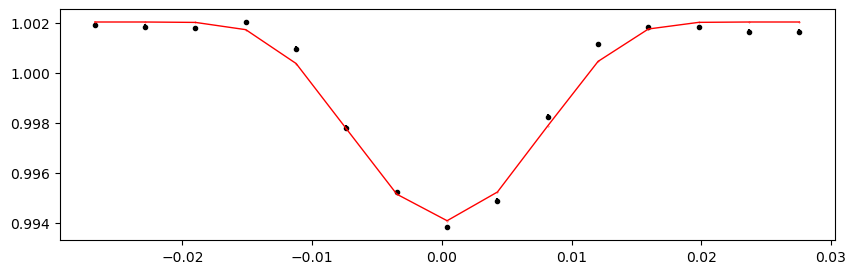

55651.371649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.16it/s]


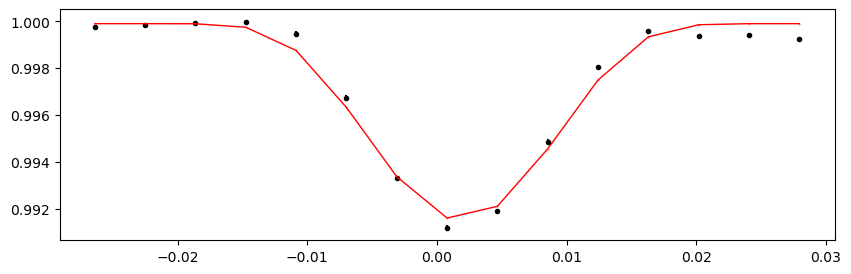

55656.638049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.39it/s]


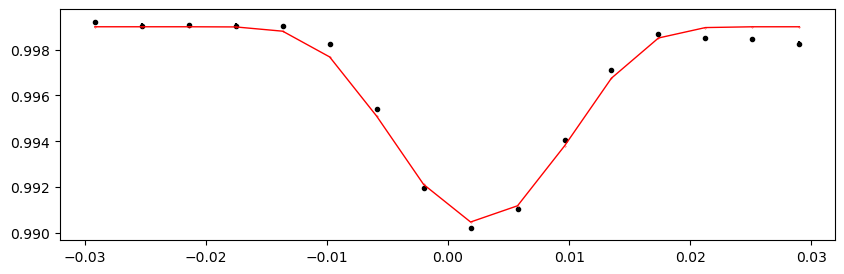

55661.904449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.17it/s]


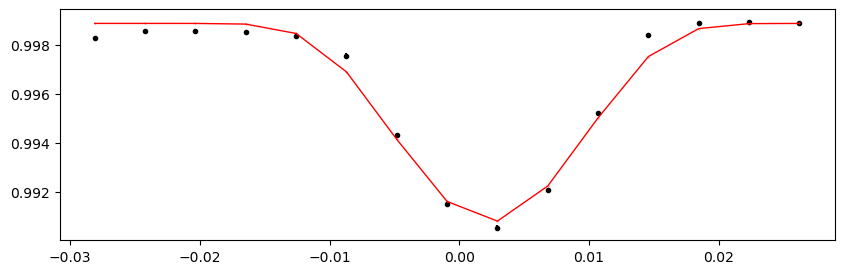

55667.170849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.67it/s]


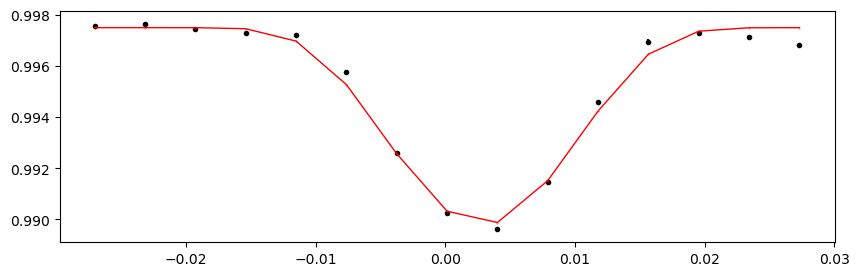

55672.437249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.97it/s]


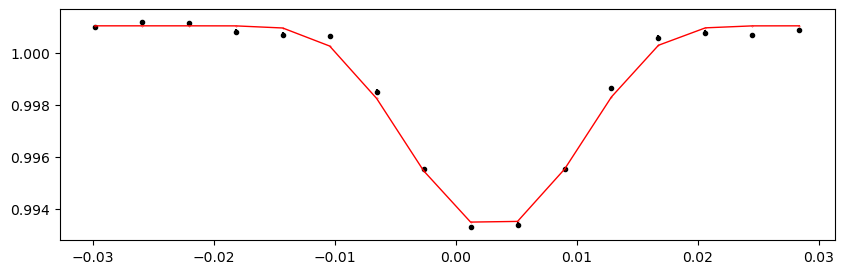

55682.970049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.53it/s]


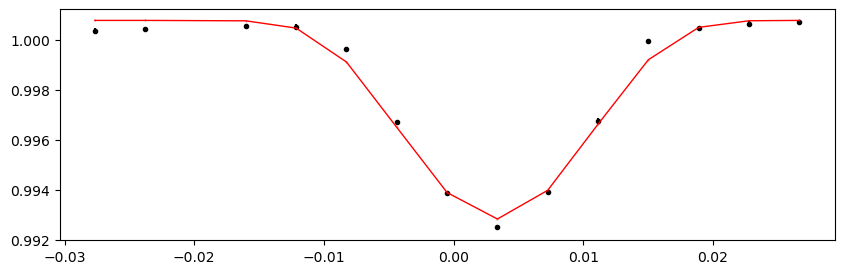

55688.236449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.90it/s]


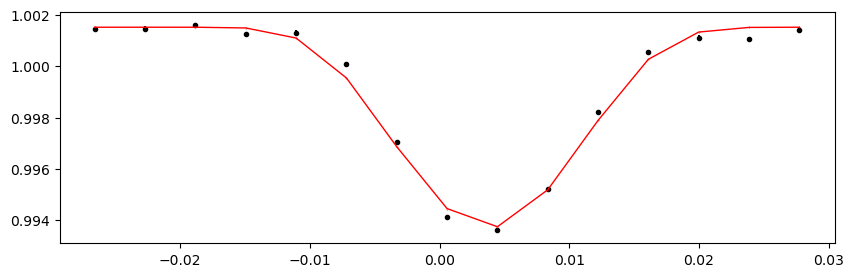

55693.502849000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.75it/s]


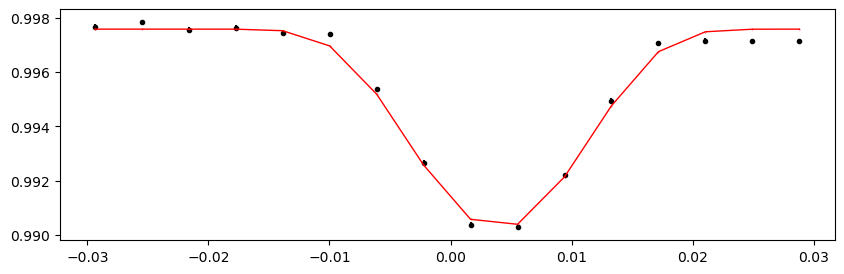

55698.769249000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.77it/s]


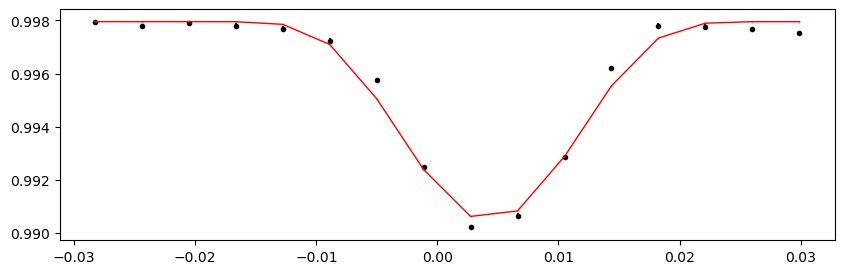

55704.035649000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.27it/s]


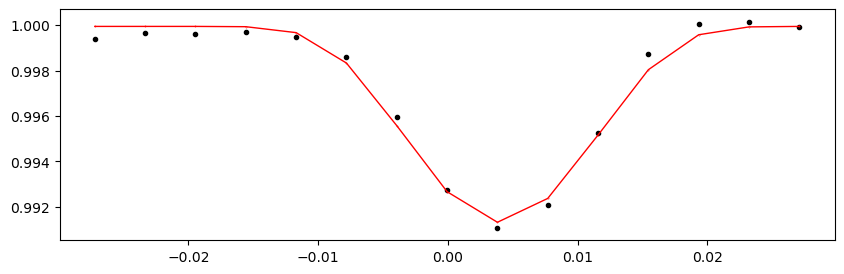

55709.302049000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.05it/s]


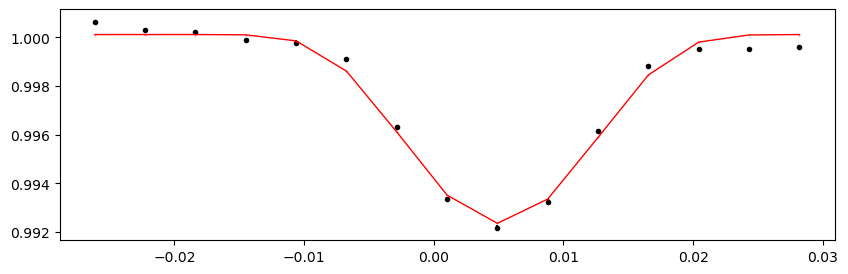

55714.568449000006 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.01it/s]


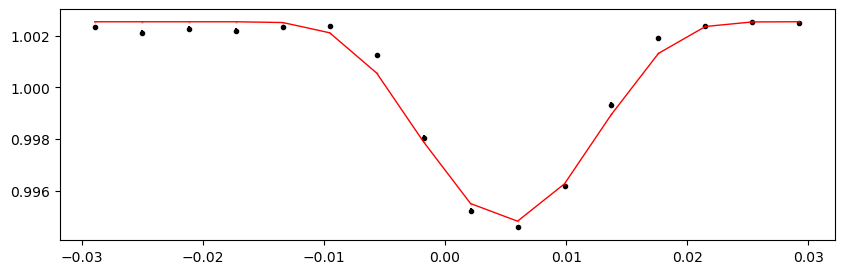

55725.101249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.54it/s]


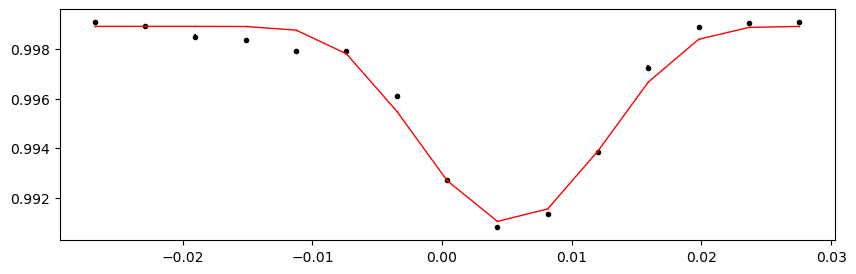

55730.367649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.27it/s]


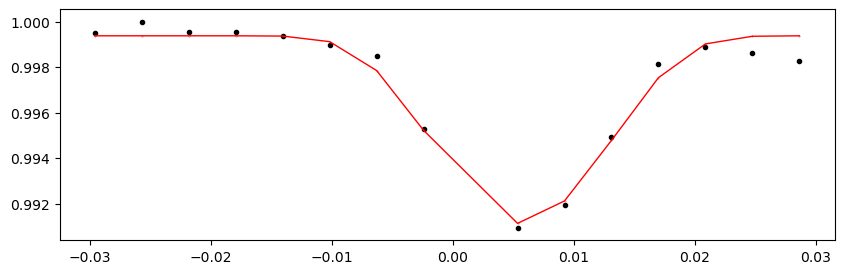

55735.634049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.03it/s]


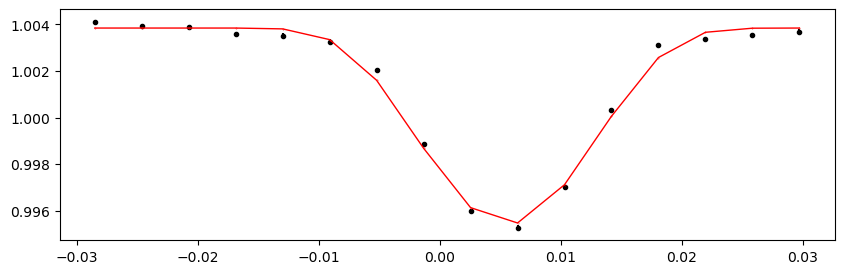

55740.900449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.98it/s]


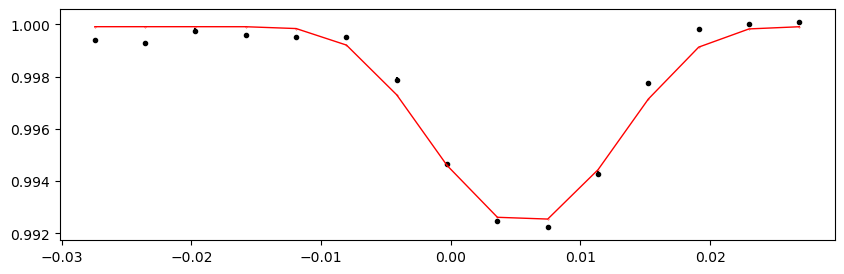

55746.166849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.39it/s]


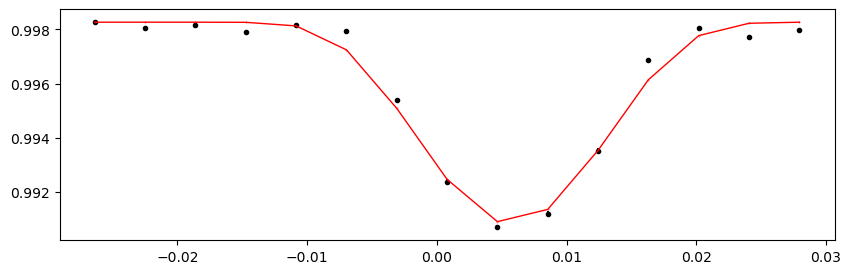

55751.433249 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.46it/s]


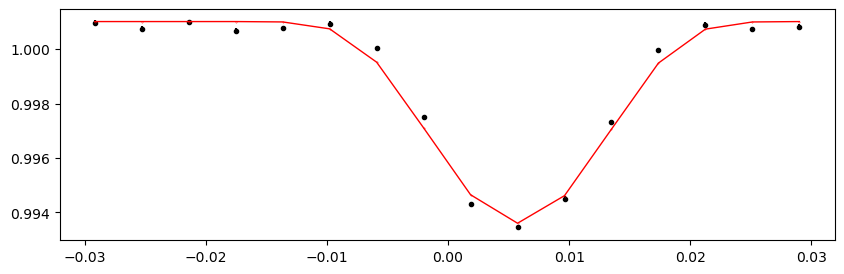

55756.699649 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.96it/s]


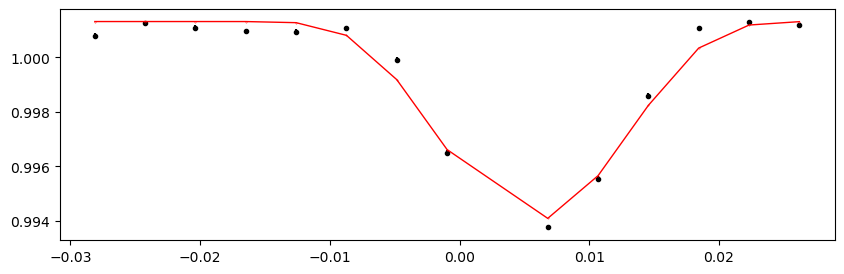

55761.966049 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.79it/s]


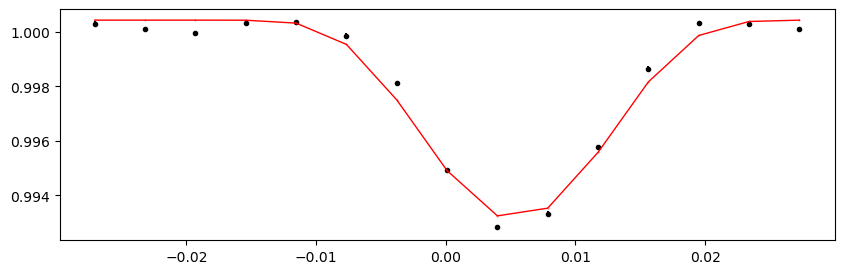

55767.232449 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.15it/s]


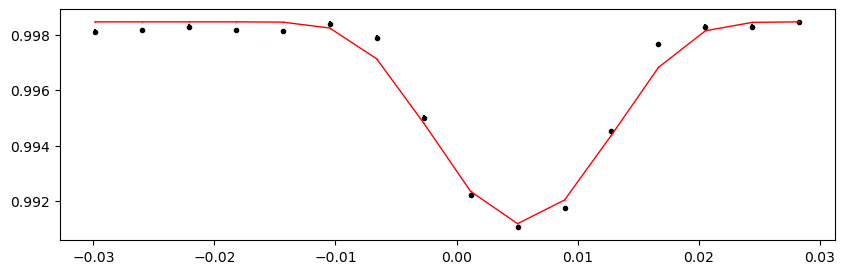

55772.498849 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.95it/s]


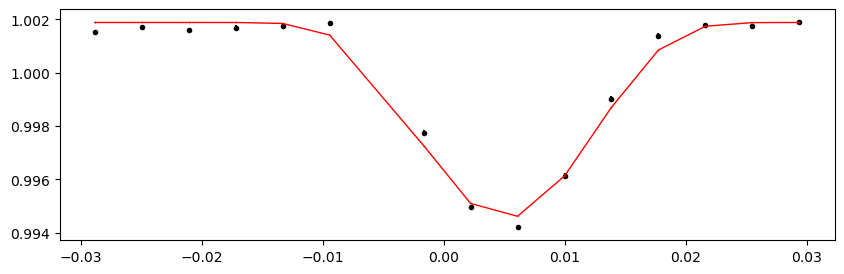

55777.765249000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.00it/s]


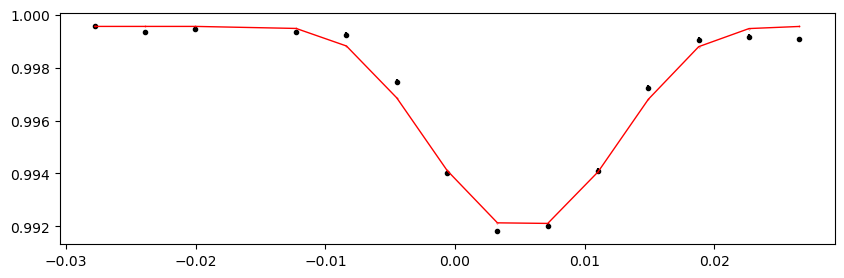

55783.031649000004 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.31it/s]


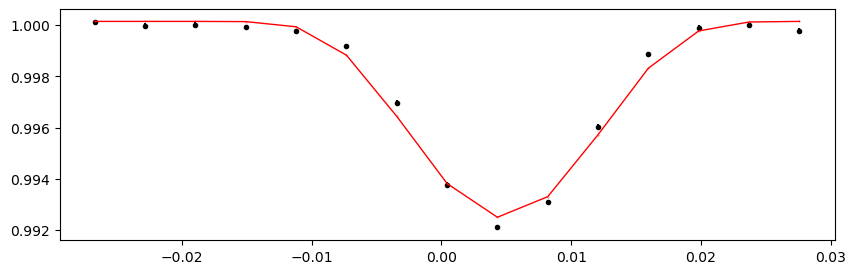

55788.298049000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.47it/s]


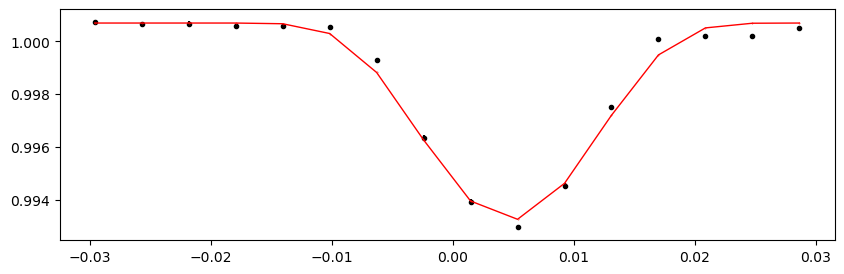

55793.564449000005 1.0000924405906262 -0.008121749571054918 0.2512594779208649


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.74it/s]


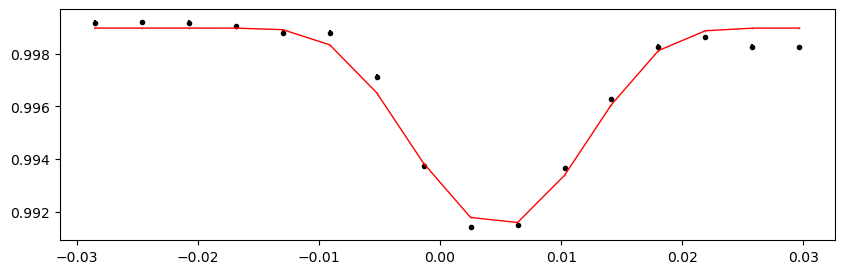

In [79]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# -----

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

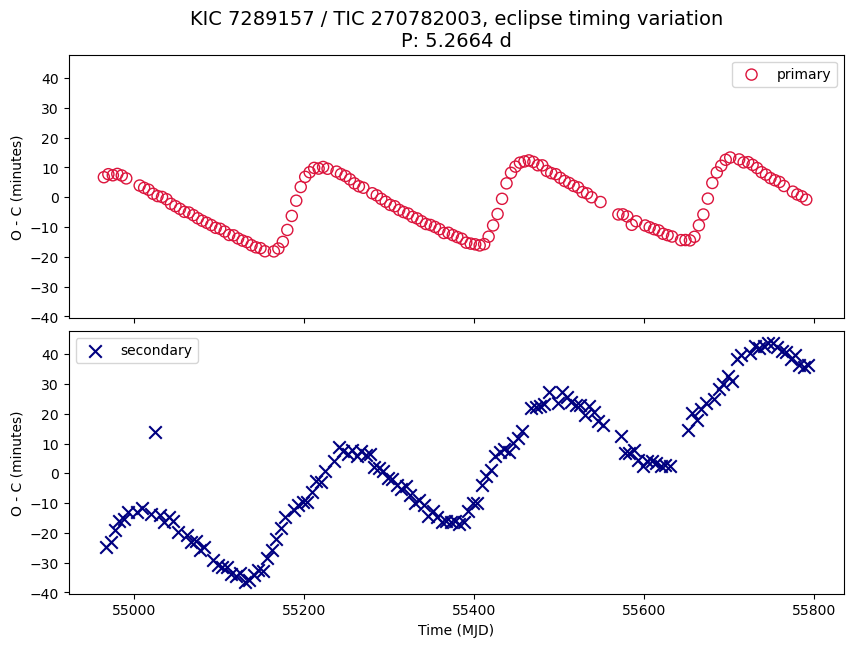

In [7]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True, sharey=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### O-C Plot, Zoom In

In [ ]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] < 55800]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] < 55800]


    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

# ---

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] > 59000]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] > 59000]
    in_df_secondary = in_df_secondary[in_df_secondary['shift_mins'] < 10]  # exclude a single outlier

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

    axs[1].set_xlim(axs[1].get_xlim()[0], axs[1].get_xlim()[0] + (axs[0].get_xlim()[1] - axs[0].get_xlim()[0]))  # same X scale

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


## make a periodogram 

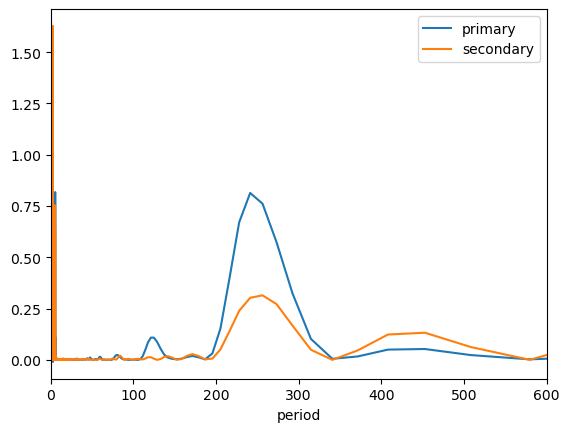

In [8]:
# TESS data roughly has a peak of ~500 days. The period found in Kepler data.
# it's understandably nosier

frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower(minimum_frequency=1 / 1000)  # ensure the max period exceeds ~500 d in the paper

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower(minimum_frequency=1 / 1000)
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 600)
plt.show()


## Results Summary

In [16]:
# FILL-IN the ETV results / comments
has_etv = "Practice"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "Reproducing Kepler ETV in 2013ApJ works, for both primary and secondary eclipises in Kepler data. ETV for secondary seems to have additional longer term (1000+ days) variability. TESS (QLP, 6 sectors) data and ZTF data do not show any eclipses."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),  # counting TESS only
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                   270782003
has_etv                                                                                                                                                                                Practice
comments     Reproducing Kepler ETV in 2013ApJ works, for both primary and secondary eclipises in Kepler data. ETV for secondary seems to have additional longer term (1000+ days) variability.
period                                                                                                                                                                                   5.2664
depth_pct_p                                                                                                                                                                                6.86
depth_pct_s                                                                                                                                                                                0.81
epoch_p                                                                                                                                                                            54964.204649
epoch_s                                                                                                                                                                            54966.739649
num_sectors                                                                                                                                                                                  17
time_span                                                                                                                                                                                835.98
time_start                                                                                                                                                                             54964.01
time_end                                                                                                                                                                               55799.99


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
270782003,Practice,"Reproducing Kepler ETV in 2013ApJ works, for both primary and secondary eclipises in Kepler data. ETV for secondary seems to have additional longer term (1000+ days) variability.",5.2664,6.86,0.81,54964.204649,54966.739649,17,835.98,54964.01,55799.99

